In [143]:
from IPython.display import display
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy
import statsmodels.formula.api as smf

In [144]:
survey_df = pd.read_csv('../data/cleaned-online-v1-prolific-sample.csv')
survey_df.head(3)

,Duration (in seconds),RecordedDate,ResponseId,Q_sandwich_1,Q_sandwich_2,Q_sandwich_3,Q_sandwich_4,Q_sandwich_5,Q_sandwich_1_labeled,Q_sandwich_2_labeled,...,Q_live_urban,Q_work_urban,Q_work_urban_3_TEXT,Q_demos_age,Q_demos_gender,Q_demos_income,Q_demos_race,Q_comments,STUDY_ID,treatment
0,123,2022-06-28 09:32:52,R_125SdSXI0xLI29S,NaN,NaN,NaN,NaN,NaN,0.0,0.0,...,2,1,NaN,4,1,6,1,NaN,62bb1ba7f2c710e36fd2c1be,labeled
1,231,2022-06-28 09:34:23,R_23V4Eyckqxl6Bmy,0.0,0.0,0.0,1.0,0.0,NaN,NaN,...,2,2,NaN,7,1,5,1,I do not lean toward either party. I am a libe...,62bb1ba7f2c710e36fd2c1be,unlabeled
2,239,2022-06-28 09:35:35,R_2c5wLF9HxTeZ30h,NaN,NaN,NaN,NaN,NaN,0.0,0.0,...,1,2,NaN,5,2,2,1,"None, but thank you!",62bb1ba7f2c710e36fd2c1bf,labeled


In [145]:
print(list(survey_df.columns))

['Duration (in seconds)', 'RecordedDate', 'ResponseId', 'Q_sandwich_1', 'Q_sandwich_2', 'Q_sandwich_3', 'Q_sandwich_4', 'Q_sandwich_5', 'Q_sandwich_1_labeled', 'Q_sandwich_2_labeled', 'Q_sandwich_3_labeled', 'Q_sandwich_4_labeled', 'Q_sandwich_5_labeled', 'Q_current_hunger', 'Q_priorities_1', 'Q_priorities_2', 'Q_priorities_3', 'Q_priorities_4', 'Q_priorities_5', 'Q_special_diet', 'Q_special_diet_6_TEXT', 'Q_past_vegetarian', 'Q_past_vegan', 'Q_vegetarian_not_me', 'Q_vegan_not_me', 'Q_good_for_env', 'Q_how_important_env', 'Q_politics', 'Q_US_state', 'Q_live_urban', 'Q_work_urban', 'Q_work_urban_3_TEXT', 'Q_demos_age', 'Q_demos_gender', 'Q_demos_income', 'Q_demos_race', 'Q_comments', 'STUDY_ID', 'treatment']


## Data preprocessing


Transform into tables:


1. Respondent data table:

Contains all relevant non-choice data for a respondent

2. Menu choices table

```
ResponseId, labeled (1/0), QID, choice type (1-5), choice (1/0) 
```

In [146]:
choice_Q_prefix = 'Q_sandwich'
choice_Qs = [q for q in survey_df.columns if q.startswith(choice_Q_prefix)]
print(choice_Qs)

['Q_sandwich_1', 'Q_sandwich_2', 'Q_sandwich_3', 'Q_sandwich_4', 'Q_sandwich_5', 'Q_sandwich_1_labeled', 'Q_sandwich_2_labeled', 'Q_sandwich_3_labeled', 'Q_sandwich_4_labeled', 'Q_sandwich_5_labeled']


In [147]:
# extract the columns we use
respondent_columns = [
    'ResponseId', 
    'Duration (in seconds)', 'RecordedDate',
    # removed during preprocessing:
    # 'PROLIFIC_PID',
    # 'Finished',
    # 'Q_attn_1', 'Q_attn_2', 'Q_attn_check', 'Q_attn_midway',
    'Q_current_hunger', 'Q_live_urban', 'Q_work_urban', 'Q_politics', 'Q_US_state',
    'Q_priorities_1', 'Q_priorities_2', 'Q_priorities_3', 'Q_priorities_4', 'Q_priorities_5',
    'Q_special_diet', 'Q_special_diet_6_TEXT', 
    'Q_past_vegetarian', 'Q_past_vegan', 
    'Q_vegetarian_not_me', 'Q_vegan_not_me', 
    'Q_good_for_env', 'Q_how_important_env',
    'Q_demos_age', 'Q_demos_gender', 'Q_demos_income', 'Q_demos_race', 
    'Q_comments',
    'treatment'
]

### Respondent table

In [148]:
respondent_df = survey_df[respondent_columns].copy()
starting_respondent_N = respondent_df['ResponseId'].nunique()
print('N=%s total responses before data cleaning' % starting_respondent_N)
respondent_df.head(3)

N=759 total responses before data cleaning


,ResponseId,Duration (in seconds),RecordedDate,Q_current_hunger,Q_live_urban,Q_work_urban,Q_politics,Q_US_state,Q_priorities_1,Q_priorities_2,...,Q_vegetarian_not_me,Q_vegan_not_me,Q_good_for_env,Q_how_important_env,Q_demos_age,Q_demos_gender,Q_demos_income,Q_demos_race,Q_comments,treatment
0,R_125SdSXI0xLI29S,123,2022-06-28 09:32:52,3,2,1,3,22,4,5,...,4,4,2,4,4,1,6,1,NaN,labeled
1,R_23V4Eyckqxl6Bmy,231,2022-06-28 09:34:23,2,2,2,3,22,2,3,...,3,3,2,4,7,1,5,1,I do not lean toward either party. I am a libe...,unlabeled
2,R_2c5wLF9HxTeZ30h,239,2022-06-28 09:35:35,2,1,2,1,20,2,3,...,4,4,1,5,5,2,2,1,"None, but thank you!",labeled


### Codebook

In [149]:
# This is a dump from the recode values exported from qualtrics Q_US_state.
# Qualtrics put the states in alphabetical order for their recode value, did not code by FIPs
states_recode_text = '1\nAlabama\n2\nAlaska\n3\nArizona\n4\nArkansas\n5\nCalifornia\n6\nColorado\n7\nConnecticut\n8\nDelaware\n9\nDistrict of Columbia\n10\nFlorida\n11\nGeorgia\n12\nHawaii\n13\nIdaho\n14\nIllinois\n15\nIndiana\n16\nIowa\n17\nKansas\n18\nKentucky\n19\nLouisiana\n20\nMaine\n21\nMaryland\n22\nMassachusetts\n23\nMichigan\n24\nMinnesota\n25\nMississippi\n26\nMissouri\n27\nMontana\n28\nNebraska\n29\nNevada\n30\nNew Hampshire\n31\nNew Jersey\n32\nNew Mexico\n33\nNew York\n34\nNorth Carolina\n35\nNorth Dakota\n36\nOhio\n37\nOklahoma\n38\nOregon\n39\nPennsylvania\n40\nPuerto Rico\n41\nRhode Island\n42\nSouth Carolina\n43\nSouth Dakota\n44\nTennessee\n45\nTexas\n46\nUtah\n47\nVermont\n48\nVirginia\n49\nWashington\n50\nWest Virginia\n51\nWisconsin\n52\nWyoming\n53\nI do not reside in the United States'
states_recode_list = states_recode_text.split('\n')
states_choices_map = {states_recode_list[i]: states_recode_list[i+1] for i in range(0, len(states_recode_list), 2)}
# states_choices_map

In [150]:
# {QID: {Q: Q text, choices: map}}
codebook = {
    'Q_current_hunger': {
        'Q': 'How would you rank your current hunger level on a scale from 1 - 4?',
        'choices': {
            '1':'1 (Not hungry at all)','2':'2','3':'3','4':'4 (Very hungry)'
        },
    },
    'Q_special_diet':{
        'Q': 'Are you on any special diet? (select all that apply)',
        'choices': {
            '1':'Keto','2':'Pescatarian','3':'Vegetarian',
            '4':'Gluten free','5':'Vegan','6':'Other','7':'None'
        },
    },
    'Q_past_vegetarian': {
        'Q':'In the past 7 days, on how many days did you have a meal that contained any meat, poultry, or fish?',
        'choices': {
            '7': 7,
            '6': 6,
            '5': 5,
            '4': 4,
            '3': 3,
            '2': 2,
            '1': 1,
            '0': 0,
        },
    },
    'Q_past_vegan': {
        'Q':'In the past 7 days, on how many days did you eat a meal that contained any kind of animal product? (i.e. on how many days did you eat meat, poultry, fish, dairy, eggs, etc?)',
        'choices': {
            '7': 7,
            '6': 6,
            '5': 5,
            '4': 4,
            '3': 3,
            '2': 2,
            '1': 1,
            '0': 0,
        },
    },
    'Q_priorities': {
        'Q': 'How do you prioritize the following when choosing what to order for yourself off a menu?',
        'choices': {'1':'health','2':'cost','3':'taste','4':'filling','5':'usual_choice'},
    },
    'Q_good_for_env': {
        'Q':'How strongly do you agree with the following statement?\n"Vegetarian and vegan dishes are good for the environment."',
        'choices': {
            '1':'Strongly agree','2':'Agree','3':'Neutral',
            '4':'Disagree','5':'Strongly disagree'
        },
    },
    'Q_how_important_env': {
        'Q':'How important is environmental sustainability to you as an issue?',
        'choices': {
            '1':'Very much not important','2':'Not important',
            '3':'Neutral','4':'Somewhat important','5':'Very important'
        },
    },
    'Q_vegetarian_not_me': {
        'Q': 'How strongly do you agree with the following statement?\n"Vegetarian dishes are not for people like me."',
        'choices': {
            '1':'Strongly agree','2':'Agree','3':'Neutral',
            '4':'Disagree','5':'Strongly disagree'
        },
    },
    'Q_vegan_not_me': {
        'Q': 'How strongly do you agree with the following statement?\n"Vegan dishes are not for people like me."',
        'choices': {
            '1':'Strongly agree','2':'Agree','3':'Neutral',
            '4':'Disagree','5':'Strongly disagree'
        },
    },
    'Q_politics': {
        'Q':'Which of the following best describes your political preference?',
        'choices': {
            '1':'Strongly Democratic','2':'Democratic',
            '3':'Lean Democratic','4':'Lean Republican','5':'Republican','6':'Strongly Republican'
        }
    },
    'Q_live_urban': {
        'Q':'Which best describes the area you live?',
        'choices': {'1':'Urban','2':'Suburban','3':'Rural'},
    },
    'Q_work_urban': {
        'Q': 'Do you work in an urban area?',
        'choices': {'1':'Yes', '2':'No','3':'Not sure / Other'},
    },
    'Q_demos_gender': {
        'Q':'What is your gender?',
        'choices': {'1':'Male','2':'Female','3':'Other', '4':'Prefer not to answer'},
    },
    'Q_demos_age': {
        'Q': 'How old are you?',
        'choices': {
            '1':'Under 18', # should have none!
            '2':'18 - 24 years old',
            '3':'25 - 34 years old',
            '4':'35 - 44 years old',
            '5':'45 - 54 years old',
            '6':'55 - 64 years old',
            '7':'65+ years old'
        },
    },
    'Q_demos_income': {
        'Q': 'What was your total household income before taxes during the past 12 months?',
        'choices': {
            '1':'Less than \$25,000','2':'\$25,000 to \$49,999',
            '3':'\$50,000 to $74,999','4':'\$75,000 to \$99,999',
            '5':'\$100,000 to $149,999','6':'\$150,000 or more',
            '7':'Prefer not to say',
        },
    },
    'Q_demos_race': {
        'Q': 'Choose one or more races that you consider yourself to be',
        'choices': {
            '1':'White or Caucausian',
            '2':'Black or African American',
            '3':'American Indian/Native American or Alaska Native',
            '4':'Asian',
            '5':'Native Hawaiian or Other Pacific Islander',
            '6':'Other',
            '7':'Prefer not to say'
        },
    },
    'Q_US_state': {
        'Q':'In which state do you currently reside?',
        'choices': states_choices_map,
    },
}

In [151]:
for k in codebook.keys():
    if k == 'Q_priorities': continue
    assert(k in respondent_columns)

## Demographics


In which state do you currently reside?

10      1
15      1
38      1
42      1
1       1
17      1
31      2
23      2
48      3
45      4
39      4
5       7
47     29
33     30
41     54
30     54
20     65
7     143
22    356
Name: Q_US_state, dtype: int64


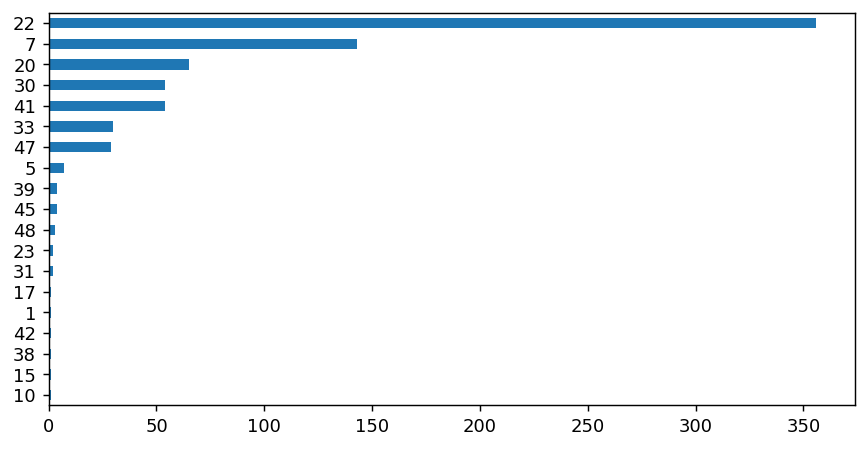

In [152]:
# Respondents by state
print('%s\n'%codebook['Q_US_state']['Q'])
fig,ax = plt.subplots(figsize=(8,4), dpi=130)
respondent_df['Q_US_state'].value_counts().sort_values().rename(
    codebook['Q_US_state']['choices']).plot.barh(ax=ax)
print(respondent_df['Q_US_state'].value_counts().sort_values().rename(
    codebook['Q_US_state']['choices']))

Count the self-reported vegans and vegetarians and exclude them from analysis.


(For respondents who selected one option)
None           613
Vegetarian      43
Other           38
Pescatarian     20
Keto            13
Vegan            9
Gluten free      8
Name: Q_special_diet, dtype: int64


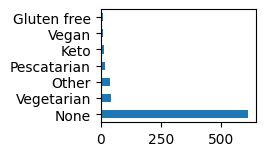

7          613
3           43
6           38
2           20
1           13
5            9
4            8
4,6          3
3,5          2
3,6          2
1,7          1
3,4          1
1,3,4        1
2,3          1
4,5          1
3,4,5,6      1
1,6          1
1,4          1
Name: Q_special_diet, dtype: int64


In [153]:
# '1':'Keto','2':'Pescatarian','3':'Vegetarian','4':'Gluten free','5':'Vegan','6':'Other','7':'None'
fig,ax = plt.subplots(figsize=(2,1.5), dpi=100)
# Not these value counts only include responses that selected one choice
print('(For respondents who selected one option)')
print(respondent_df.Q_special_diet.map(codebook['Q_special_diet']['choices']).value_counts())
respondent_df.Q_special_diet.map(codebook['Q_special_diet']['choices']).value_counts().plot.barh(ax=ax)
plt.show()
print(respondent_df['Q_special_diet'].value_counts())

Separate the vegan/vegetarian respondents from the others

In [154]:
respondent_df['is_vegetarian'] = respondent_df['Q_special_diet'].astype(str).apply(lambda d: 1 if ('3' in d) else 0)
respondent_df['is_vegan'] = respondent_df['Q_special_diet'].astype(str).apply(lambda d: 1 if ('5' in d) else 0)

veg_respondent_df = respondent_df[(respondent_df['is_vegetarian'] + respondent_df['is_vegan']) > 0]

print('total vegetarians and vegans (some overlap with participants reporting both): %s' % (len(veg_respondent_df)))
print('vegetarin: %s' % respondent_df['is_vegetarian'].sum())
print('vegan: %s' % respondent_df['is_vegan'].sum())

total vegetarians and vegans (some overlap with participants reporting both): 61
vegetarin: 51
vegan: 13


In [155]:
len(respondent_df[(respondent_df['is_vegetarian'] < 1) & (respondent_df['is_vegan'] < 1)])

698

In [156]:
print('dropping vegans and vegetarians from main sample')
respondent_df = respondent_df[
    (respondent_df['is_vegetarian'] < 1) & (respondent_df['is_vegan'] < 1)
].drop(['is_vegan','is_vegetarian'], axis=1)
N = len(respondent_df)
print('resulting N=%s' % N)

dropping vegans and vegetarians from main sample
resulting N=698


What about the the pescatarians?

Who are they? Should they be excluded? Related works [1,2] exclude them but we did not pre-register that exclusion.

[1] Attwood, S., Chesworth, S. J., & Parkin, B. L. (2020). Menu engineering to encourage sustainable food choices when dining out: An online trial of priced-based decoys. Appetite, 149, 104601. https://doi.org/10.1016/j.appet.2020.104601

[2] Parkin, B. L., & Attwood, S. (2022). Menu design approaches to promote sustainable vegetarian food choices when dining out. Journal of Environmental Psychology, 79, 101721. https://doi.org/10.1016/j.jenvp.2021.101721

In [157]:
respondent_df['is_pescatarian'] = respondent_df['Q_special_diet'].astype(str).apply(lambda d: 1 if ('2' in d) else 0)
(respondent_df[respondent_df['is_pescatarian']==1]['Q_demos_gender']
 .astype(str)
 .map(codebook['Q_demos_gender']['choices'])
 .value_counts()
)

Female    15
Male       4
Other      1
Name: Q_demos_gender, dtype: int64

In [158]:
"""
Make a table representing aggregate characteristics of the sample

characteristic, count or mean, (%) or (std) 
"""

sample_characteristics_cols = ['characteristic', 'count or mean', '(%) or (std)']
sample_aggregate_characteristics_df = pd.DataFrame({}, columns=sample_characteristics_cols)
sample_aggregate_characteristics_df

,characteristic,count or mean,(%) or (std)


                      count   (%)
gender                           
Female                  376  53.9
Male                    303  43.4
Other                    17   2.4
Prefer not to answer      2   0.3


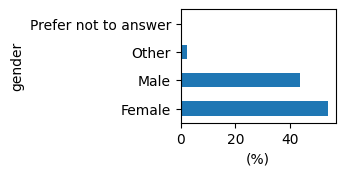

In [159]:
respondent_df['gender'] = respondent_df.Q_demos_gender.astype(str).map(codebook['Q_demos_gender']['choices'])
fig,ax = plt.subplots(figsize=(2,1.5),dpi=100)
gender_counts = respondent_df.groupby(
    'gender'
)['ResponseId'].count().rename('count').to_frame()
gender_counts['(%)'] = 100*round(gender_counts['count']/gender_counts['count'].sum(), 3)
print(gender_counts)
gender_counts['(%)'].plot.barh(ax=ax)
_ = ax.set_xlabel('(%)')

We code gender as a binary of male vs non-male

In [160]:
respondent_df['male'] = respondent_df['gender'].apply(lambda g: 1 if g =='Male' else 0)

In [161]:
gender_df = pd.DataFrame([
    ['Male',  respondent_df.male.sum(), round(100*respondent_df.male.sum()/N, 2)]],
    columns=sample_characteristics_cols,
)
sample_aggregate_characteristics_df = pd.concat([sample_aggregate_characteristics_df,gender_df])

How old are you?


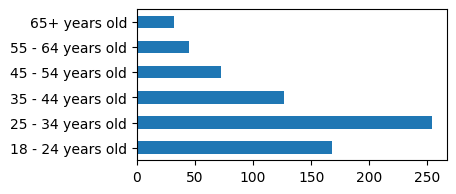

,index,count,pct
0,18 - 24 years old,168,24.07
1,25 - 34 years old,254,36.39
2,35 - 44 years old,127,18.19
3,45 - 54 years old,72,10.32
4,55 - 64 years old,45,6.45
5,65+ years old,32,4.58


In [162]:
print('%s'%codebook['Q_demos_age']['Q'])
fig,ax = plt.subplots(figsize=(4,2), dpi=100)
_ = respondent_df['Q_demos_age'].astype(str).value_counts().sort_index().rename(codebook['Q_demos_age']['choices']).plot.barh(ax=ax)
plt.show()
age_df = (respondent_df['Q_demos_age'].astype(str).value_counts()
          .sort_index().rename(codebook['Q_demos_age']['choices'])
          .to_frame(name='count').reset_index()
          .assign(pct=lambda x: round(100*x['count']/N, 2)))
age_df

In [163]:
age_df.columns = sample_characteristics_cols
sample_aggregate_characteristics_df = pd.concat([
    sample_aggregate_characteristics_df, 
    pd.DataFrame([['Age', '','']], columns=sample_characteristics_cols),
    age_df
])

What was your total household income before taxes during the past 12 months?



,index,count,pct
0,"Less than \$25,000",82,11.75
1,"\$25,000 to \$49,999",143,20.49
2,"\$50,000 to $74,999",133,19.05
3,"\$75,000 to \$99,999",120,17.19
4,"\$100,000 to $149,999",113,16.19
5,"\$150,000 or more",81,11.60
6,Prefer not to say,26,3.72


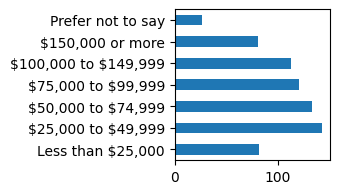

In [164]:
print('%s\n'%codebook['Q_demos_income']['Q'])
fig,ax = plt.subplots(figsize=(2,2), dpi=100)
_ = respondent_df['Q_demos_income'].astype(str).value_counts().sort_index().rename(
    codebook['Q_demos_income']['choices']).plot.barh(ax=ax)

income_df = (respondent_df['Q_demos_income'].astype(str).value_counts()
          .sort_index().rename(codebook['Q_demos_income']['choices'])
          .to_frame(name='count').reset_index()
          .assign(pct=lambda x: round(100*x['count']/N, 2)))
income_df

In [165]:
income_df.columns = sample_characteristics_cols
sample_aggregate_characteristics_df = pd.concat([
    sample_aggregate_characteristics_df,
    pd.DataFrame([['Household income', '','']], columns=sample_characteristics_cols),
    income_df
])

Race

Note 2019 census estimates for MA have White alone at 80%

https://www.census.gov/quickfacts/MA

According to ACS 2018, White Americans are 80.7% of New England. [(From wikipedia)](https://en.wikipedia.org/wiki/Demographics_of_New_England#:~:text=In%20terms%20of%20race%20and,people%20of%20non%2DHispanic%20origin.)

,index,count,pct
0,White or Caucausian,569,81.52
1,Other,55,7.88
2,Asian,44,6.30
3,Black or African American,27,3.87
4,Native Hawaiian or Other Pacific Islander,2,0.29
5,American Indian/Native American or Alaska Native,1,0.14


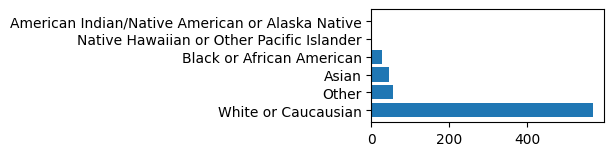

In [166]:
# Race: We put anyone who answered with 2 or more races or 'Prefer not to say' 
# in the 'Other' category
# print(respondent_df['Q_demos_race'].value_counts().sort_values())
respondent_df['race'] = (respondent_df['Q_demos_race']
                       .apply(lambda r: r if r in ['1','2','3','4','5'] else '6')
                       .map(codebook['Q_demos_race']['choices']))
race_df = (respondent_df['race'].value_counts().sort_values(ascending=False)
          .to_frame(name='count').reset_index()
          .assign(pct=lambda x: round(100*x['count']/N, 2)))
fig,ax = plt.subplots(1,1,figsize=(3,1.5),dpi=100)
_ = ax.barh(race_df['index'], race_df['count'])
race_df

Which of the following best describes your political preference?
{'1': 'Strongly Democratic', '2': 'Democratic', '3': 'Lean Democratic', '4': 'Lean Republican', '5': 'Republican', '6': 'Strongly Republican'}


,count
Strongly Democratic,184
Democratic,201
Lean Democratic,185
Lean Republican,91
Republican,28
Strongly Republican,9


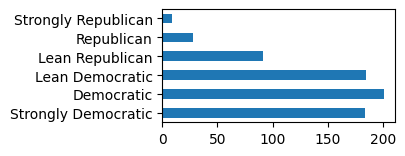

In [167]:
print('%s\n%s' % (codebook['Q_politics']['Q'], codebook['Q_politics']['choices']))
fig,ax = plt.subplots(figsize=(3,1.5),dpi=100)
respondent_df.Q_politics.astype(str).value_counts().sort_index().rename(
    codebook['Q_politics']['choices']).plot.barh(ax=ax)
respondent_df.Q_politics.astype(str).value_counts().sort_index().rename(
    codebook['Q_politics']['choices']).rename('count').to_frame()

Which best describes the area you live?


,count
Suburban,401
Urban,185
Rural,112


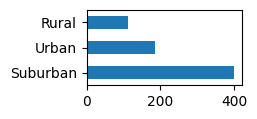

In [168]:
print(codebook['Q_live_urban']['Q'])
fig,ax = plt.subplots(figsize=(2,1),dpi=100)
respondent_df['Q_live_urban'].astype(str).value_counts().rename(
    codebook['Q_live_urban']['choices']).plot.barh(ax=ax)
respondent_df['Q_live_urban'].astype(str).value_counts().rename(
    codebook['Q_live_urban']['choices']).rename('count').to_frame()

Do you work in an urban area?


,count
No,412
Yes,264
Not sure / Other,22


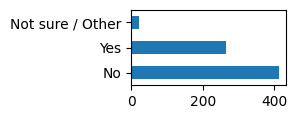

In [169]:
print(codebook['Q_work_urban']['Q'])
fig,ax = plt.subplots(figsize=(2,1),dpi=100)
respondent_df['Q_work_urban'].astype(str).value_counts().rename(
    codebook['Q_work_urban']['choices']).plot.barh(ax=ax)
respondent_df['Q_work_urban'].astype(str).value_counts().rename(
    codebook['Q_work_urban']['choices']).rename('count').to_frame()

How would you rank your current hunger level on a scale from 1 - 4?
1    132
2    278
3    228
4     60
Name: Q_current_hunger, dtype: int64


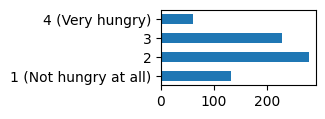

In [170]:
print(codebook['Q_current_hunger']['Q'])
fig,ax = plt.subplots(figsize=(2,1), dpi=100)
respondent_df['Q_current_hunger'].astype(str).value_counts().sort_index().rename(codebook['Q_current_hunger']['choices']).plot.barh(ax=ax)
print(respondent_df['Q_current_hunger'].astype(str).value_counts().sort_index())

Transform (1-4) values from strings to integers

In [171]:
respondent_df['Q_current_hunger'] = respondent_df['Q_current_hunger'].astype(int)

In [172]:
sample_aggregate_characteristics_df = pd.concat([sample_aggregate_characteristics_df ,pd.DataFrame(
    [['current hunger (1 - 4)', 
        respondent_df['Q_current_hunger'].mean(), 
        respondent_df['Q_current_hunger'].std()]],
    columns=sample_characteristics_cols
)])
# sample_aggregate_characteristics_df

In [173]:
print(codebook['Q_priorities']['Q'])
print(codebook['Q_priorities']['choices'])

How do you prioritize the following when choosing what to order for yourself off a menu?
{'1': 'health', '2': 'cost', '3': 'taste', '4': 'filling', '5': 'usual_choice'}


Transform from string to integer values

In [174]:
for p in codebook['Q_priorities']['choices'].keys():
    respondent_df['Q_priorities_%s'%p] = respondent_df['Q_priorities_%s'%p].astype(int)

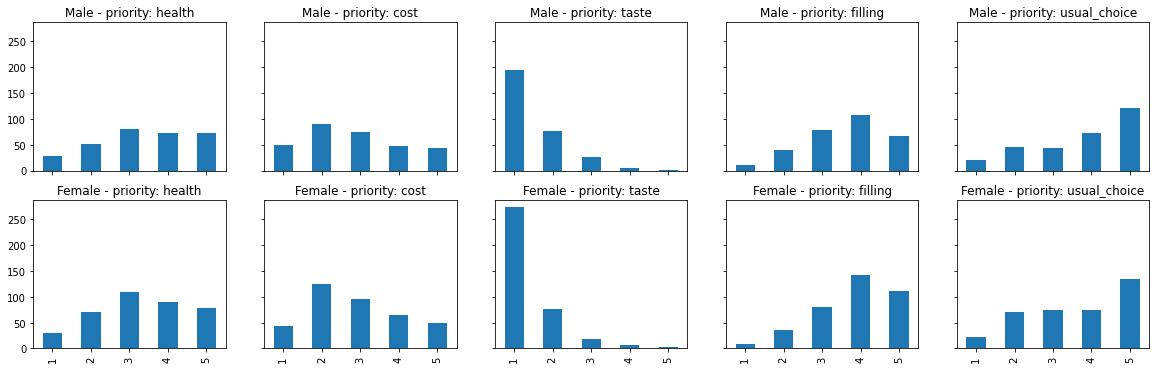

In [175]:
priorities_N = len(codebook['Q_priorities']['choices'])
fig, axes = plt.subplots(2, priorities_N, figsize=(4*priorities_N, 3*2), sharey=True, sharex=True)
for g, gender in enumerate(['Male','Female']):
    g_df = respondent_df[respondent_df['gender']==gender]
    for i, (p, priority) in enumerate(codebook['Q_priorities']['choices'].items()):
        Q_priority = 'Q_priorities_%s'%p
        ax = axes[g][i]
        ax.set_title('%s - priority: %s' % (gender, priority))
        g_df[Q_priority].value_counts().sort_index().plot.bar(ax=ax)

In [176]:
pkeys = list(codebook['Q_priorities']['choices'].keys())
priorities_df = pd.DataFrame({
    'priority': list(codebook['Q_priorities']['choices'].values()),
    'mean': [respondent_df['Q_priorities_%s'%p].mean() for p in pkeys],
    '(std)': [respondent_df['Q_priorities_%s'%p].std() for p in pkeys],
}, index=pkeys).sort_values('mean')
priorities_df

,priority,mean,(std)
3,taste,1.434097,0.733957
2,cost,2.829513,1.247501
1,health,3.353868,1.235298
5,usual_choice,3.653295,1.311081
4,filling,3.729226,1.050943


In [177]:
priorities_df.columns = sample_characteristics_cols
sample_aggregate_characteristics_df = pd.concat([
    sample_aggregate_characteristics_df,
    pd.DataFrame([['Relative importance when choosing off a menu', '','']], columns=sample_characteristics_cols),
    priorities_df
])

How often does each priority occur as a top priority?

In [178]:
top_priority_df = (
    pd.DataFrame({
        'priority': list(codebook['Q_priorities']['choices'].values()),
        'count':[respondent_df['Q_priorities_%s'%p].apply(lambda p: p==1).sum() for p in pkeys],
    })
    .assign(pct=lambda x: round(100*x['count']/N, 2))
    .sort_values('pct', ascending=False)
)
top_priority_df

,priority,count,pct
2,taste,475,68.05
1,cost,100,14.33
0,health,57,8.17
4,usual_choice,47,6.73
3,filling,19,2.72


In [179]:
top_priority_df.columns = sample_characteristics_cols
sample_aggregate_characteristics_df = pd.concat([
    sample_aggregate_characteristics_df,
    pd.DataFrame([['Top priority when choosing off a menu', '','']], columns=sample_characteristics_cols),
    top_priority_df
])
# sample_aggregate_characteristics_df

In [180]:
print(codebook['Q_past_vegetarian']['Q'])
print(codebook['Q_past_vegan']['Q'])

In the past 7 days, on how many days did you have a meal that contained any meat, poultry, or fish?
In the past 7 days, on how many days did you eat a meal that contained any kind of animal product? (i.e. on how many days did you eat meat, poultry, fish, dairy, eggs, etc?)


In [181]:
respondent_df['Q_past_vegetarian'] = respondent_df['Q_past_vegetarian'].astype(int)
respondent_df['Q_past_vegan'] = respondent_df['Q_past_vegan'].astype(int)

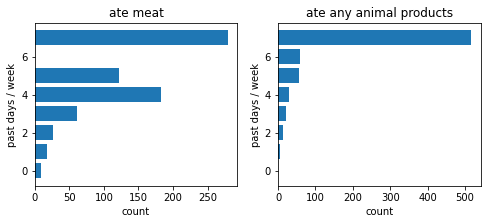

In [182]:
past_days_diet_df = respondent_df['Q_past_vegetarian'].value_counts().sort_index().rename('ate meat').to_frame()
past_days_diet_df.loc[6] = 0
past_days_diet_df = past_days_diet_df.sort_index()
past_days_diet_df.rename_axis('days/week')
past_days_diet_df['ate any animal products'] = respondent_df['Q_past_vegan'].value_counts().sort_index()
fig,axes = plt.subplots(1,2,figsize=(8,3))#, sharey=True)
axes[0].barh(past_days_diet_df.index, past_days_diet_df['ate meat'])
axes[1].barh(past_days_diet_df.index, past_days_diet_df['ate any animal products'])
axes[0].set_title('ate meat')
axes[1].set_title('ate any animal products')
axes[0].set_ylabel('past days / week')
axes[0].set_xlabel('count')
axes[1].set_ylabel('past days / week')
_ = axes[1].set_xlabel('count')
# past_days_diet_df

In [183]:
sample_aggregate_characteristics_df = pd.concat([
    sample_aggregate_characteristics_df,
    pd.DataFrame([
        ['Past days/week ate meet', respondent_df['Q_past_vegetarian'].mean(), respondent_df['Q_past_vegetarian'].std()],
        ['Past days/week ate any animal products', respondent_df['Q_past_vegan'].mean(), respondent_df['Q_past_vegan'].std()]
    ], columns=sample_characteristics_cols)
])

How strongly do you agree with the following statement?
"Vegan dishes are not for people like me."



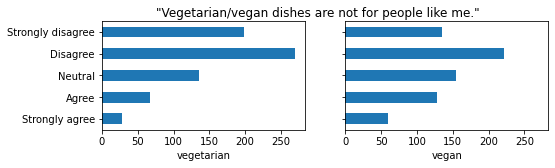

In [184]:
print('%s\n'%codebook['Q_vegan_not_me']['Q'])
fig,axes = plt.subplots(1,2,figsize=(8,2),sharey=True,sharex=True)
fig.suptitle('"Vegetarian/vegan dishes are not for people like me."')
respondent_df['Q_vegetarian_not_me'].astype(str).value_counts().sort_index().rename(
    codebook['Q_vegetarian_not_me']['choices']).plot.barh(ax=axes[0])
axes[0].set_xlabel("vegetarian")
respondent_df['Q_vegan_not_me'].astype(str).value_counts().sort_index().rename(
    codebook['Q_vegan_not_me']['choices']).plot.barh(ax=axes[1])
_ = axes[1].set_xlabel("vegan")

In [185]:
def collapse_categories_5_to_3(resp):
    """Maps 5 point scale to 3 point scale: Maps 1-2 -> 1; 3 -> 2; 3-4 -> 3"""
    if resp < 3:
        return 1
    if resp == 3:
        return 2
    return 3

reduced_agree_neutral_disagree_map = {
    1: 'Strongly agree or agree',
    2: 'Neutral',
    3: 'Disagree or strongly disagree'
}
def map_agree_neutral_disagree(resp):
    return reduced_agree_neutral_disagree_map[resp]

reduced_importance_map = {
    1: 'Not important',
    2: 'Neutral',
    3: 'Important'
}

In [186]:
vegetarian_not_me_df = (
    respondent_df['Q_vegetarian_not_me']
    .astype(int)
    .apply(collapse_categories_5_to_3)
    .apply(map_agree_neutral_disagree)
    .value_counts()
    .reindex(reduced_agree_neutral_disagree_map.values())
    .to_frame(name='count').reset_index()
    .assign(pct=lambda x: round(100*x['count']/N, 2))
)
vegetarian_not_me_df.columns = sample_characteristics_cols
vegetarian_not_me_df

,characteristic,count or mean,(%) or (std)
0,Strongly agree or agree,95,13.61
1,Neutral,135,19.34
2,Disagree or strongly disagree,468,67.05


In [187]:
vegan_not_me_df = (
    respondent_df['Q_vegan_not_me']
    .astype(int)
    .apply(collapse_categories_5_to_3)
    .apply(map_agree_neutral_disagree)
    .value_counts()
    .reindex(reduced_agree_neutral_disagree_map.values())
    .to_frame(name='count').reset_index()
    .assign(pct=lambda x: round(100*x['count']/N, 2))
)
vegan_not_me_df.columns = sample_characteristics_cols
vegan_not_me_df

,characteristic,count or mean,(%) or (std)
0,Strongly agree or agree,188,26.93
1,Neutral,154,22.06
2,Disagree or strongly disagree,356,51.00


In [188]:
sample_aggregate_characteristics_df = pd.concat([
    sample_aggregate_characteristics_df,
    pd.DataFrame([['"Vegetarian dishes are not for people like me."', '','']], columns=sample_characteristics_cols),
    vegetarian_not_me_df,
    pd.DataFrame([['"Vegan dishes are not for people like me."', '','']], columns=sample_characteristics_cols),
    vegan_not_me_df,
])

How strongly do you agree with the following statement?
"Vegetarian and vegan dishes are good for the environment."

Strongly agree       151
Agree                325
Neutral              197
Disagree              17
Strongly disagree      8
Name: Q_good_for_env, dtype: int64


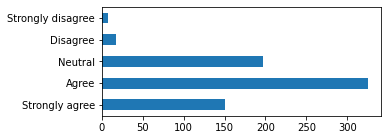

In [189]:
print('%s\n'%codebook['Q_good_for_env']['Q'])
fig,ax = plt.subplots(figsize=(5,2))
respondent_df['Q_good_for_env'].astype(str).value_counts().sort_index().rename(codebook['Q_good_for_env']['choices']).plot.barh(ax=ax)
print(respondent_df['Q_good_for_env'].astype(str).value_counts().sort_index().rename(codebook['Q_good_for_env']['choices']))

How important is environmental sustainability to you as an issue?
Very much not important     21
Not important               37
Neutral                     71
Somewhat important         319
Very important             250
Name: Q_how_important_env, dtype: int64


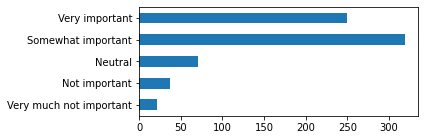

In [190]:
print(codebook['Q_how_important_env']['Q'])
fig,ax = plt.subplots(figsize=(5,2))
respondent_df['Q_how_important_env'].astype(str).value_counts().sort_index().rename(codebook['Q_how_important_env']['choices']).plot.barh(ax=ax)
print(respondent_df['Q_how_important_env'].astype(str).value_counts().sort_index().rename(codebook['Q_how_important_env']['choices']))

In [191]:
sample_aggregate_characteristics_df['(%) or (std)'] = (
    sample_aggregate_characteristics_df['(%) or (std)']
    .apply(lambda x: round(x,2) if x != '' else x)
)
sample_aggregate_characteristics_df['count or mean'] = (
    sample_aggregate_characteristics_df['count or mean']
    .apply(lambda x: round(x,2) if x != '' else x)
)
sample_aggregate_characteristics_df

,characteristic,count or mean,(%) or (std)
0,Male,303,43.41
0,Age,,
0,18 - 24 years old,168,24.07
1,25 - 34 years old,254,36.39
2,35 - 44 years old,127,18.19
3,45 - 54 years old,72,10.32
4,55 - 64 years old,45,6.45
5,65+ years old,32,4.58
0,Household income,,
0,"Less than \$25,000",82,11.75


More correlations between covariates

In [192]:
def styled_boxplot(df, by, column=None, ax=None):
    df.boxplot(
        column=column,
        by=by, ax=ax,
        grid=False,
        vert=False,
        showmeans=True,
        meanprops=dict(marker='D', markeredgecolor='black', markerfacecolor='firebrick'),
        boxprops=dict(linestyle='-', linewidth=1.5),
        flierprops=dict(linestyle='-', linewidth=1.5),
        medianprops=dict(linestyle='-', linewidth=2, color='firebrick'),
        whiskerprops=dict(linestyle='-', linewidth=1.5),
        #capprops=dict(linestyle='-', linewidth=1.5),
        showfliers=False,
        rot=0
    ).get_figure().suptitle('') # remove title automatically added by pandas

/Users/aberke/projects/ff/venv-ff/lib/python3.7/site-packages/ipykernel_launcher.py:27: UserWarning: FixedFormatter should only be used together with FixedLocator


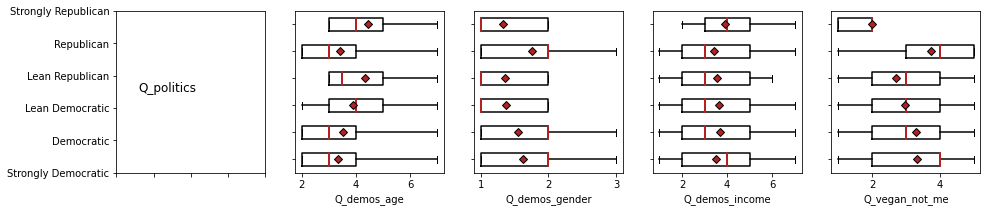

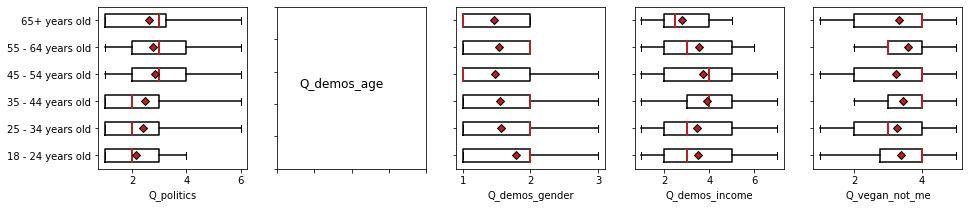

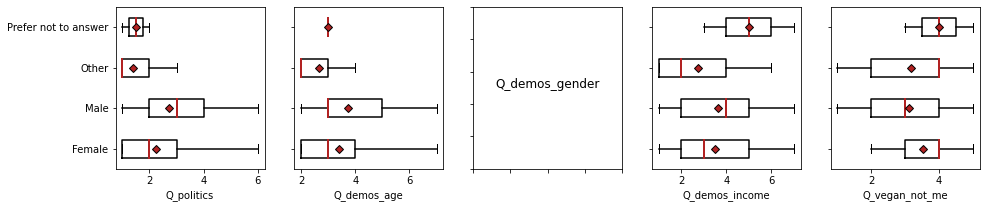

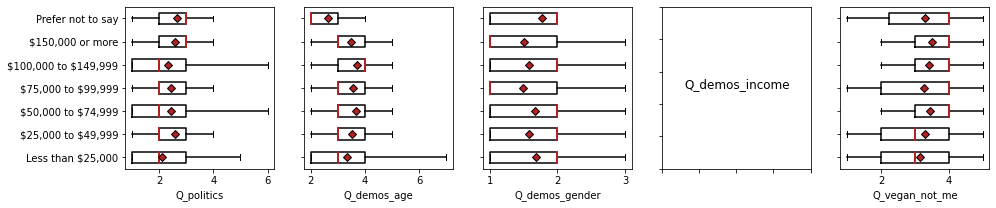

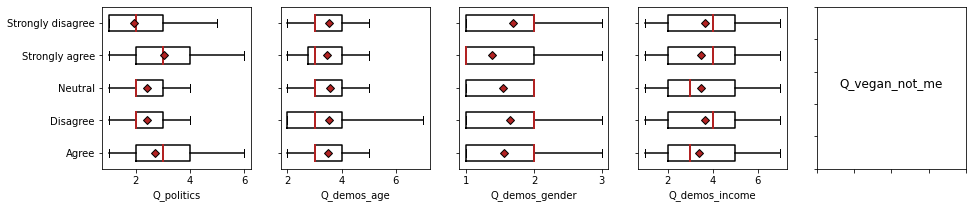

In [193]:
# Covariates correlations
cc_list = [
    'Q_politics', 
    'Q_demos_age', 
    'Q_demos_gender', 
    'Q_demos_income',
    'Q_vegan_not_me',
    
]
# make a df for analysis
df = respondent_df[cc_list].copy().astype(str)


alt_map = ['Q_demos_income']
n_ccs = len(cc_list)


for i in range(n_ccs):
    fig, axes = plt.subplots(1,n_ccs, figsize=(3*n_ccs,3),
                             facecolor='w', edgecolor='k')
    for j in range(n_ccs):
        ax = axes[j]
        cc_i = cc_list[i]
        cc_j = cc_list[j]
        if i == j:
            if i == 0:
                ax.set_yticklabels(list(codebook[cc_i]['choices'].values()))
            else:
                ax.set_yticklabels([])
            ax.text(0.15, 0.5, cc_i, fontsize = 12)
            ax.set_xticklabels([])
            continue
        rdf = df[[cc_i, cc_j]].copy()
        if cc_i not in alt_map:
            rdf[cc_i] = rdf[cc_i].map(codebook[cc_i]['choices'])
        rdf[cc_j] = rdf[cc_j].astype(float)
        styled_boxplot(rdf, by=cc_i, column=cc_j, ax=ax)
        if j > 0:
            ax.set_yticklabels([])
        if (cc_i in alt_map) and (j==0):
            ax.set_yticklabels(codebook[cc_i]['choices'].values())
        ax.set_xlabel(cc_j)
        ax.set_title('')
        # ax.set_title('%s' % (cc_j))

### Menu choices table

```
ResponseId, labeled (0/1), QID, choice_type (1-5), choice (1,2) 
```

In [194]:
# choices_df excludes vegetarian/vegan respondents.
# veg_choices_df only includes them.

# Wide data
choices_wide_df = survey_df[['ResponseId'] + choice_Qs]
# Drop data from respondents who failed attention checks or are veg
choices_wide_df = choices_wide_df[
    (choices_wide_df.ResponseId.isin(respondent_df['ResponseId']))
]
choices_wide_df.head(3)
assert(len(respondent_df) == len(choices_wide_df))

In [195]:
# Create a separate dataframe for respondents who are veg
# Start wide wide data
veg_choices_wide_df = survey_df[['ResponseId'] + choice_Qs]
# Drop data from respondents who failed attention; keep only veg
veg_choices_wide_df = veg_choices_wide_df[
    (veg_choices_wide_df.ResponseId.isin(veg_respondent_df['ResponseId']))
]
assert(len(veg_respondent_df) == len(veg_choices_wide_df))

In [196]:
def transform_choices_data(wide_df):
    # Transform from wide to long data
    choices_df = pd.melt(wide_df, id_vars=['ResponseId'], value_vars=choice_Qs, 
                 var_name='QID', value_name='choice')
    # Add Q data
    # ResponseId, labeled (0/1), QID, choice_type (1-5), choice (1/0)
    # code choice, choice_type, labeled as numeric
    choices_df['choice_type'] = choices_df['QID'].apply(lambda QID: int(QID.split('_')[2]))
    choices_df['labeled'] = choices_df['QID'].apply(lambda QID: 1 if len(QID.split('_')) > 3 and QID.split('_')[3] == 'labeled' else 0)
    # only keep responses for answered questions
    # this should equal half of the total questions
    assert(0.5 == len(choices_df.dropna())/len(choices_df))
    choices_df = choices_df.dropna()
    choices_df['choice'] = choices_df['choice'].astype(int)
    return choices_df

In [197]:
choices_df = transform_choices_data(choices_wide_df)
choices_df.head()

,ResponseId,QID,choice,choice_type,labeled
1,R_23V4Eyckqxl6Bmy,Q_sandwich_1,0,1,0
3,R_2B97XuOwuxSeQWA,Q_sandwich_1,0,1,0
5,R_1DBZC4pjzVDsgT6,Q_sandwich_1,0,1,0
8,R_2SdGAfdbJx8Aq5C,Q_sandwich_1,0,1,0
11,R_2xL9vHDm0KfOgCa,Q_sandwich_1,0,1,0


In [198]:
# transform to long data
veg_choices_df = transform_choices_data(veg_choices_wide_df)
assert(len(veg_choices_df) == len(veg_respondent_df) * 5) # 5 Qs per respondent
veg_choices_df.head(3)

,ResponseId,QID,choice,choice_type,labeled
1,R_db759QXvWIY4clr,Q_sandwich_1,1,1,0
8,R_1erxzxxDxVFbdhm,Q_sandwich_1,1,1,0
10,R_1rjfMCE36BveJbP,Q_sandwich_1,1,1,0


Choices data

In [199]:
choices_type_names_dict = {
    1:'1=(labeled) vegetarian vs 0=meat',
    2:'1=(labeled) vegan vs 0=meat',
    3:'1=(labeled) vegetarian vs 0=vegetarian',
    4:'1=(labeled) vegan vs 0=vegan',
    5:'1=(labeled) vegan vs 0=vegetarian',
}

Add in information about choice attributes

In [200]:
# code whether choice has meat
choices_df['option_w_meat'] = choices_df['choice_type'].apply(lambda c: 1 if c in [1,2] else 0)
choices_df['choice_vegetarian'] = choices_df['choice_type'].apply(lambda c: 1 if c in [1,3] else 0)
choices_df['choice_vegan'] = choices_df['choice_type'].apply(lambda c: 1 if c in [2,4,5] else 0)

In [201]:
choices_df.head()

,ResponseId,QID,choice,choice_type,labeled,option_w_meat,choice_vegetarian,choice_vegan
1,R_23V4Eyckqxl6Bmy,Q_sandwich_1,0,1,0,1,1,0
3,R_2B97XuOwuxSeQWA,Q_sandwich_1,0,1,0,1,1,0
5,R_1DBZC4pjzVDsgT6,Q_sandwich_1,0,1,0,1,1,0
8,R_2SdGAfdbJx8Aq5C,Q_sandwich_1,0,1,0,1,1,0
11,R_2xL9vHDm0KfOgCa,Q_sandwich_1,0,1,0,1,1,0


### Respondent level variables

gender

In [202]:
# Coding male as Male: 1; Otherwise: 0
choices_df['male'] = choices_df['ResponseId'].map(
    respondent_df.set_index('ResponseId')['gender']
).apply(lambda g: 1 if g=='Male' else 0)

Other basic demographics to control for

In [203]:
choices_df['age'] = choices_df.ResponseId.map(
    respondent_df.set_index('ResponseId')['Q_demos_age']).astype(str)
choices_df['income'] = choices_df.ResponseId.map(
    respondent_df.set_index('ResponseId')['Q_demos_income']).astype(str)

Hunger

In [204]:
choices_df['current_hunger'] = choices_df.ResponseId.map(
    respondent_df.set_index('ResponseId')['Q_current_hunger']
)

"vegan / vegetarian dishes not for people like me"

Binary coded as 1 if they strongly agree (1) or agree (2)

In [205]:
codebook['Q_vegan_not_me']['choices']

{'1': 'Strongly agree',
 '2': 'Agree',
 '3': 'Neutral',
 '4': 'Disagree',
 '5': 'Strongly disagree'}

In [206]:
choices_df['vegetarian_not_me'] = choices_df['ResponseId'].map(
    respondent_df.set_index('ResponseId')['Q_vegetarian_not_me'].astype(int)
).apply(lambda r: 1 if r < 3 else 0)
choices_df['vegan_not_me'] = choices_df['ResponseId'].map(
    respondent_df.set_index('ResponseId')['Q_vegan_not_me'].astype(int)
).apply(lambda r: 1 if r < 3 else 0)

Binary code whether they say agree the environment is important.

1: important or very important; 0: neutral or not important or very much not important

In [207]:
# code as 0: not important or neutral; 1: important
print(codebook['Q_how_important_env']['Q'])
print(codebook['Q_how_important_env']['choices'])
choices_df['env_is_important'] = choices_df['ResponseId'].map(
    respondent_df.set_index('ResponseId')['Q_how_important_env'].astype(int)
).apply(lambda r: 0 if r < 4 else 1)

How important is environmental sustainability to you as an issue?
{'1': 'Very much not important', '2': 'Not important', '3': 'Neutral', '4': 'Somewhat important', '5': 'Very important'}


Binary code for whether respondents agree vegetarian/vegan dishes are good for the environment.

1: agree or strongly agree; 0: neutral or disagree or strongly disagree

In [208]:
# code veg_good_for_env as 0: disagree or neutral; 1: agree
print('%s'%codebook['Q_good_for_env']['Q'])
print(codebook['Q_good_for_env']['choices'])
choices_df['veg_good_for_env'] = choices_df['ResponseId'].map(
    respondent_df.set_index('ResponseId')['Q_good_for_env'].astype(int)
).apply(lambda r: 1 if r < 3 else 0)

How strongly do you agree with the following statement?
"Vegetarian and vegan dishes are good for the environment."
{'1': 'Strongly agree', '2': 'Agree', '3': 'Neutral', '4': 'Disagree', '5': 'Strongly disagree'}


Priorities

In [209]:
print(codebook['Q_priorities']['Q'])
print(codebook['Q_priorities']['choices'])
print('1 is top priority')

How do you prioritize the following when choosing what to order for yourself off a menu?
{'1': 'health', '2': 'cost', '3': 'taste', '4': 'filling', '5': 'usual_choice'}
1 is top priority


Priority values are flipped and recentered on a -2, -1, 0, 1, 2, 3 scale; higher value indicates higher priority.

e.g. 1 -> 2; 2 --> 1; 3 --> 0; 4--> -1; 5 --> -2

In [210]:
# put in column to choices df as priority_pname;
for pkey, pname in codebook['Q_priorities']['choices'].items():
    # recoded as (3 - value) so that higher value means higher priority; priority=3: 0
    choices_df['priority_%s'%pname] = choices_df['ResponseId'].map(
        3 - respondent_df.set_index('ResponseId')['Q_priorities_%s'%pkey]
    )

For each priority: add in boolean indicating whether it is the top 1 priority.
(Also previously tested with whether was in top 2 priorities and was not
interesting.)

In [211]:
for pkey, pname in codebook['Q_priorities']['choices'].items():
    choices_df['top_1_priority_%s'%pname] = choices_df['ResponseId'].map(
        respondent_df.set_index('ResponseId')['Q_priorities_%s'%pkey]
    ).apply(lambda p: 1 if p == 1 else 0)

Related works have found that past behavior w.r.t days eating meat has an impact on vegetarian choices.

Encode the number of past days/week respondent ate meat.

Note that the Q name is reversed -- it asked for number of past days eating meat or fish.

In [212]:
choices_df['past_days_ate_meat'] = choices_df['ResponseId'].map(
        respondent_df.set_index('ResponseId')['Q_past_vegetarian'].astype(int))

# boolean indicating whether they ate meat 7 days/week
choices_df['ate_meat_7days'] = choices_df['past_days_ate_meat'].apply(lambda d: 1 if d==7 else 0)
print('%0.2f%% ate meat 7 days' % (100*choices_df['ate_meat_7days'].sum()/len(choices_df)))
print('past days/week ate meat')
print(choices_df['past_days_ate_meat'].describe().apply(round, args=([3])))

39.97% ate meat 7 days
past days/week ate meat
count    3490.000
mean        5.080
std         1.813
min         0.000
25%         4.000
50%         5.000
75%         7.000
max         7.000
Name: past_days_ate_meat, dtype: float64


Related works have excluded pescatarians from the main analyses. 
Binary code whether respondent is pescatarian to explore exclusion.

In [213]:
choices_df['is_pescatarian'] = choices_df['ResponseId'].map(
        respondent_df.set_index('ResponseId')['is_pescatarian'].astype(int))

In [214]:
choices_df.head(4)

,ResponseId,QID,choice,choice_type,labeled,option_w_meat,choice_vegetarian,choice_vegan,male,age,...,priority_filling,priority_usual_choice,top_1_priority_health,top_1_priority_cost,top_1_priority_taste,top_1_priority_filling,top_1_priority_usual_choice,past_days_ate_meat,ate_meat_7days,is_pescatarian
1,R_23V4Eyckqxl6Bmy,Q_sandwich_1,0,1,0,1,1,0,1,7,...,-2,-1,0,0,1,0,0,4,0,0
3,R_2B97XuOwuxSeQWA,Q_sandwich_1,0,1,0,1,1,0,1,4,...,-1,-2,0,1,0,0,0,3,0,0
5,R_1DBZC4pjzVDsgT6,Q_sandwich_1,0,1,0,1,1,0,1,5,...,-2,1,0,0,1,0,0,4,0,0
8,R_2SdGAfdbJx8Aq5C,Q_sandwich_1,0,1,0,1,1,0,1,5,...,-1,0,1,0,0,0,0,7,1,0


##### Veg choices data

For the vegetarian choices data, add in who is vegan vs vegetarian so that can properly test choice type 5.

In [215]:
for is_v in ['is_vegetarian', 'is_vegan']:
    veg_choices_df[is_v] = veg_choices_df.ResponseId.map(veg_respondent_df.set_index('ResponseId')[is_v])
veg_choices_df.head(3)

,ResponseId,QID,choice,choice_type,labeled,is_vegetarian,is_vegan
1,R_db759QXvWIY4clr,Q_sandwich_1,1,1,0,1,0
8,R_1erxzxxDxVFbdhm,Q_sandwich_1,1,1,0,1,1
10,R_1rjfMCE36BveJbP,Q_sandwich_1,1,1,0,1,0


## Analysis

### Plots and Chi-Square tests and odds ratios

In [216]:
# https://zepid.readthedocs.io/en/latest/Reference/generated/zepid.base.OddsRatio.html
from zepid import OddsRatio

In [217]:
# For plotting
plot_choices_type_names_dict = {
    1:'(1) vegetarian vs (2) meat',
    2:'(1) vegan vs (2) meat',
    3:'(1) vegetarian vs (2) vegetarian',
    4:'(1) vegan vs (2) vegan',
    5:'(1) vegan vs (2) vegetarian',
}

In [218]:
def make_contingency_df(df):
    """
    Make tables like:
    ```
    choice, labeled, unlabeled, (%) labeled, (%) unlabeled, expected (based on unlabeled)
    0    A           B
    1    C           D
    total
    ```
    """
    contingency_df = pd.DataFrame({
        'labeled': df[df['labeled']==1]['choice'].value_counts(),
        'unlabeled': df[df['labeled']==0]['choice'].value_counts(),
    }, index=[0, 1]).rename_axis('choice').fillna(0)
    contingency_df.loc['total'] = [contingency_df[c].sum() for c in contingency_df.columns]
    for l in ['labeled', 'unlabeled']:
        contingency_df['fraction %s'%l] = contingency_df[l]/contingency_df[l]['total']
        contingency_df['%% %s'%l] = round(100*contingency_df['fraction %s'%l],2)
    contingency_df['expected'] = (
        contingency_df['labeled']['total'] * contingency_df['fraction unlabeled']
    )
    return contingency_df.drop(['fraction labeled','fraction unlabeled'],axis=1)

In [219]:
choices_all_contingency_df = make_contingency_df(choices_df)
choices_all_contingency_df

,labeled,unlabeled,% labeled,% unlabeled,expected
choice,,,,,
0,1145,1121,66.57,63.33,1089.333333
1,575,649,33.43,36.67,630.666667
total,1720,1770,100.00,100.00,1720.000000


In [220]:
def plot_contingency_table(df, ax, legend_labels=['option 2','(v) option 1'], ylabel=True, legend=True):
    n_labels_values = df.loc['total'][['labeled', 'unlabeled']]
    labels = ['%s\n(n=%s)'%(l, int(n)) for l, n in n_labels_values.iteritems()]
    #labels = ['labeled', 'unlabeled'] # a simpler labeling
    option1_values = df[['% labeled', '% unlabeled']].loc[1]
    option2_values = df[['% labeled', '% unlabeled']].loc[0]

    x = np.arange(len(labels))  # the label locations
    width = 0.45  # the width of the bars
    rects1 = ax.bar(x - width/2, option1_values, width, 
                    linewidth=1, edgecolor='black',
                    color='lightgray', label=legend_labels[1])
    rects2 = ax.bar(x + width/2, option2_values, width, 
                    linewidth=1, edgecolor='black',
                    color='white', label=legend_labels[0])
    ax.set_ylim(0, 108)
    if ylabel: ax.set_ylabel('% chosen')
    ax.set_xticks(x, labels)
    option1_labels = ['%0.1f%%'%v for v in round(option1_values, 1)]
    option2_labels = ['%0.1f%%'%v for v in round(option2_values, 1)]
    ax.bar_label(rects1, option1_labels, padding=3)
    ax.bar_label(rects2, option2_labels, padding=3)
    if legend: ax.legend()

In [221]:
def print_OR(choices_df, plot=False):
    ort = OddsRatio()
    ort.fit(choices_df, exposure='labeled',outcome='choice')
    if plot:
        fig,ax = plt.subplots(figsize=(2,1))
        _ = ort.plot()
    print(ort.summary())

Odds ratio:
Comparison:0 to 1
+-----+-------+-------+
|     |   D=1 |   D=0 |
+=====+=======+=======+
| E=1 |   575 |  1145 |
+-----+-------+-------+
| E=0 |   649 |  1121 |
+-----+-------+-------+ 

                           Odds Ratio                                 
       OddsRatio  SD(OR)  OR_LCL  OR_UCL
Ref:0      1.000     NaN     NaN     NaN
1          0.867   0.071   0.755   0.997
----------------------------------------------------------------------
Missing E:    0
Missing D:    0
Missing E&D:  0
None


N=3490; chisq = 7.758; p=0.005


,labeled,unlabeled,% labeled,% unlabeled,expected
choice,,,,,
0,1145,1121,66.57,63.33,1089.333333
1,575,649,33.43,36.67,630.666667
total,1720,1770,100.00,100.00,1720.000000


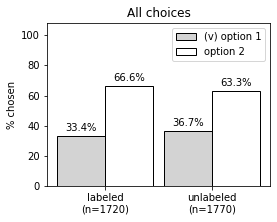

In [222]:
print('Odds ratio:')
print_OR(choices_df)
figsize=(4,3)
fig,ax = plt.subplots(figsize=figsize)
plot_contingency_table(choices_all_contingency_df, ax)
chisq, p = scipy.stats.chisquare(
    choices_all_contingency_df['labeled'].drop('total'),
    choices_all_contingency_df['expected'].drop('total'), 
)
print('\n\nN=%s; chisq = %0.3f; p=%0.3f' % (len(choices_df),chisq,p))
ax.set_title('All choices')
choices_all_contingency_df

Plot choice 5 only

Odds ratio:
Comparison:0 to 1
+-----+-------+-------+
|     |   D=1 |   D=0 |
+=====+=======+=======+
| E=1 |   127 |   217 |
+-----+-------+-------+
| E=0 |   151 |   203 |
+-----+-------+-------+ 

                           Odds Ratio                                 
       OddsRatio  SD(OR)  OR_LCL  OR_UCL
Ref:0      1.000     NaN     NaN     NaN
1          0.787   0.155   0.581   1.066
----------------------------------------------------------------------
Missing E:    0
Missing D:    0
Missing E&D:  0
None


N=698; chisq = 4.628; p=0.031


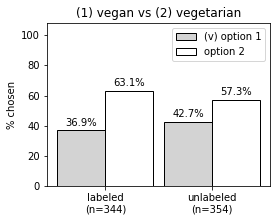

,labeled,unlabeled,% labeled,% unlabeled,expected
choice,,,,,
0,217,203,63.08,57.34,197.265537
1,127,151,36.92,42.66,146.734463
total,344,354,100.00,100.00,344.000000


In [223]:
c5df = choices_df[choices_df['choice_type']==5]
print('Odds ratio:')
print_OR(c5df)

c5_contingency_df = make_contingency_df(c5df)
chisq, p = scipy.stats.chisquare(
    c5_contingency_df['labeled'].drop('total'), 
    c5_contingency_df['expected'].drop('total'),
)
fig,ax = plt.subplots(figsize=figsize)
plot_contingency_table(c5_contingency_df, ax)
print('\n\nN=%s; chisq = %0.3f; p=%0.3f' % (len(c5df),chisq, p))
ax.set_title('%s'%(plot_choices_type_names_dict[5]))
plt.show()
c5_contingency_df

Plots for all choice types separately

1: (1) vegetarian vs (2) meat
chisq = 7.908; p=0.005


,labeled,unlabeled,% labeled,% unlabeled,expected
choice,,,,,
0,253,235,73.55,66.38,228.361582
1,91,119,26.45,33.62,115.638418
total,344,354,100.00,100.00,344.000000


2: (1) vegan vs (2) meat
chisq = 0.123; p=0.726


,labeled,unlabeled,% labeled,% unlabeled,expected
choice,,,,,
0,239,249,69.48,70.34,241.966102
1,105,105,30.52,29.66,102.033898
total,344,354,100.00,100.00,344.000000


3: (1) vegetarian vs (2) vegetarian
chisq = 0.378; p=0.539


,labeled,unlabeled,% labeled,% unlabeled,expected
choice,,,,,
0,251,253,72.97,71.47,245.853107
1,93,101,27.03,28.53,98.146893
total,344,354,100.00,100.00,344.000000


4: (1) vegan vs (2) vegan
chisq = 0.966; p=0.326


,labeled,unlabeled,% labeled,% unlabeled,expected
choice,,,,,
0,185,181,53.78,51.13,175.887006
1,159,173,46.22,48.87,168.112994
total,344,354,100.00,100.00,344.000000


5: (1) vegan vs (2) vegetarian
chisq = 4.628; p=0.031


,labeled,unlabeled,% labeled,% unlabeled,expected
choice,,,,,
0,217,203,63.08,57.34,197.265537
1,127,151,36.92,42.66,146.734463
total,344,354,100.00,100.00,344.000000


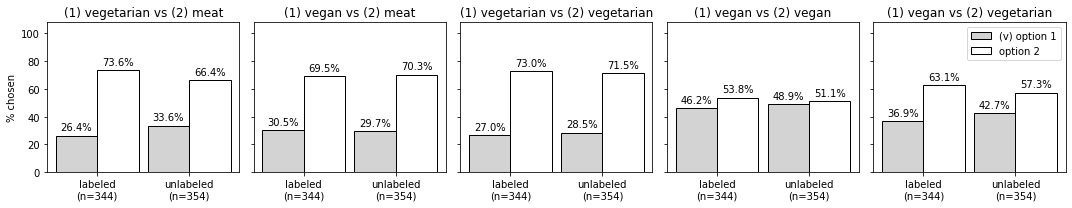

In [224]:
ncols=len(plot_choices_type_names_dict)
fig,axes = plt.subplots(
    1, ncols, figsize=(3*ncols,3),
    sharey=True,
    facecolor='white'
)
for i, (choice_type, name) in enumerate(plot_choices_type_names_dict.items()):
    print('%s: %s' % (choice_type, name))
    cdf = choices_df[choices_df['choice_type']==choice_type]
    c_contingency_df = make_contingency_df(cdf)
    chisq, p = scipy.stats.chisquare(
        c_contingency_df['labeled'].drop('total'), 
        c_contingency_df['expected'].drop('total')
    )
    print('chisq = %0.3f; p=%0.3f' % (chisq, p))
    display(c_contingency_df)
    ax = axes[i]
    ylabel = False if i > 0 else True
    legend = False if i < 4 else True
    plot_contingency_table(c_contingency_df, ax, ylabel=ylabel, legend=legend)
    ax.set_title('%s'%(name,))
fig.tight_layout()
plt.show()

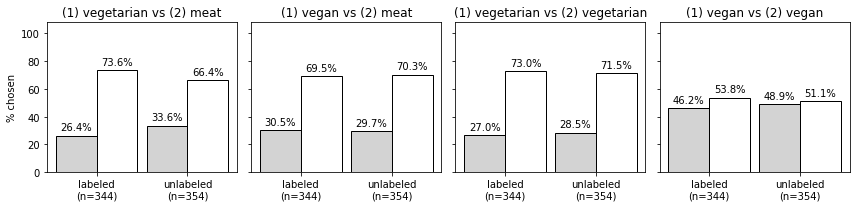

In [225]:
ncols=len(plot_choices_type_names_dict)-1
fig,axes = plt.subplots(
    1, ncols, figsize=(3*ncols,3),
    sharey=True,
    facecolor='white'
)
for i, (choice_type, name) in enumerate(plot_choices_type_names_dict.items()):
    if i >= ncols: break
    #print('%s: %s' % (choice_type, name))
    cdf = choices_df[choices_df['choice_type']==choice_type]
    c_contingency_df = make_contingency_df(cdf)
    chisq, p = scipy.stats.chisquare(
        c_contingency_df['labeled'].drop('total'), 
        c_contingency_df['expected'].drop('total')
    )
    #print('chisq = %0.3f; p=%0.3f' % (chisq, p))
    #display(c_contingency_df)
    ax = axes[i]
    ylabel = False if i > 0 else True
    legend = False if i < 4 else True
    plot_contingency_table(c_contingency_df, ax, ylabel=ylabel, legend=legend)
    ax.set_title('%s'%(name,))
fig.tight_layout()
plt.show()

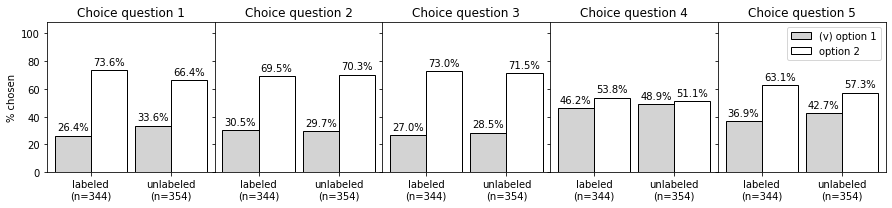

In [226]:
ncols=len(plot_choices_type_names_dict)
fig,axes = plt.subplots(
    1, ncols, figsize=(2.5*ncols,3),
    sharey=True,
    facecolor='white'
)
for i, (choice_type, name) in enumerate(plot_choices_type_names_dict.items()):
    #print('%s: %s' % (choice_type, name))
    cdf = choices_df[choices_df['choice_type']==choice_type]
    c_contingency_df = make_contingency_df(cdf)
    chisq, p = scipy.stats.chisquare(
        c_contingency_df['labeled'].drop('total'), 
        c_contingency_df['expected'].drop('total')
    )
    #print('chisq = %0.3f; p=%0.3f' % (chisq, p))
    #display(c_contingency_df)
    ax = axes[i]
    ylabel = False if i > 0 else True
    legend = False if i < 4 else True
    plot_contingency_table(c_contingency_df, ax, ylabel=ylabel, legend=legend)
    ax.set_title('Choice question %s'%(choice_type))
fig.tight_layout()
plt.subplots_adjust(wspace=0)
plt.show()

In [227]:
# by male vs non-male
male_choices_df = choices_df[choices_df['male'] == 1]
nonmale_choices_df = choices_df[choices_df['male'] < 1]

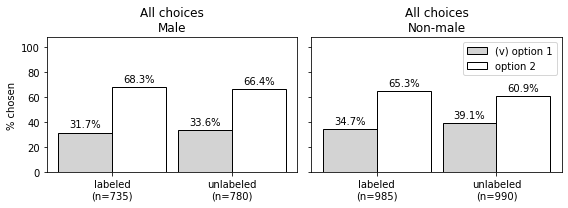

In [228]:
fig,axes = plt.subplots(1,2, figsize=(8,3), sharey=True) # do not share x because n different
plt.tight_layout()
for i, (g, df) in enumerate([('Male',male_choices_df),('Non-male',nonmale_choices_df),]):
    ax = axes[i]
    ax.set_title(g)
    contingency_df = make_contingency_df(df)
    plot_contingency_table(contingency_df, ax,
                           ylabel=(True if i==0 else False), 
                           legend=(True if i>0 else False))
    ax.set_title('%s\n%s'%('All choices', g))
fig.tight_layout()

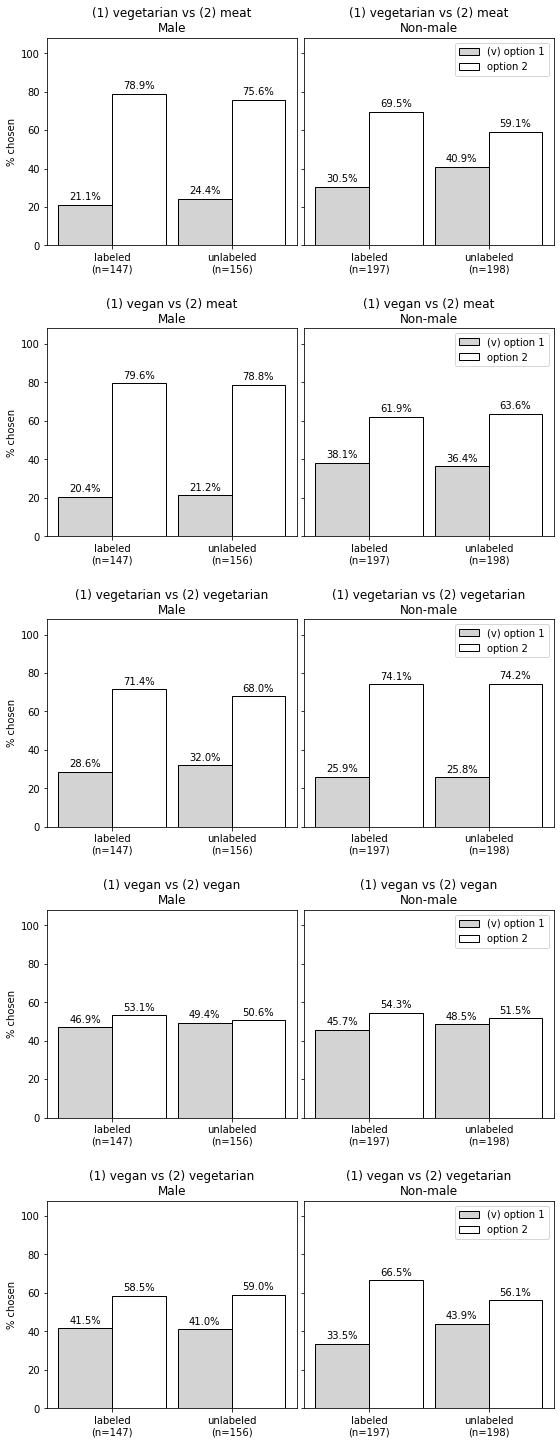

In [229]:
nrows=len(plot_choices_type_names_dict)
fig,axes = plt.subplots(
    nrows,2, figsize=(figsize[0]*2,(figsize[1]+1)*nrows), sharey=True,
    facecolor='white'
)
for i, (choice_type, name) in enumerate(plot_choices_type_names_dict.items()):
    cdf = choices_df[choices_df['choice_type']==choice_type]
    male_cdf = male_choices_df[male_choices_df['choice_type']==choice_type]
    nonmale_cdf = nonmale_choices_df[nonmale_choices_df['choice_type']==choice_type]
    #fig,axes = plt.subplots(1,2, figsize=(2*figsize[0],figsize[1]), sharey=True)#, dpi=300)
    plt.tight_layout()
    plt.subplots_adjust(hspace=0.4, wspace=0.03)
    for j, (g, df) in enumerate([('Male',male_cdf),('Non-male', nonmale_cdf),]):
        ax = axes[i][j]
        ax.set_title(g)
        contingency_df = make_contingency_df(df)
        plot_df = plot_contingency_table(
            contingency_df, ax, 
            ylabel=(True if j==0 else False), legend=(True if j>0 else False)
        )
        ax.set_title('%s\n%s'%(name, g))
plt.show()

[Exploratory] What about when pescatarians are removed from analysis?

In [230]:
non_pescatarian_choices_df = choices_df[choices_df['is_pescatarian']<1]
print('n=%s observations from non-pescatarians'%len(non_pescatarian_choices_df))

n=3390 observations from non-pescatarians


1: (1) vegetarian vs (2) meat
        labeled  unlabeled  % labeled  % unlabeled    expected
choice                                                        
0           253        234      74.85        68.82  232.623529
1            85        106      25.15        31.18  105.376471
total       338        340     100.00       100.00  338.000000
chisq = 5.725; p=0.017
2: (1) vegan vs (2) meat
        labeled  unlabeled  % labeled  % unlabeled    expected
choice                                                        
0           239        246      70.71        72.35  244.552941
1            99         94      29.29        27.65   93.447059
total       338        340     100.00       100.00  338.000000
chisq = 0.456; p=0.499
3: (1) vegetarian vs (2) vegetarian
        labeled  unlabeled  % labeled  % unlabeled    expected
choice                                                        
0           248        240      73.37        70.59  238.588235
1            90        100      26.63       

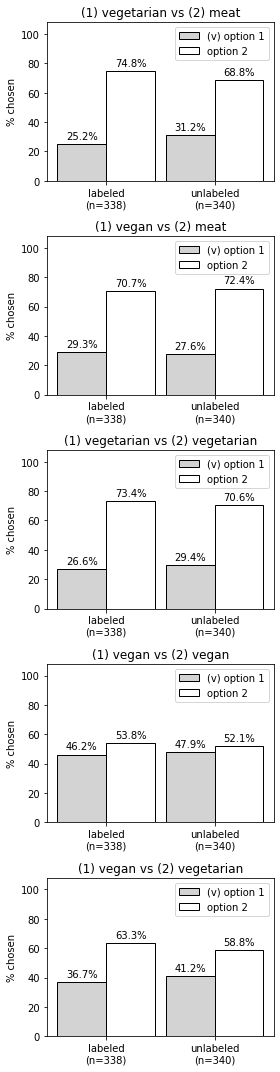

In [231]:
nrows=len(plot_choices_type_names_dict)
fig,axes = plt.subplots(
    nrows,1, figsize=(figsize[0],figsize[1]*nrows),
    facecolor='white'
)
for i, (choice_type, name) in enumerate(plot_choices_type_names_dict.items()):
    print('%s: %s' % (choice_type, name))
    cdf = non_pescatarian_choices_df[non_pescatarian_choices_df['choice_type']==choice_type]
    c_contingency_df = make_contingency_df(cdf)
    chisq, p = scipy.stats.chisquare(
        c_contingency_df['labeled'].drop('total'), 
        c_contingency_df['expected'].drop('total')
    )
    print(c_contingency_df)
    ax = axes[i]
    plot_contingency_table(c_contingency_df, ax)
    print('chisq = %0.3f; p=%0.3f' % (chisq, p))
    ax.set_title('%s'%(name,))
fig.tight_layout()
plt.show()

### Test impact of label removal on vegetarians/vegans

Does removing labels impact vegetarians and vegans?

In [123]:
veg_choices_df.head(3)

,ResponseId,QID,choice,choice_type,labeled,is_vegetarian,is_vegan
1,R_db759QXvWIY4clr,Q_sandwich_1,1,1,0,1,0
8,R_1erxzxxDxVFbdhm,Q_sandwich_1,1,1,0,1,1
10,R_1rjfMCE36BveJbP,Q_sandwich_1,1,1,0,1,0



choice question 1 : 1=(labeled) vegetarian vs 0=meat



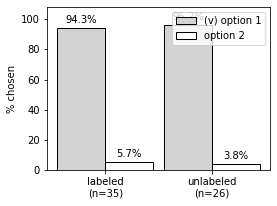

,labeled,unlabeled,% labeled,% unlabeled
choice,,,,
0,2,1,5.71,3.85
1,33,25,94.29,96.15
total,35,26,100.00,100.00



choice question 2 : 1=(labeled) vegan vs 0=meat



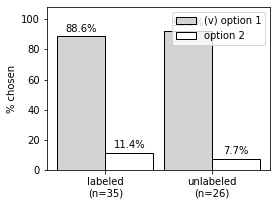

,labeled,unlabeled,% labeled,% unlabeled
choice,,,,
0,4,2,11.43,7.69
1,31,24,88.57,92.31
total,35,26,100.00,100.00


In [232]:
for choice_type in [1,2]:
    print('\nchoice question %s : %s\n' % (choice_type, choices_type_names_dict[choice_type]))
    vcdf = veg_choices_df[veg_choices_df['choice_type']==choice_type]
    vc_contingency_df = make_contingency_df(vcdf).apply(round, args=([2]))
    fig,ax = plt.subplots(figsize=(4,3))
    plot_contingency_table(vc_contingency_df, ax)
    plt.show()
    display(vc_contingency_df.drop(['expected'],axis=1))

In [233]:
choice_type = 5
print('choice question %s : %s\n' % (choice_type, choices_type_names_dict[choice_type]))
vcdf = veg_choices_df[veg_choices_df['choice_type']==choice_type]
vcdf = vcdf[vcdf['is_vegan']>0]
vc_contingency_df = make_contingency_df(vcdf).apply(round, args=([2]))
vc_contingency_df.drop(['expected'], axis=1)

choice question 5 : 1=(labeled) vegan vs 0=vegetarian



,labeled,unlabeled,% labeled,% unlabeled
choice,,,,
0,0.0,1.0,0.0,14.29
1,6.0,6.0,100.0,85.71
total,6.0,7.0,100.0,100.00


1 of 7 vegans in the unlabeled group chose vegetarian instead of vegan.

0 of 6 vegans in the labeled group chose vegetarian instead of vegan.

A chi-squared test does not find this statistically significant.

In [234]:
chisq, p = scipy.stats.chisquare(
    vc_contingency_df['labeled'].drop('total'), 
    vc_contingency_df['expected'].drop('total')
)
print('chisq=%0.3f; p=%0.3f'%(chisq,p))

chisq=1.004; p=0.316


### Logistic Regressions


Just choice type 5 to double check this makes sense.
i.e. the OR matches above. It does.

In [235]:
eq = "choice ~ labeled"
choice_type_model = smf.logit(eq, data=c5df).fit()
display(choice_type_model.summary2())
choice_type_model_odds = pd.DataFrame(np.exp(choice_type_model.params), columns=['OR'])
choice_type_model_odds['z-value'] = choice_type_model.pvalues
choice_type_model_odds[['2.5%', '97.5%']] = np.exp(choice_type_model.conf_int())
print(choice_type_model_odds)

Optimization terminated successfully.
         Current function value: 0.670591
         Iterations 4


<class 'statsmodels.iolib.summary2.Summary'>
"""
                        Results: Logit
===============================================================
Model:              Logit            Pseudo R-squared: 0.003   
Dependent Variable: choice           AIC:              940.1446
Date:               2022-09-05 09:03 BIC:              949.2410
No. Observations:   698              Log-Likelihood:   -468.07 
Df Model:           1                LL-Null:          -469.27 
Df Residuals:       696              LLR p-value:      0.12149 
Converged:          1.0000           Scale:            1.0000  
No. Iterations:     4.0000                                     
----------------------------------------------------------------
             Coef.   Std.Err.     z     P>|z|    [0.025   0.975]
----------------------------------------------------------------
Intercept   -0.2959    0.1075  -2.7537  0.0059  -0.5066  -0.0853
labeled     -0.2398    0.1550  -1.5468  0.1219  -0.5436   0.0640
===============================================================

"""

                 OR   z-value      2.5%     97.5%
Intercept  0.743842  0.005892  0.602569  0.918237
labeled    0.786798  0.121911  0.580645  1.066143


In [236]:
# displaying / printing helpers
def get_predictors_table(model):
    return pd.DataFrame({
        'B (log odds)': model.params.apply(round, args=([3])),
        'Odds Ratio': np.exp(model.params).apply(round, args=([3])), 
        '95% CI for Odds Ratio': (
            np.exp(model.conf_int())
            .apply(lambda r: '[%0.3f, %0.3f]'%(r[0], r[1]), axis=1)
        ),
        'P-value': model.pvalues.apply(round, args=([3]))
    }).rename_axis('Predictor')

In [237]:
display(get_predictors_table(choice_type_model))

,B (log odds),Odds Ratio,95% CI for Odds Ratio,P-value
Predictor,,,,
Intercept,-0.296,0.744,"[0.603, 0.918]",0.006
labeled,-0.240,0.787,"[0.581, 1.066]",0.122


For all choice types

In [238]:
for choice_type, name in choices_type_names_dict.items():
    print('%s: %s' % (choice_type, name))
    eq = "choice ~ labeled + male + labeled:male"
    cdf = choices_df[choices_df['choice_type']==choice_type]
    model = smf.logit(eq, data=cdf).fit()
    display(model.summary2())
    model_odds = display(get_predictors_table(model))

1: 1=(labeled) vegetarian vs 0=meat
Optimization terminated successfully.
         Current function value: 0.597962
         Iterations 5


<class 'statsmodels.iolib.summary2.Summary'>
"""
                         Results: Logit
=================================================================
Model:              Logit            Pseudo R-squared: 0.022     
Dependent Variable: choice           AIC:              842.7544  
Date:               2022-09-05 09:03 BIC:              860.9473  
No. Observations:   698              Log-Likelihood:   -417.38   
Df Model:           3                LL-Null:          -426.89   
Df Residuals:       694              LLR p-value:      0.00026998
Converged:          1.0000           Scale:            1.0000    
No. Iterations:     5.0000                                       
------------------------------------------------------------------
               Coef.   Std.Err.     z     P>|z|    [0.025   0.975]
------------------------------------------------------------------
Intercept     -0.3677    0.1445  -2.5441  0.0110  -0.6510  -0.0844
labeled       -0.4579    0.2118  -2.1620  0.0306  -0.8730  -0.0428
male          -0.7654    0.2360  -3.2435  0.0012  -1.2279  -0.3029
labeled:male   0.2714    0.3472   0.7818  0.4344  -0.4090   0.9518
=================================================================

"""

,B (log odds),Odds Ratio,95% CI for Odds Ratio,P-value
Predictor,,,,
Intercept,-0.368,0.692,"[0.522, 0.919]",0.011
labeled,-0.458,0.633,"[0.418, 0.958]",0.031
male,-0.765,0.465,"[0.293, 0.739]",0.001
labeled:male,0.271,1.312,"[0.664, 2.590]",0.434


2: 1=(labeled) vegan vs 0=meat
Optimization terminated successfully.
         Current function value: 0.595346
         Iterations 5


<class 'statsmodels.iolib.summary2.Summary'>
"""
                         Results: Logit
=================================================================
Model:              Logit            Pseudo R-squared: 0.027     
Dependent Variable: choice           AIC:              839.1036  
Date:               2022-09-05 09:03 BIC:              857.2964  
No. Observations:   698              Log-Likelihood:   -415.55   
Df Model:           3                LL-Null:          -426.89   
Df Residuals:       694              LLR p-value:      4.7146e-05
Converged:          1.0000           Scale:            1.0000    
No. Iterations:     5.0000                                       
------------------------------------------------------------------
               Coef.   Std.Err.     z     P>|z|    [0.025   0.975]
------------------------------------------------------------------
Intercept     -0.5596    0.1477  -3.7880  0.0002  -0.8492  -0.2701
labeled        0.0731    0.2082   0.3510  0.7256  -0.3350   0.4812
male          -0.7561    0.2455  -3.0800  0.0021  -1.2372  -0.2749
labeled:male  -0.1184    0.3517  -0.3366  0.7364  -0.8076   0.5709
=================================================================

"""

,B (log odds),Odds Ratio,95% CI for Odds Ratio,P-value
Predictor,,,,
Intercept,-0.560,0.571,"[0.428, 0.763]",0.000
labeled,0.073,1.076,"[0.715, 1.618]",0.726
male,-0.756,0.470,"[0.290, 0.760]",0.002
labeled:male,-0.118,0.888,"[0.446, 1.770]",0.736


3: 1=(labeled) vegetarian vs 0=vegetarian
Optimization terminated successfully.
         Current function value: 0.589426
         Iterations 5


<class 'statsmodels.iolib.summary2.Summary'>
"""
                        Results: Logit
===============================================================
Model:              Logit            Pseudo R-squared: 0.003   
Dependent Variable: choice           AIC:              830.8382
Date:               2022-09-05 09:03 BIC:              849.0311
No. Observations:   698              Log-Likelihood:   -411.42 
Df Model:           3                LL-Null:          -412.51 
Df Residuals:       694              LLR p-value:      0.53396 
Converged:          1.0000           Scale:            1.0000  
No. Iterations:     5.0000                                     
---------------------------------------------------------------
                 Coef.  Std.Err.    z    P>|z|   [0.025  0.975]
---------------------------------------------------------------
Intercept       -1.0586   0.1625 -6.5140 0.0000 -1.3771 -0.7401
labeled          0.0068   0.2299  0.0297 0.9763 -0.4438  0.4575
male             0.3072   0.2363  1.2999 0.1936 -0.1560  0.7704
labeled:male    -0.1717   0.3401 -0.5049 0.6136 -0.8382  0.4948
===============================================================

"""

,B (log odds),Odds Ratio,95% CI for Odds Ratio,P-value
Predictor,,,,
Intercept,-1.059,0.347,"[0.252, 0.477]",0.000
labeled,0.007,1.007,"[0.642, 1.580]",0.976
male,0.307,1.360,"[0.856, 2.161]",0.194
labeled:male,-0.172,0.842,"[0.432, 1.640]",0.614


4: 1=(labeled) vegan vs 0=vegan
Optimization terminated successfully.
         Current function value: 0.691551
         Iterations 3


<class 'statsmodels.iolib.summary2.Summary'>
"""
                        Results: Logit
===============================================================
Model:              Logit            Pseudo R-squared: 0.001   
Dependent Variable: choice           AIC:              973.4058
Date:               2022-09-05 09:03 BIC:              991.5987
No. Observations:   698              Log-Likelihood:   -482.70 
Df Model:           3                LL-Null:          -482.99 
Df Residuals:       694              LLR p-value:      0.90307 
Converged:          1.0000           Scale:            1.0000  
No. Iterations:     3.0000                                     
---------------------------------------------------------------
                  Coef.  Std.Err.    z    P>|z|   [0.025 0.975]
---------------------------------------------------------------
Intercept        -0.0606   0.1422 -0.4263 0.6699 -0.3393 0.2181
labeled          -0.1124   0.2017 -0.5573 0.5773 -0.5077 0.2829
male              0.0350   0.2142  0.1633 0.8702 -0.3848 0.4547
labeled:male      0.0154   0.3060  0.0504 0.9598 -0.5843 0.6152
===============================================================

"""

,B (log odds),Odds Ratio,95% CI for Odds Ratio,P-value
Predictor,,,,
Intercept,-0.061,0.941,"[0.712, 1.244]",0.670
labeled,-0.112,0.894,"[0.602, 1.327]",0.577
male,0.035,1.036,"[0.681, 1.576]",0.870
labeled:male,0.015,1.016,"[0.557, 1.850]",0.960


5: 1=(labeled) vegan vs 0=vegetarian
Optimization terminated successfully.
         Current function value: 0.668723
         Iterations 4


<class 'statsmodels.iolib.summary2.Summary'>
"""
                        Results: Logit
===============================================================
Model:              Logit            Pseudo R-squared: 0.005   
Dependent Variable: choice           AIC:              941.5379
Date:               2022-09-05 09:03 BIC:              959.7308
No. Observations:   698              Log-Likelihood:   -466.77 
Df Model:           3                LL-Null:          -469.27 
Df Residuals:       694              LLR p-value:      0.17146 
Converged:          1.0000           Scale:            1.0000  
No. Iterations:     4.0000                                     
---------------------------------------------------------------
                 Coef.  Std.Err.    z    P>|z|   [0.025  0.975]
---------------------------------------------------------------
Intercept       -0.2436   0.1432 -1.7014 0.0889 -0.5243  0.0370
labeled         -0.4419   0.2081 -2.1240 0.0337 -0.8497 -0.0341
male            -0.1193   0.2168 -0.5502 0.5822 -0.5442  0.3056
labeled:male     0.4614   0.3127  1.4752 0.1402 -0.1516  1.0743
===============================================================

"""

,B (log odds),Odds Ratio,95% CI for Odds Ratio,P-value
Predictor,,,,
Intercept,-0.244,0.784,"[0.592, 1.038]",0.089
labeled,-0.442,0.643,"[0.428, 0.966]",0.034
male,-0.119,0.888,"[0.580, 1.357]",0.582
labeled:male,0.461,1.586,"[0.859, 2.928]",0.140


In [239]:
# controlling for demographic covariates
for choice_type, name in choices_type_names_dict.items():
    print('%s: %s' % (choice_type, name))
    eq = "choice ~ labeled + male + labeled:male + age + income"
    cdf = choices_df[choices_df['choice_type']==choice_type]
    model = smf.logit(eq, data=cdf).fit()
    display(model.summary2())
    model_odds = display(get_predictors_table(model))

1: 1=(labeled) vegetarian vs 0=meat
Optimization terminated successfully.
         Current function value: 0.590297
         Iterations 5


<class 'statsmodels.iolib.summary2.Summary'>
"""
                         Results: Logit
================================================================
Model:              Logit            Pseudo R-squared: 0.035    
Dependent Variable: choice           AIC:              854.0552 
Date:               2022-09-05 09:04 BIC:              922.2785 
No. Observations:   698              Log-Likelihood:   -412.03  
Df Model:           14               LL-Null:          -426.89  
Df Residuals:       683              LLR p-value:      0.0083237
Converged:          1.0000           Scale:            1.0000   
No. Iterations:     5.0000                                      
----------------------------------------------------------------
                  Coef.  Std.Err.    z    P>|z|   [0.025  0.975]
----------------------------------------------------------------
Intercept        -0.3778   0.2929 -1.2899 0.1971 -0.9519  0.1963
age[T.3]         -0.1082   0.2249 -0.4810 0.6305 -0.5489  0.3326
age[T.4]         -0.1787   0.2673 -0.6688 0.5037 -0.7025  0.3451
age[T.5]         -0.3273   0.3297 -0.9927 0.3208 -0.9736  0.3189
age[T.6]         -0.1322   0.3782 -0.3495 0.7267 -0.8734  0.6090
age[T.7]          0.3887   0.4160  0.9344 0.3501 -0.4266  1.2041
income[T.2]      -0.0318   0.3132 -0.1014 0.9192 -0.6457  0.5821
income[T.3]       0.0618   0.3174  0.1947 0.8457 -0.5603  0.6839
income[T.4]       0.4910   0.3169  1.5493 0.1213 -0.1301  1.1121
income[T.5]      -0.2127   0.3356 -0.6337 0.5263 -0.8704  0.4451
income[T.6]       0.3679   0.3474  1.0591 0.2896 -0.3130  1.0488
income[T.7]      -0.3790   0.5334 -0.7104 0.4774 -1.4245  0.6665
labeled          -0.4131   0.2145 -1.9262 0.0541 -0.8335  0.0072
male             -0.7837   0.2420 -3.2381 0.0012 -1.2581 -0.3094
labeled:male      0.2423   0.3532  0.6861 0.4927 -0.4499  0.9346
================================================================

"""

,B (log odds),Odds Ratio,95% CI for Odds Ratio,P-value
Predictor,,,,
Intercept,-0.378,0.685,"[0.386, 1.217]",0.197
age[T.3],-0.108,0.897,"[0.578, 1.395]",0.631
age[T.4],-0.179,0.836,"[0.495, 1.412]",0.504
age[T.5],-0.327,0.721,"[0.378, 1.376]",0.321
age[T.6],-0.132,0.876,"[0.418, 1.839]",0.727
age[T.7],0.389,1.475,"[0.653, 3.334]",0.350
income[T.2],-0.032,0.969,"[0.524, 1.790]",0.919
income[T.3],0.062,1.064,"[0.571, 1.982]",0.846
income[T.4],0.491,1.634,"[0.878, 3.041]",0.121


2: 1=(labeled) vegan vs 0=meat
Optimization terminated successfully.
         Current function value: 0.581085
         Iterations 5


<class 'statsmodels.iolib.summary2.Summary'>
"""
                         Results: Logit
=================================================================
Model:              Logit            Pseudo R-squared: 0.050     
Dependent Variable: choice           AIC:              841.1943  
Date:               2022-09-05 09:04 BIC:              909.4176  
No. Observations:   698              Log-Likelihood:   -405.60   
Df Model:           14               LL-Null:          -426.89   
Df Residuals:       683              LLR p-value:      9.9732e-05
Converged:          1.0000           Scale:            1.0000    
No. Iterations:     5.0000                                       
------------------------------------------------------------------
               Coef.   Std.Err.     z     P>|z|    [0.025   0.975]
------------------------------------------------------------------
Intercept     -1.1094    0.3123  -3.5526  0.0004  -1.7214  -0.4973
age[T.3]       0.1678    0.2379   0.7054  0.4806  -0.2984   0.6340
age[T.4]       0.4240    0.2719   1.5593  0.1189  -0.1090   0.9570
age[T.5]       0.6324    0.3188   1.9833  0.0473   0.0074   1.2573
age[T.6]       1.0956    0.3624   3.0229  0.0025   0.3852   1.8059
age[T.7]       1.0574    0.4187   2.5255  0.0116   0.2368   1.8781
income[T.2]    0.3324    0.3218   1.0327  0.3017  -0.2984   0.9631
income[T.3]    0.2332    0.3276   0.7117  0.4767  -0.4090   0.8753
income[T.4]    0.3974    0.3330   1.1932  0.2328  -0.2554   1.0501
income[T.5]    0.2080    0.3377   0.6158  0.5380  -0.4539   0.8698
income[T.6]    0.3819    0.3625   1.0535  0.2921  -0.3286   1.0923
income[T.7]   -0.2592    0.5689  -0.4557  0.6486  -1.3744   0.8559
labeled        0.0914    0.2130   0.4294  0.6676  -0.3260   0.5089
male          -0.8628    0.2535  -3.4039  0.0007  -1.3596  -0.3660
labeled:male  -0.1670    0.3601  -0.4637  0.6429  -0.8728   0.5388
=================================================================

"""

,B (log odds),Odds Ratio,95% CI for Odds Ratio,P-value
Predictor,,,,
Intercept,-1.109,0.330,"[0.179, 0.608]",0.000
age[T.3],0.168,1.183,"[0.742, 1.885]",0.481
age[T.4],0.424,1.528,"[0.897, 2.604]",0.119
age[T.5],0.632,1.882,"[1.007, 3.516]",0.047
age[T.6],1.096,2.991,"[1.470, 6.085]",0.003
age[T.7],1.057,2.879,"[1.267, 6.541]",0.012
income[T.2],0.332,1.394,"[0.742, 2.620]",0.302
income[T.3],0.233,1.263,"[0.664, 2.400]",0.477
income[T.4],0.397,1.488,"[0.775, 2.858]",0.233


3: 1=(labeled) vegetarian vs 0=vegetarian
Optimization terminated successfully.
         Current function value: 0.583133
         Iterations 5


<class 'statsmodels.iolib.summary2.Summary'>
"""
                        Results: Logit
===============================================================
Model:              Logit            Pseudo R-squared: 0.013   
Dependent Variable: choice           AIC:              844.0531
Date:               2022-09-05 09:04 BIC:              912.2764
No. Observations:   698              Log-Likelihood:   -407.03 
Df Model:           14               LL-Null:          -412.51 
Df Residuals:       683              LLR p-value:      0.68801 
Converged:          1.0000           Scale:            1.0000  
No. Iterations:     5.0000                                     
---------------------------------------------------------------
                 Coef.  Std.Err.    z    P>|z|   [0.025  0.975]
---------------------------------------------------------------
Intercept       -1.1344   0.3061 -3.7066 0.0002 -1.7343 -0.5346
age[T.3]         0.3695   0.2345  1.5760 0.1150 -0.0900  0.8291
age[T.4]         0.0277   0.2831  0.0979 0.9220 -0.5272  0.5826
age[T.5]         0.0368   0.3352  0.1099 0.9125 -0.6201  0.6938
age[T.6]         0.1425   0.3894  0.3660 0.7143 -0.6206  0.9056
age[T.7]         0.9474   0.4091  2.3158 0.0206  0.1456  1.7493
income[T.2]     -0.3020   0.3156 -0.9569 0.3386 -0.9206  0.3166
income[T.3]     -0.1336   0.3184 -0.4196 0.6748 -0.7576  0.4904
income[T.4]      0.0016   0.3209  0.0051 0.9959 -0.6273  0.6306
income[T.5]     -0.1645   0.3293 -0.4996 0.6173 -0.8099  0.4809
income[T.6]     -0.0166   0.3528 -0.0470 0.9626 -0.7081  0.6750
income[T.7]      0.1224   0.4947  0.2474 0.8046 -0.8472  1.0920
labeled          0.0020   0.2323  0.0085 0.9932 -0.4534  0.4573
male             0.2514   0.2417  1.0400 0.2983 -0.2224  0.7251
labeled:male    -0.1476   0.3458 -0.4268 0.6695 -0.8253  0.5301
===============================================================

"""

,B (log odds),Odds Ratio,95% CI for Odds Ratio,P-value
Predictor,,,,
Intercept,-1.134,0.322,"[0.177, 0.586]",0.000
age[T.3],0.370,1.447,"[0.914, 2.291]",0.115
age[T.4],0.028,1.028,"[0.590, 1.791]",0.922
age[T.5],0.037,1.038,"[0.538, 2.001]",0.913
age[T.6],0.143,1.153,"[0.538, 2.474]",0.714
age[T.7],0.947,2.579,"[1.157, 5.751]",0.021
income[T.2],-0.302,0.739,"[0.398, 1.372]",0.339
income[T.3],-0.134,0.875,"[0.469, 1.633]",0.675
income[T.4],0.002,1.002,"[0.534, 1.879]",0.996


4: 1=(labeled) vegan vs 0=vegan
Optimization terminated successfully.
         Current function value: 0.687247
         Iterations 4


<class 'statsmodels.iolib.summary2.Summary'>
"""
                         Results: Logit
================================================================
Model:              Logit            Pseudo R-squared: 0.007    
Dependent Variable: choice           AIC:              989.3966 
Date:               2022-09-05 09:04 BIC:              1057.6199
No. Observations:   698              Log-Likelihood:   -479.70  
Df Model:           14               LL-Null:          -482.99  
Df Residuals:       683              LLR p-value:      0.94969  
Converged:          1.0000           Scale:            1.0000   
No. Iterations:     4.0000                                      
-----------------------------------------------------------------
               Coef.   Std.Err.     z     P>|z|    [0.025  0.975]
-----------------------------------------------------------------
Intercept     -0.2021    0.2718  -0.7434  0.4572  -0.7349  0.3307
age[T.3]      -0.0234    0.2069  -0.1130  0.9100  -0.4289  0.3821
age[T.4]       0.0687    0.2431   0.2826  0.7775  -0.4078  0.5451
age[T.5]       0.2320    0.2896   0.8011  0.4231  -0.3357  0.7997
age[T.6]       0.3874    0.3434   1.1281  0.2593  -0.2856  1.0605
age[T.7]       0.2634    0.3939   0.6687  0.5037  -0.5086  1.0353
income[T.2]    0.0692    0.2811   0.2460  0.8057  -0.4819  0.6202
income[T.3]    0.0878    0.2872   0.3056  0.7599  -0.4751  0.6506
income[T.4]   -0.0293    0.2923  -0.1001  0.9202  -0.6022  0.5436
income[T.5]    0.3699    0.2951   1.2534  0.2100  -0.2085  0.9484
income[T.6]   -0.0437    0.3199  -0.1365  0.8915  -0.6707  0.5834
income[T.7]    0.2535    0.4532   0.5595  0.5758  -0.6347  1.1418
labeled       -0.1331    0.2036  -0.6540  0.5131  -0.5321  0.2658
male           0.0145    0.2186   0.0664  0.9471  -0.4139  0.4429
labeled:male   0.0398    0.3106   0.1281  0.8981  -0.5689  0.6485
================================================================

"""

,B (log odds),Odds Ratio,95% CI for Odds Ratio,P-value
Predictor,,,,
Intercept,-0.202,0.817,"[0.480, 1.392]",0.457
age[T.3],-0.023,0.977,"[0.651, 1.465]",0.910
age[T.4],0.069,1.071,"[0.665, 1.725]",0.778
age[T.5],0.232,1.261,"[0.715, 2.225]",0.423
age[T.6],0.387,1.473,"[0.752, 2.888]",0.259
age[T.7],0.263,1.301,"[0.601, 2.816]",0.504
income[T.2],0.069,1.072,"[0.618, 1.859]",0.806
income[T.3],0.088,1.092,"[0.622, 1.917]",0.760
income[T.4],-0.029,0.971,"[0.548, 1.722]",0.920


5: 1=(labeled) vegan vs 0=vegetarian
Optimization terminated successfully.
         Current function value: 0.655661
         Iterations 5


<class 'statsmodels.iolib.summary2.Summary'>
"""
                         Results: Logit
================================================================
Model:              Logit            Pseudo R-squared: 0.025    
Dependent Variable: choice           AIC:              945.3031 
Date:               2022-09-05 09:04 BIC:              1013.5264
No. Observations:   698              Log-Likelihood:   -457.65  
Df Model:           14               LL-Null:          -469.27  
Df Residuals:       683              LLR p-value:      0.056484 
Converged:          1.0000           Scale:            1.0000   
No. Iterations:     5.0000                                      
----------------------------------------------------------------
                  Coef.  Std.Err.    z    P>|z|   [0.025  0.975]
----------------------------------------------------------------
Intercept        -0.6657   0.2871 -2.3190 0.0204 -1.2284 -0.1031
age[T.3]         -0.0463   0.2164 -0.2138 0.8307 -0.4704  0.3779
age[T.4]          0.1600   0.2511  0.6374 0.5239 -0.3321  0.6521
age[T.5]          0.5330   0.2948  1.8079 0.0706 -0.0448  1.1108
age[T.6]          0.8943   0.3501  2.5548 0.0106  0.2082  1.5804
age[T.7]          0.6070   0.3986  1.5227 0.1278 -0.1743  1.3882
income[T.2]       0.1525   0.2985  0.5108 0.6095 -0.4326  0.7376
income[T.3]       0.5403   0.3013  1.7931 0.0730 -0.0503  1.1308
income[T.4]       0.3301   0.3066  1.0766 0.2817 -0.2708  0.9309
income[T.5]       0.1820   0.3117  0.5840 0.5592 -0.4289  0.7929
income[T.6]       0.2831   0.3347  0.8460 0.3976 -0.3728  0.9390
income[T.7]       0.7124   0.4646  1.5333 0.1252 -0.1982  1.6230
labeled          -0.4553   0.2120 -2.1481 0.0317 -0.8707 -0.0399
male             -0.1353   0.2236 -0.6050 0.5452 -0.5736  0.3030
labeled:male      0.4349   0.3202  1.3582 0.1744 -0.1927  1.0625
================================================================

"""

,B (log odds),Odds Ratio,95% CI for Odds Ratio,P-value
Predictor,,,,
Intercept,-0.666,0.514,"[0.293, 0.902]",0.020
age[T.3],-0.046,0.955,"[0.625, 1.459]",0.831
age[T.4],0.160,1.174,"[0.717, 1.920]",0.524
age[T.5],0.533,1.704,"[0.956, 3.037]",0.071
age[T.6],0.894,2.446,"[1.232, 4.857]",0.011
age[T.7],0.607,1.835,"[0.840, 4.008]",0.128
income[T.2],0.152,1.165,"[0.649, 2.091]",0.610
income[T.3],0.540,1.716,"[0.951, 3.098]",0.073
income[T.4],0.330,1.391,"[0.763, 2.537]",0.282


Considering the impact of past days eating meat

In [241]:
# Considering the impact of past days eating meat
# Where past days is a continuous variable
for choice_type, name in choices_type_names_dict.items():
    print('\n%s: %s' % (choice_type, name))
    eq = "choice ~ labeled + past_days_ate_meat + past_days_ate_meat:labeled"
    cdf = choices_df[choices_df['choice_type']==choice_type]
    model = smf.logit(eq, data=cdf).fit()
    display(model.summary2())
    model_odds = display(get_predictors_table(model))


1: 1=(labeled) vegetarian vs 0=meat
Optimization terminated successfully.
         Current function value: 0.577949
         Iterations 6


<class 'statsmodels.iolib.summary2.Summary'>
"""
                              Results: Logit
==========================================================================
Model:                 Logit               Pseudo R-squared:    0.055     
Dependent Variable:    choice              AIC:                 814.8174  
Date:                  2022-09-05 09:05    BIC:                 833.0102  
No. Observations:      698                 Log-Likelihood:      -403.41   
Df Model:              3                   LL-Null:             -426.89   
Df Residuals:          694                 LLR p-value:         3.5383e-10
Converged:             1.0000              Scale:               1.0000    
No. Iterations:        6.0000                                             
--------------------------------------------------------------------------
                            Coef.  Std.Err.    z    P>|z|   [0.025  0.975]
--------------------------------------------------------------------------
Intercept                   0.6629   0.3306  2.0053 0.0449  0.0150  1.3109
labeled                    -0.0493   0.4866 -0.1014 0.9193 -1.0030  0.9044
past_days_ate_meat         -0.2664   0.0628 -4.2446 0.0000 -0.3894 -0.1434
past_days_ate_meat:labeled -0.0782   0.0967 -0.8087 0.4187 -0.2678  0.1114
==========================================================================

"""

,B (log odds),Odds Ratio,95% CI for Odds Ratio,P-value
Predictor,,,,
Intercept,0.663,1.940,"[1.015, 3.709]",0.045
labeled,-0.049,0.952,"[0.367, 2.470]",0.919
past_days_ate_meat,-0.266,0.766,"[0.677, 0.866]",0.000
past_days_ate_meat:labeled,-0.078,0.925,"[0.765, 1.118]",0.419



2: 1=(labeled) vegan vs 0=meat
Optimization terminated successfully.
         Current function value: 0.572358
         Iterations 5


<class 'statsmodels.iolib.summary2.Summary'>
"""
                              Results: Logit
==========================================================================
Model:                 Logit               Pseudo R-squared:    0.064     
Dependent Variable:    choice              AIC:                 807.0112  
Date:                  2022-09-05 09:05    BIC:                 825.2041  
No. Observations:      698                 Log-Likelihood:      -399.51   
Df Model:              3                   LL-Null:             -426.89   
Df Residuals:          694                 LLR p-value:         7.6887e-12
Converged:             1.0000              Scale:               1.0000    
No. Iterations:        5.0000                                             
--------------------------------------------------------------------------
                            Coef.  Std.Err.    z    P>|z|   [0.025  0.975]
--------------------------------------------------------------------------
Intercept                   1.0645   0.3465  3.0724 0.0021  0.3854  1.7435
labeled                    -0.5063   0.4887 -1.0361 0.3001 -1.4642  0.4515
past_days_ate_meat         -0.3902   0.0681 -5.7264 0.0000 -0.5238 -0.2567
past_days_ate_meat:labeled  0.1039   0.0970  1.0709 0.2842 -0.0863  0.2941
==========================================================================

"""

,B (log odds),Odds Ratio,95% CI for Odds Ratio,P-value
Predictor,,,,
Intercept,1.064,2.899,"[1.470, 5.718]",0.002
labeled,-0.506,0.603,"[0.231, 1.571]",0.300
past_days_ate_meat,-0.390,0.677,"[0.592, 0.774]",0.000
past_days_ate_meat:labeled,0.104,1.110,"[0.917, 1.342]",0.284



3: 1=(labeled) vegetarian vs 0=vegetarian
Optimization terminated successfully.
         Current function value: 0.584757
         Iterations 5


<class 'statsmodels.iolib.summary2.Summary'>
"""
                              Results: Logit
==========================================================================
Model:                   Logit               Pseudo R-squared:    0.011   
Dependent Variable:      choice              AIC:                 824.3215
Date:                    2022-09-05 09:05    BIC:                 842.5143
No. Observations:        698                 Log-Likelihood:      -408.16 
Df Model:                3                   LL-Null:             -412.51 
Df Residuals:            694                 LLR p-value:         0.033458
Converged:               1.0000              Scale:               1.0000  
No. Iterations:          5.0000                                           
--------------------------------------------------------------------------
                            Coef.  Std.Err.    z    P>|z|   [0.025  0.975]
--------------------------------------------------------------------------
Intercept                  -1.8987   0.3926 -4.8367 0.0000 -2.6682 -1.1293
labeled                     0.5873   0.5411  1.0854 0.2778 -0.4732  1.6478
past_days_ate_meat          0.1846   0.0687  2.6888 0.0072  0.0501  0.3192
past_days_ate_meat:labeled -0.1213   0.0976 -1.2433 0.2137 -0.3126  0.0699
==========================================================================

"""

,B (log odds),Odds Ratio,95% CI for Odds Ratio,P-value
Predictor,,,,
Intercept,-1.899,0.150,"[0.069, 0.323]",0.000
labeled,0.587,1.799,"[0.623, 5.196]",0.278
past_days_ate_meat,0.185,1.203,"[1.051, 1.376]",0.007
past_days_ate_meat:labeled,-0.121,0.886,"[0.732, 1.072]",0.214



4: 1=(labeled) vegan vs 0=vegan
Optimization terminated successfully.
         Current function value: 0.691026
         Iterations 4


<class 'statsmodels.iolib.summary2.Summary'>
"""
                             Results: Logit
=========================================================================
Model:                  Logit               Pseudo R-squared:    0.001   
Dependent Variable:     choice              AIC:                 972.6727
Date:                   2022-09-05 09:05    BIC:                 990.8656
No. Observations:       698                 Log-Likelihood:      -482.34 
Df Model:               3                   LL-Null:             -482.99 
Df Residuals:           694                 LLR p-value:         0.72821 
Converged:              1.0000              Scale:               1.0000  
No. Iterations:         4.0000                                           
-------------------------------------------------------------------------
                            Coef.  Std.Err.    z    P>|z|   [0.025 0.975]
-------------------------------------------------------------------------
Intercept                   0.1403   0.3165  0.4434 0.6575 -0.4800 0.7607
labeled                    -0.0936   0.4519 -0.2072 0.8359 -0.9792 0.7920
past_days_ate_meat         -0.0359   0.0576 -0.6223 0.5337 -0.1489 0.0771
past_days_ate_meat:labeled -0.0039   0.0840 -0.0465 0.9629 -0.1685 0.1607
=========================================================================

"""

,B (log odds),Odds Ratio,95% CI for Odds Ratio,P-value
Predictor,,,,
Intercept,0.140,1.151,"[0.619, 2.140]",0.657
labeled,-0.094,0.911,"[0.376, 2.208]",0.836
past_days_ate_meat,-0.036,0.965,"[0.862, 1.080]",0.534
past_days_ate_meat:labeled,-0.004,0.996,"[0.845, 1.174]",0.963



5: 1=(labeled) vegan vs 0=vegetarian
Optimization terminated successfully.
         Current function value: 0.665673
         Iterations 4


<class 'statsmodels.iolib.summary2.Summary'>
"""
                              Results: Logit
==========================================================================
Model:                   Logit               Pseudo R-squared:    0.010   
Dependent Variable:      choice              AIC:                 937.2800
Date:                    2022-09-05 09:05    BIC:                 955.4729
No. Observations:        698                 Log-Likelihood:      -464.64 
Df Model:                3                   LL-Null:             -469.27 
Df Residuals:            694                 LLR p-value:         0.025996
Converged:               1.0000              Scale:               1.0000  
No. Iterations:          4.0000                                           
--------------------------------------------------------------------------
                            Coef.  Std.Err.    z    P>|z|   [0.025  0.975]
--------------------------------------------------------------------------
Intercept                   0.4209   0.3199  1.3157 0.1883 -0.2061  1.0479
labeled                    -0.6196   0.4596 -1.3481 0.1776 -1.5205  0.2812
past_days_ate_meat         -0.1394   0.0588 -2.3710 0.0177 -0.2546 -0.0242
past_days_ate_meat:labeled  0.0714   0.0861  0.8290 0.4071 -0.0974  0.2402
==========================================================================

"""

,B (log odds),Odds Ratio,95% CI for Odds Ratio,P-value
Predictor,,,,
Intercept,0.421,1.523,"[0.814, 2.852]",0.188
labeled,-0.620,0.538,"[0.219, 1.325]",0.178
past_days_ate_meat,-0.139,0.870,"[0.775, 0.976]",0.018
past_days_ate_meat:labeled,0.071,1.074,"[0.907, 1.272]",0.407


In [242]:
# Considering the impact of past days eating meat
# Where past days is a binary variable (7 days or not)
for choice_type, name in choices_type_names_dict.items():
    print('\n%s: %s' % (choice_type, name))
    eq = "choice ~ labeled + ate_meat_7days + ate_meat_7days:labeled"
    cdf = choices_df[choices_df['choice_type']==choice_type]
    model = smf.logit(eq, data=cdf).fit()
    display(model.summary2())
    model_odds = display(get_predictors_table(model))


1: 1=(labeled) vegetarian vs 0=meat
Optimization terminated successfully.
         Current function value: 0.590894
         Iterations 6


<class 'statsmodels.iolib.summary2.Summary'>
"""
                            Results: Logit
======================================================================
Model:                 Logit             Pseudo R-squared:  0.034     
Dependent Variable:    choice            AIC:               832.8882  
Date:                  2022-09-05 09:05  BIC:               851.0811  
No. Observations:      698               Log-Likelihood:    -412.44   
Df Model:              3                 LL-Null:           -426.89   
Df Residuals:          694               LLR p-value:       2.3588e-06
Converged:             1.0000            Scale:             1.0000    
No. Iterations:        6.0000                                         
----------------------------------------------------------------------
                        Coef.  Std.Err.    z    P>|z|   [0.025  0.975]
----------------------------------------------------------------------
Intercept              -0.3518   0.1433 -2.4560 0.0140 -0.6326 -0.0711
labeled                -0.3759   0.2035 -1.8473 0.0647 -0.7748  0.0229
ate_meat_7days         -0.8268   0.2384 -3.4678 0.0005 -1.2941 -0.3595
ate_meat_7days:labeled -0.1131   0.3704 -0.3055 0.7600 -0.8390  0.6128
======================================================================

"""

,B (log odds),Odds Ratio,95% CI for Odds Ratio,P-value
Predictor,,,,
Intercept,-0.352,0.703,"[0.531, 0.931]",0.014
labeled,-0.376,0.687,"[0.461, 1.023]",0.065
ate_meat_7days,-0.827,0.437,"[0.274, 0.698]",0.001
ate_meat_7days:labeled,-0.113,0.893,"[0.432, 1.846]",0.760



2: 1=(labeled) vegan vs 0=meat
Optimization terminated successfully.
         Current function value: 0.591313
         Iterations 5


<class 'statsmodels.iolib.summary2.Summary'>
"""
                            Results: Logit
======================================================================
Model:                 Logit             Pseudo R-squared:  0.033     
Dependent Variable:    choice            AIC:               833.4736  
Date:                  2022-09-05 09:05  BIC:               851.6665  
No. Observations:      698               Log-Likelihood:    -412.74   
Df Model:              3                 LL-Null:           -426.89   
Df Residuals:          694               LLR p-value:       3.1308e-06
Converged:             1.0000            Scale:             1.0000    
No. Iterations:        5.0000                                         
----------------------------------------------------------------------
                        Coef.  Std.Err.    z    P>|z|   [0.025  0.975]
----------------------------------------------------------------------
Intercept              -0.4346   0.1444 -3.0093 0.0026 -0.7176 -0.1515
labeled                -0.1704   0.2023 -0.8421 0.3997 -0.5669  0.2262
ate_meat_7days         -1.1515   0.2592 -4.4424 0.0000 -1.6596 -0.6435
ate_meat_7days:labeled  0.5037   0.3649  1.3802 0.1675 -0.2116  1.2190
======================================================================

"""

,B (log odds),Odds Ratio,95% CI for Odds Ratio,P-value
Predictor,,,,
Intercept,-0.435,0.648,"[0.488, 0.859]",0.003
labeled,-0.170,0.843,"[0.567, 1.254]",0.400
ate_meat_7days,-1.152,0.316,"[0.190, 0.525]",0.000
ate_meat_7days:labeled,0.504,1.655,"[0.809, 3.384]",0.168



3: 1=(labeled) vegetarian vs 0=vegetarian
Optimization terminated successfully.
         Current function value: 0.587587
         Iterations 5


<class 'statsmodels.iolib.summary2.Summary'>
"""
                            Results: Logit
======================================================================
Model:                 Logit              Pseudo R-squared:   0.006   
Dependent Variable:    choice             AIC:                828.2717
Date:                  2022-09-05 09:05   BIC:                846.4646
No. Observations:      698                Log-Likelihood:     -410.14 
Df Model:              3                  LL-Null:            -412.51 
Df Residuals:          694                LLR p-value:        0.19053 
Converged:             1.0000             Scale:              1.0000  
No. Iterations:        5.0000                                         
----------------------------------------------------------------------
                        Coef.  Std.Err.    z    P>|z|   [0.025  0.975]
----------------------------------------------------------------------
Intercept              -1.1053   0.1632 -6.7739 0.0000 -1.4251 -0.7855
labeled                -0.0056   0.2264 -0.0249 0.9802 -0.4493  0.4380
ate_meat_7days          0.4121   0.2367  1.7409 0.0817 -0.0518  0.8761
ate_meat_7days:labeled -0.1036   0.3432 -0.3018 0.7628 -0.7762  0.5691
======================================================================

"""

,B (log odds),Odds Ratio,95% CI for Odds Ratio,P-value
Predictor,,,,
Intercept,-1.105,0.331,"[0.240, 0.456]",0.000
labeled,-0.006,0.994,"[0.638, 1.550]",0.980
ate_meat_7days,0.412,1.510,"[0.949, 2.401]",0.082
ate_meat_7days:labeled,-0.104,0.902,"[0.460, 1.767]",0.763



4: 1=(labeled) vegan vs 0=vegan
Optimization terminated successfully.
         Current function value: 0.690886
         Iterations 4


<class 'statsmodels.iolib.summary2.Summary'>
"""
                           Results: Logit
=====================================================================
Model:                Logit              Pseudo R-squared:   0.002   
Dependent Variable:   choice             AIC:                972.4762
Date:                 2022-09-05 09:05   BIC:                990.6691
No. Observations:     698                Log-Likelihood:     -482.24 
Df Model:             3                  LL-Null:            -482.99 
Df Residuals:         694                LLR p-value:        0.68217 
Converged:            1.0000             Scale:              1.0000  
No. Iterations:       4.0000                                         
---------------------------------------------------------------------
                        Coef.  Std.Err.    z    P>|z|   [0.025 0.975]
---------------------------------------------------------------------
Intercept              -0.1096   0.1413 -0.7755 0.4380 -0.3865 0.1673
labeled                 0.0178   0.1958  0.0907 0.9278 -0.3661 0.4016
ate_meat_7days          0.1488   0.2147  0.6928 0.4884 -0.2721 0.5697
ate_meat_7days:labeled -0.3123   0.3111 -1.0040 0.3154 -0.9220 0.2974
=====================================================================

"""

,B (log odds),Odds Ratio,95% CI for Odds Ratio,P-value
Predictor,,,,
Intercept,-0.110,0.896,"[0.679, 1.182]",0.438
labeled,0.018,1.018,"[0.693, 1.494]",0.928
ate_meat_7days,0.149,1.160,"[0.762, 1.768]",0.488
ate_meat_7days:labeled,-0.312,0.732,"[0.398, 1.346]",0.315



5: 1=(labeled) vegan vs 0=vegetarian
Optimization terminated successfully.
         Current function value: 0.669256
         Iterations 4


<class 'statsmodels.iolib.summary2.Summary'>
"""
                           Results: Logit
=====================================================================
Model:                Logit              Pseudo R-squared:   0.005   
Dependent Variable:   choice             AIC:                942.2808
Date:                 2022-09-05 09:05   BIC:                960.4737
No. Observations:     698                Log-Likelihood:     -467.14 
Df Model:             3                  LL-Null:            -469.27 
Df Residuals:         694                LLR p-value:        0.23455 
Converged:            1.0000             Scale:              1.0000  
No. Iterations:       4.0000                                         
---------------------------------------------------------------------
                        Coef.  Std.Err.    z    P>|z|   [0.025 0.975]
---------------------------------------------------------------------
Intercept              -0.1696   0.1416 -1.1977 0.2311 -0.4470 0.1079
labeled                -0.3757   0.1995 -1.8833 0.0597 -0.7666 0.0153
ate_meat_7days         -0.2962   0.2182 -1.3572 0.1747 -0.7240 0.1316
ate_meat_7days:labeled  0.3221   0.3183  1.0120 0.3115 -0.3017 0.9460
=====================================================================

"""

,B (log odds),Odds Ratio,95% CI for Odds Ratio,P-value
Predictor,,,,
Intercept,-0.170,0.844,"[0.640, 1.114]",0.231
labeled,-0.376,0.687,"[0.465, 1.015]",0.060
ate_meat_7days,-0.296,0.744,"[0.485, 1.141]",0.175
ate_meat_7days:labeled,0.322,1.380,"[0.740, 2.575]",0.312


### Multilevel modeling


We use a hierarchical logistic regression model, where choices from all choice types are included in the model, and the participant-level effect is controlled for.

In [243]:
from pymer4.models import Lmer
# Lme4 Random Effects Cheat Sheet: http://eshinjolly.com/pymer4/rfx_cheatsheet.html

In [244]:
def get_predictors_table_lmer(mresults):
    return pd.DataFrame({
        'B (log odds)': mresults['Estimate'],
        'Odds Ratio': mresults['OR'], 
        '95% CI for Odds Ratio': (
            mresults.apply(lambda r: '[%0.3f, %0.3f]'%(r['OR_2.5_ci'], r['OR_97.5_ci']), axis=1)
        ),
        'P-value': mresults['P-val']
    }).rename_axis('Predictor')

#### Vegan choice types

In [245]:
vegan_choice_types = [2,4,5]

In [246]:
print('Vegan choice types only')
Lmer(
    "choice ~ labeled + male + male:option_w_meat + male:option_w_meat:labeled + (labeled|ResponseId)", 
    data=choices_df[choices_df.choice_type.isin(vegan_choice_types)],
    family="binomial"
).fit()

Vegan choice types only
Formula: choice~labeled+male+male:option_w_meat+male:option_w_meat:labeled+(labeled|ResponseId)

Family: binomial	 Inference: parametric

Number of observations: 2094	 Groups: {'ResponseId': 698.0}

Log-likelihood: -1360.668 	 AIC: 2737.336

Random effects:

                   Name    Var    Std
ResponseId  (Intercept)  0.369  0.607
ResponseId      labeled  0.564  0.751

                    IV1      IV2   Corr
ResponseId  (Intercept)  labeled -0.283

Fixed effects:



,Estimate,2.5_ci,97.5_ci,SE,OR,OR_2.5_ci,OR_97.5_ci,Prob,Prob_2.5_ci,Prob_97.5_ci,Z-stat,P-val,Sig
(Intercept),-0.334,-0.510,-0.159,0.090,0.716,0.600,0.853,0.417,0.375,0.460,-3.732,0.000,***
labeled,-0.151,-0.381,0.079,0.117,0.860,0.683,1.082,0.462,0.406,0.520,-1.286,0.198,
male,0.165,-0.071,0.400,0.120,1.179,0.932,1.492,0.541,0.482,0.599,1.372,0.170,
male:option_w_meat,-1.244,-1.693,-0.795,0.229,0.288,0.184,0.452,0.224,0.155,0.311,-5.427,0.000,***
labeled:male:option_w_meat,-0.005,-0.639,0.628,0.323,0.995,0.528,1.875,0.499,0.346,0.652,-0.016,0.987,


In [247]:
print('Vegan choice types only')
Lmer(
    "choice ~ labeled + male:option_w_meat + top_1_priority_filling + top_1_priority_filling:labeled + (labeled|ResponseId)", 
    data=choices_df[choices_df.choice_type.isin(vegan_choice_types)],
    family="binomial"
).fit()

Vegan choice types only
Formula: choice~labeled+male:option_w_meat+top_1_priority_filling+top_1_priority_filling:labeled+(labeled|ResponseId)

Family: binomial	 Inference: parametric

Number of observations: 2094	 Groups: {'ResponseId': 698.0}

Log-likelihood: -1361.318 	 AIC: 2738.637

Random effects:

                   Name    Var    Std
ResponseId  (Intercept)  0.367  0.606
ResponseId      labeled  0.570  0.755

                    IV1      IV2  Corr
ResponseId  (Intercept)  labeled -0.28

Fixed effects:



,Estimate,2.5_ci,97.5_ci,SE,OR,OR_2.5_ci,OR_97.5_ci,Prob,Prob_2.5_ci,Prob_97.5_ci,Z-stat,P-val,Sig
(Intercept),-0.277,-0.429,-0.125,0.078,0.758,0.651,0.883,0.431,0.394,0.469,-3.566,0.000,***
labeled,-0.142,-0.367,0.082,0.115,0.867,0.693,1.086,0.464,0.409,0.521,-1.241,0.214,
top_1_priority_filling,0.084,-0.713,0.880,0.406,1.087,0.490,2.411,0.521,0.329,0.707,0.206,0.837,
male:option_w_meat,-1.160,-1.477,-0.843,0.162,0.314,0.228,0.431,0.239,0.186,0.301,-7.165,0.000,***
labeled:top_1_priority_filling,-0.528,-1.966,0.909,0.733,0.590,0.140,2.482,0.371,0.123,0.713,-0.721,0.471,


#### All choice types

In [248]:
m = Lmer("choice ~ labeled + (labeled|ResponseId)", data=choices_df, family="binomial")
m.fit()

Formula: choice~labeled+(labeled|ResponseId)

Family: binomial	 Inference: parametric

Number of observations: 3490	 Groups: {'ResponseId': 698.0}

Log-likelihood: -2236.804 	 AIC: 4483.607

Random effects:

                   Name    Var    Std
ResponseId  (Intercept)  0.226  0.475
ResponseId      labeled  0.551  0.743

                    IV1      IV2  Corr
ResponseId  (Intercept)  labeled -0.27

Fixed effects:



,Estimate,2.5_ci,97.5_ci,SE,OR,OR_2.5_ci,OR_97.5_ci,Prob,Prob_2.5_ci,Prob_97.5_ci,Z-stat,P-val,Sig
(Intercept),-0.577,-0.690,-0.464,0.058,0.562,0.502,0.629,0.360,0.334,0.386,-9.986,0.000,***
labeled,-0.204,-0.383,-0.026,0.091,0.815,0.682,0.975,0.449,0.405,0.494,-2.242,0.025,*


In [249]:
Lmer(
    "choice ~ labeled + (labeled|ResponseId) + (labeled|choice_type)", 
    data=choices_df, family="binomial"
).fit()

unable to evaluate scaled gradient 

Model failed to converge: degenerate  Hessian with 1 negative eigenvalues 

Formula: choice~labeled+(labeled|ResponseId)+(labeled|choice_type)

Family: binomial	 Inference: parametric

Number of observations: 3490	 Groups: {'ResponseId': 698.0, 'choice_type': 5.0}

Log-likelihood: -2200.327 	 AIC: 4416.654

Random effects:

                    Name    Var    Std
ResponseId   (Intercept)  0.261  0.511
ResponseId       labeled  0.365  0.604
choice_type  (Intercept)  0.115  0.339
choice_type      labeled  0.000  0.012

                     IV1      IV2   Corr
ResponseId   (Intercept)  labeled  0.046
choice_type  (Intercept)  labeled  1.000

Fixed effects:



,Estimate,2.5_ci,97.5_ci,SE,OR,OR_2.5_ci,OR_97.5_ci,Prob,Prob_2.5_ci,Prob_97.5_ci,Z-stat,P-val,Sig
(Intercept),-0.593,-0.912,-0.273,0.163,0.553,0.402,0.761,0.356,0.287,0.432,-3.639,0.000,***
labeled,-0.212,-0.396,-0.028,0.094,0.809,0.673,0.972,0.447,0.402,0.493,-2.257,0.024,*


Categorical coding documentation:
http://eshinjolly.com/pymer4/auto_examples/example_02_categorical.html#dummy-coding-factors

In [250]:
eq = (
    "choice ~ labeled + choice_type"
    "+ choice_type:labeled"
    "+ (1|ResponseId)"
)
Lmer(eq, data=choices_df, family="binomial").fit(
    factors={"choice_type": ["1","2","3","4","5"]}
)

Model failed to converge with max|grad| = 0.00279042 (tol = 0.001, component 1) 

Formula: choice~labeled+choice_type+choice_type:labeled+(1|ResponseId)

Family: binomial	 Inference: parametric

Number of observations: 3490	 Groups: {'ResponseId': 698.0}

Log-likelihood: -2190.734 	 AIC: 4403.468

Random effects:

                   Name    Var    Std
ResponseId  (Intercept)  0.452  0.672

No random effect correlations specified

Fixed effects:



,Estimate,2.5_ci,97.5_ci,SE,OR,OR_2.5_ci,OR_97.5_ci,Prob,Prob_2.5_ci,Prob_97.5_ci,Z-stat,P-val,Sig
(Intercept),-0.751,-0.993,-0.509,0.124,0.472,0.370,0.601,0.321,0.270,0.375,-6.080,0.000,***
labeled,-0.378,-0.733,-0.024,0.181,0.685,0.481,0.976,0.407,0.325,0.494,-2.092,0.036,*
choice_type1,-0.200,-0.531,0.131,0.169,0.819,0.588,1.140,0.450,0.370,0.533,-1.185,0.236,
choice_type2,-0.260,-0.592,0.073,0.170,0.771,0.553,1.076,0.435,0.356,0.518,-1.529,0.126,
choice_type3,0.702,0.383,1.021,0.163,2.017,1.466,2.775,0.669,0.595,0.735,4.311,0.000,***
choice_type4,0.424,0.104,0.743,0.163,1.528,1.110,2.103,0.604,0.526,0.678,2.597,0.009,**
labeled:choice_type1,0.419,-0.060,0.897,0.244,1.520,0.942,2.453,0.603,0.485,0.710,1.715,0.086,.
labeled:choice_type2,0.292,-0.192,0.776,0.247,1.339,0.825,2.172,0.572,0.452,0.685,1.183,0.237,
labeled:choice_type3,0.260,-0.202,0.723,0.236,1.298,0.817,2.060,0.565,0.450,0.673,1.105,0.269,
labeled:choice_type4,0.111,-0.355,0.577,0.238,1.118,0.701,1.781,0.528,0.412,0.640,0.468,0.640,


In [251]:
eq = (
    "choice ~ labeled + choice_type"
    "+ choice_type:labeled"
    "+ (labeled|ResponseId)"
)
Lmer(eq, data=choices_df, family="binomial").fit(
    factors={"choice_type": ["1","2","3","4","5"]}
)

unable to evaluate scaled gradient 

Model failed to converge: degenerate  Hessian with 1 negative eigenvalues 

Formula: choice~labeled+choice_type+choice_type:labeled+(labeled|ResponseId)

Family: binomial	 Inference: parametric

Number of observations: 3490	 Groups: {'ResponseId': 698.0}

Log-likelihood: -2188.258 	 AIC: 4402.517

Random effects:

                   Name    Var    Std
ResponseId  (Intercept)  0.275  0.525
ResponseId      labeled  0.647  0.804

                    IV1      IV2   Corr
ResponseId  (Intercept)  labeled -0.298

Fixed effects:



,Estimate,2.5_ci,97.5_ci,SE,OR,OR_2.5_ci,OR_97.5_ci,Prob,Prob_2.5_ci,Prob_97.5_ci,Z-stat,P-val,Sig
(Intercept),-0.727,-0.962,-0.491,0.120,0.484,0.382,0.612,0.326,0.276,0.380,-6.050,0.000,***
labeled,-0.444,-0.805,-0.084,0.184,0.641,0.447,0.919,0.391,0.309,0.479,-2.417,0.016,*
choice_type1,-0.194,-0.520,0.132,0.166,0.824,0.595,1.141,0.452,0.373,0.533,-1.165,0.244,
choice_type2,-0.251,-0.579,0.077,0.167,0.778,0.560,1.080,0.438,0.359,0.519,-1.502,0.133,
choice_type3,0.678,0.364,0.992,0.160,1.970,1.439,2.698,0.663,0.590,0.730,4.228,0.000,***
choice_type4,0.412,0.097,0.727,0.161,1.510,1.102,2.069,0.602,0.524,0.674,2.566,0.010,*
labeled:choice_type1,0.420,-0.059,0.899,0.244,1.522,0.943,2.457,0.603,0.485,0.711,1.719,0.086,.
labeled:choice_type2,0.283,-0.201,0.767,0.247,1.327,0.818,2.154,0.570,0.450,0.683,1.147,0.251,
labeled:choice_type3,0.320,-0.146,0.785,0.238,1.377,0.864,2.193,0.579,0.464,0.687,1.346,0.178,
labeled:choice_type4,0.139,-0.328,0.606,0.238,1.149,0.721,1.833,0.535,0.419,0.647,0.584,0.559,


##### With gender

Coding gender as male=1; otherwise=0.

In [252]:
eq = "choice ~ labeled + male + labeled:male + (labeled|ResponseId)"
mresults = Lmer(eq, data=choices_df, family="binomial").fit()
display(mresults)

[1] "Model is nearly unidentifiable: large eigenvalue ratio\n - Rescale variables?"
[2] " \n"                                                                          

Formula: choice~labeled+male+labeled:male+(labeled|ResponseId)

Family: binomial	 Inference: parametric

Number of observations: 3490	 Groups: {'ResponseId': 698.0}

Log-likelihood: -2233.761 	 AIC: 4481.521

Random effects:

                   Name    Var    Std
ResponseId  (Intercept)  0.211  0.460
ResponseId      labeled  0.557  0.746

                    IV1      IV2   Corr
ResponseId  (Intercept)  labeled -0.271

Fixed effects:



,Estimate,2.5_ci,97.5_ci,SE,OR,OR_2.5_ci,OR_97.5_ci,Prob,Prob_2.5_ci,Prob_97.5_ci,Z-stat,P-val,Sig
(Intercept),-0.467,-0.614,-0.320,0.075,0.627,0.541,0.726,0.385,0.351,0.421,-6.228,0.000,***
labeled,-0.247,-0.478,-0.016,0.118,0.781,0.620,0.984,0.439,0.383,0.496,-2.097,0.036,*
male,-0.249,-0.472,-0.026,0.114,0.780,0.624,0.974,0.438,0.384,0.493,-2.190,0.029,*
labeled:male,0.091,-0.260,0.442,0.179,1.095,0.771,1.555,0.523,0.435,0.609,0.508,0.611,


In [253]:
display(get_predictors_table_lmer(mresults))

,B (log odds),Odds Ratio,95% CI for Odds Ratio,P-value
Predictor,,,,
(Intercept),-0.467,0.627,"[0.541, 0.726]",0.000
labeled,-0.247,0.781,"[0.620, 0.984]",0.036
male,-0.249,0.780,"[0.624, 0.974]",0.029
labeled:male,0.091,1.095,"[0.771, 1.555]",0.611


In [254]:
# with demographic covariates
eq = "choice ~ labeled + male + labeled:male + age + income + (labeled|ResponseId)"
mresults = Lmer(eq, data=choices_df, family="binomial").fit()
mresults

unable to evaluate scaled gradient 

Model failed to converge: degenerate  Hessian with 1 negative eigenvalues 

Formula: choice~labeled+male+labeled:male+age+income+(labeled|ResponseId)

Family: binomial	 Inference: parametric

Number of observations: 3490	 Groups: {'ResponseId': 698.0}

Log-likelihood: -2225.748 	 AIC: 4487.495

Random effects:

                   Name    Var    Std
ResponseId  (Intercept)  0.223  0.472
ResponseId      labeled  0.573  0.757

                    IV1      IV2   Corr
ResponseId  (Intercept)  labeled -0.429

Fixed effects:



,Estimate,2.5_ci,97.5_ci,SE,OR,OR_2.5_ci,OR_97.5_ci,Prob,Prob_2.5_ci,Prob_97.5_ci,Z-stat,P-val,Sig
(Intercept),-0.694,-0.995,-0.393,0.154,0.500,0.370,0.675,0.333,0.270,0.403,-4.517,0.000,***
labeled,-0.229,-0.458,-0.001,0.117,0.795,0.633,0.999,0.443,0.387,0.500,-1.969,0.049,*
male,-0.283,-0.512,-0.054,0.117,0.754,0.599,0.947,0.430,0.375,0.487,-2.422,0.015,*
age3,0.057,-0.172,0.286,0.117,1.059,0.842,1.332,0.514,0.457,0.571,0.488,0.625,
age4,0.085,-0.185,0.354,0.138,1.088,0.831,1.425,0.521,0.454,0.588,0.614,0.539,
age5,0.190,-0.135,0.516,0.166,1.210,0.873,1.675,0.547,0.466,0.626,1.146,0.252,
age6,0.488,0.115,0.861,0.190,1.629,1.122,2.364,0.620,0.529,0.703,2.566,0.010,*
age7,0.581,0.146,1.017,0.222,1.788,1.157,2.764,0.641,0.536,0.734,2.616,0.009,**
income2,0.054,-0.261,0.369,0.161,1.056,0.770,1.446,0.514,0.435,0.591,0.337,0.736,
income3,0.168,-0.153,0.488,0.163,1.182,0.858,1.629,0.542,0.462,0.620,1.025,0.305,


In [255]:
display(get_predictors_table_lmer(mresults))

,B (log odds),Odds Ratio,95% CI for Odds Ratio,P-value
Predictor,,,,
(Intercept),-0.694,0.500,"[0.370, 0.675]",0.000
labeled,-0.229,0.795,"[0.633, 0.999]",0.049
male,-0.283,0.754,"[0.599, 0.947]",0.015
age3,0.057,1.059,"[0.842, 1.332]",0.625
age4,0.085,1.088,"[0.831, 1.425]",0.539
age5,0.190,1.210,"[0.873, 1.675]",0.252
age6,0.488,1.629,"[1.122, 2.364]",0.010
age7,0.581,1.788,"[1.157, 2.764]",0.009
income2,0.054,1.056,"[0.770, 1.446]",0.736


Formatting helpers

In [284]:
(pd.Series(codebook['Q_demos_age']['choices'].values())
 .rename('age').to_frame().set_index('age'))

""
age
Under 18
18 - 24 years old
25 - 34 years old
35 - 44 years old
45 - 54 years old
55 - 64 years old
65+ years old


In [283]:
(pd.Series(codebook['Q_demos_income']['choices'].values())
 .rename('income').to_frame().set_index('income'))

""
income
"Less than \$25,000"
"\$25,000 to \$49,999"
"\$50,000 to $74,999"
"\$75,000 to \$99,999"
"\$100,000 to $149,999"
"\$150,000 or more"
Prefer not to say


Some other experiments:

In [139]:
eq = (
    "choice ~ labeled + choice_type"
    "+ male"
    "+ choice_type:labeled"
    "+ (1|ResponseId)"
)
Lmer(eq, data=choices_df, family="binomial").fit(
    factors={"choice_type": ["1","2","3","4","5"]}
)

Model failed to converge with max|grad| = 0.00777964 (tol = 0.001, component 1) 

Formula: choice~labeled+choice_type+male+choice_type:labeled+(1|ResponseId)

Family: binomial	 Inference: parametric

Number of observations: 3490	 Groups: {'ResponseId': 698.0}

Log-likelihood: -2188.056 	 AIC: 4400.112

Random effects:

                   Name    Var    Std
ResponseId  (Intercept)  0.442  0.665

No random effect correlations specified

Fixed effects:



,Estimate,2.5_ci,97.5_ci,SE,OR,OR_2.5_ci,OR_97.5_ci,Prob,Prob_2.5_ci,Prob_97.5_ci,Z-stat,P-val,Sig
(Intercept),-0.657,-0.911,-0.403,0.129,0.518,0.402,0.668,0.341,0.287,0.401,-5.077,0.000,***
labeled,-0.380,-0.734,-0.026,0.181,0.684,0.480,0.974,0.406,0.324,0.493,-2.107,0.035,*
choice_type1,-0.201,-0.532,0.130,0.169,0.818,0.588,1.139,0.450,0.370,0.532,-1.190,0.234,
choice_type2,-0.260,-0.593,0.072,0.170,0.771,0.553,1.075,0.435,0.356,0.518,-1.533,0.125,
choice_type3,0.701,0.383,1.020,0.163,2.017,1.466,2.774,0.669,0.594,0.735,4.311,0.000,***
choice_type4,0.423,0.104,0.743,0.163,1.527,1.109,2.103,0.604,0.526,0.678,2.596,0.009,**
male,-0.213,-0.393,-0.033,0.092,0.808,0.675,0.968,0.447,0.403,0.492,-2.317,0.021,*
labeled:choice_type1,0.418,-0.060,0.897,0.244,1.520,0.942,2.452,0.603,0.485,0.710,1.714,0.087,.
labeled:choice_type2,0.291,-0.192,0.775,0.247,1.338,0.825,2.171,0.572,0.452,0.685,1.181,0.238,
labeled:choice_type3,0.259,-0.203,0.721,0.236,1.296,0.817,2.057,0.565,0.450,0.673,1.101,0.271,


In [141]:
eq = (
    "choice ~ labeled + choice_type"
    "+ male"
    "+ (1|ResponseId)"
)
Lmer(eq, data=choices_df, family="binomial").fit(
    factors={"choice_type": ["1","2","3","4","5"]}
)

Formula: choice~labeled+choice_type+male+(1|ResponseId)

Family: binomial	 Inference: parametric

Number of observations: 3490	 Groups: {'ResponseId': 698.0}

Log-likelihood: -2189.861 	 AIC: 4395.722

Random effects:

                   Name   Var    Std
ResponseId  (Intercept)  0.44  0.663

No random effect correlations specified

Fixed effects:



,Estimate,2.5_ci,97.5_ci,SE,OR,OR_2.5_ci,OR_97.5_ci,Prob,Prob_2.5_ci,Prob_97.5_ci,Z-stat,P-val,Sig
(Intercept),-0.758,-0.969,-0.546,0.108,0.469,0.379,0.579,0.319,0.275,0.367,-7.021,0.000,***
labeled,-0.166,-0.344,0.012,0.091,0.847,0.709,1.012,0.459,0.415,0.503,-1.829,0.067,.
choice_type1,0.000,-0.239,0.239,0.122,1.000,0.788,1.269,0.500,0.441,0.559,0.000,1.000,
choice_type2,-0.122,-0.363,0.119,0.123,0.885,0.696,1.127,0.470,0.410,0.530,-0.989,0.323,
choice_type3,0.824,0.593,1.056,0.118,2.281,1.809,2.875,0.695,0.644,0.742,6.973,0.000,***
choice_type4,0.474,0.242,0.707,0.119,1.607,1.274,2.027,0.616,0.560,0.670,3.999,0.000,***
male,-0.212,-0.392,-0.033,0.092,0.809,0.676,0.968,0.447,0.403,0.492,-2.316,0.021,*


In [140]:
eq = "choice ~ labeled + male + labeled:male + (1|ResponseId) + (1|choice_type)"
mresults = Lmer(eq, data=choices_df, family="binomial").fit()
display(get_predictors_table_lmer(mresults))

Formula: choice~labeled+male+labeled:male+(1|ResponseId)+(1|choice_type)

Family: binomial	 Inference: parametric

Number of observations: 3490	 Groups: {'ResponseId': 698.0, 'choice_type': 5.0}

Log-likelihood: -2199.963 	 AIC: 4411.926

Random effects:

                    Name    Var    Std
ResponseId   (Intercept)  0.425  0.652
choice_type  (Intercept)  0.119  0.345

No random effect correlations specified

Fixed effects:



,B (log odds),Odds Ratio,95% CI for Odds Ratio,P-value
Predictor,,,,
(Intercept),-0.497,0.609,"[0.432, 0.858]",0.005
labeled,-0.211,0.809,"[0.642, 1.021]",0.074
male,-0.264,0.768,"[0.599, 0.984]",0.037
labeled:male,0.109,1.115,"[0.781, 1.591]",0.550


In [137]:
eq = "choice ~ labeled + male + labeled:male + (1|ResponseId) + (labeled|choice_type)"
mresults = Lmer(eq, data=choices_df, family="binomial").fit()
display(get_predictors_table_lmer(mresults))

boundary (singular) fit: see ?isSingular 

Formula: choice~labeled+male+labeled:male+(1|ResponseId)+(labeled|choice_type)

Family: binomial	 Inference: parametric

Number of observations: 3490	 Groups: {'ResponseId': 698.0, 'choice_type': 5.0}

Log-likelihood: -2199.951 	 AIC: 4415.902

Random effects:

                    Name    Var    Std
ResponseId   (Intercept)  0.425  0.652
choice_type  (Intercept)  0.123  0.351
choice_type      labeled  0.000  0.012

                     IV1      IV2  Corr
choice_type  (Intercept)  labeled  -1.0

Fixed effects:



,B (log odds),Odds Ratio,95% CI for Odds Ratio,P-value
Predictor,,,,
(Intercept),-0.497,0.608,"[0.430, 0.861]",0.005
labeled,-0.211,0.810,"[0.642, 1.022]",0.076
male,-0.264,0.768,"[0.599, 0.983]",0.036
labeled:male,0.109,1.115,"[0.781, 1.592]",0.549


In [136]:
eq = "choice ~ labeled + male + male:labeled + (1|ResponseId)"
mresults = Lmer(eq, data=choices_df, family="binomial").fit()
display(get_predictors_table_lmer(mresults))

Formula: choice~labeled+male+male:labeled+(1|ResponseId)

Family: binomial	 Inference: parametric

Number of observations: 3490	 Groups: {'ResponseId': 698.0}

Log-likelihood: -2236.398 	 AIC: 4482.795

Random effects:

                   Name    Var    Std
ResponseId  (Intercept)  0.377  0.614

No random effect correlations specified

Fixed effects:



,B (log odds),Odds Ratio,95% CI for Odds Ratio,P-value
Predictor,,,,
(Intercept),-0.484,0.617,"[0.526, 0.723]",0.000
labeled,-0.205,0.815,"[0.650, 1.022]",0.076
male,-0.256,0.774,"[0.608, 0.985]",0.038
labeled:male,0.106,1.111,"[0.786, 1.572]",0.551


In [212]:
eq = "choice ~ labeled + male + (1|ResponseId)"
Lmer(eq, data=choices_df, family="binomial").fit()

Formula: choice~labeled+male+(1|ResponseId)

Family: binomial	 Inference: parametric

Number of observations: 3490	 Groups: {'ResponseId': 698.0}

Log-likelihood: -2236.575 	 AIC: 4481.150

Random effects:

                   Name    Var    Std
ResponseId  (Intercept)  0.378  0.614

No random effect correlations specified

Fixed effects:



,Estimate,2.5_ci,97.5_ci,SE,OR,OR_2.5_ci,OR_97.5_ci,Prob,Prob_2.5_ci,Prob_97.5_ci,Z-stat,P-val,Sig
(Intercept),-0.506,-0.648,-0.364,0.072,0.603,0.523,0.695,0.376,0.344,0.410,-6.991,0.000,***
labeled,-0.160,-0.331,0.012,0.088,0.852,0.718,1.012,0.460,0.418,0.503,-1.824,0.068,.
male,-0.205,-0.379,-0.031,0.089,0.815,0.685,0.969,0.449,0.406,0.492,-2.315,0.021,*


##### Use choice specific data

Gender and meat

In [138]:
eq = (
    "choice ~ labeled + option_w_meat + male + option_w_meat:male + (1|ResponseId)"
)
mresults = Lmer(eq, data=choices_df, family="binomial").fit()
mresults

Formula: choice~labeled+option_w_meat+male+option_w_meat:male+(1|ResponseId)

Family: binomial	 Inference: parametric

Number of observations: 3490	 Groups: {'ResponseId': 698.0}

Log-likelihood: -2206.041 	 AIC: 4424.081

Random effects:

                   Name    Var    Std
ResponseId  (Intercept)  0.415  0.644

No random effect correlations specified

Fixed effects:



,Estimate,2.5_ci,97.5_ci,SE,OR,OR_2.5_ci,OR_97.5_ci,Prob,Prob_2.5_ci,Prob_97.5_ci,Z-stat,P-val,Sig
(Intercept),-0.494,-0.658,-0.330,0.084,0.610,0.518,0.719,0.379,0.341,0.418,-5.905,0.000,***
labeled,-0.163,-0.339,0.012,0.089,0.849,0.713,1.012,0.459,0.416,0.503,-1.823,0.068,.
option_w_meat,-0.036,-0.231,0.159,0.100,0.965,0.794,1.173,0.491,0.443,0.540,-0.360,0.719,
male,0.123,-0.086,0.333,0.107,1.131,0.918,1.395,0.531,0.478,0.582,1.154,0.248,
option_w_meat:male,-0.910,-1.222,-0.597,0.159,0.403,0.295,0.550,0.287,0.228,0.355,-5.704,0.000,***


In [285]:
eq = (
    "choice ~ labeled + option_w_meat + male + option_w_meat:male + (labeled|ResponseId)"
)
mresults = Lmer(eq, data=choices_df, family="binomial").fit()
mresults

Formula: choice~labeled+option_w_meat+male+option_w_meat:male+(labeled|ResponseId)

Family: binomial	 Inference: parametric

Number of observations: 3490	 Groups: {'ResponseId': 698.0}

Log-likelihood: -2203.319 	 AIC: 4422.637

Random effects:

                   Name    Var    Std
ResponseId  (Intercept)  0.239  0.489
ResponseId      labeled  0.541  0.735

                    IV1      IV2   Corr
ResponseId  (Intercept)  labeled -0.202

Fixed effects:



,Estimate,2.5_ci,97.5_ci,SE,OR,OR_2.5_ci,OR_97.5_ci,Prob,Prob_2.5_ci,Prob_97.5_ci,Z-stat,P-val,Sig
(Intercept),-0.471,-0.628,-0.314,0.080,0.624,0.534,0.731,0.384,0.348,0.422,-5.870,0.000,***
labeled,-0.212,-0.394,-0.030,0.093,0.809,0.674,0.970,0.447,0.403,0.492,-2.288,0.022,*
option_w_meat,-0.036,-0.231,0.159,0.099,0.965,0.794,1.173,0.491,0.443,0.540,-0.360,0.719,
male,0.116,-0.092,0.324,0.106,1.123,0.912,1.383,0.529,0.477,0.580,1.094,0.274,
option_w_meat:male,-0.911,-1.223,-0.598,0.159,0.402,0.294,0.550,0.287,0.227,0.355,-5.712,0.000,***


In [286]:
display(get_predictors_table_lmer(mresults))

,B (log odds),Odds Ratio,95% CI for Odds Ratio,P-value
Predictor,,,,
(Intercept),-0.471,0.624,"[0.534, 0.731]",0.000
labeled,-0.212,0.809,"[0.674, 0.970]",0.022
option_w_meat,-0.036,0.965,"[0.794, 1.173]",0.719
male,0.116,1.123,"[0.912, 1.383]",0.274
option_w_meat:male,-0.911,0.402,"[0.294, 0.550]",0.000


In [287]:
# with demographic covariates
eq = (
    "choice ~ labeled + option_w_meat + male + option_w_meat:male"
    "+ age + income"
    "+ (labeled|ResponseId)"
)
mresults = Lmer(eq, data=choices_df, family="binomial").fit()
display(mresults)
display(get_predictors_table_lmer(mresults))

Model failed to converge with max|grad| = 0.0104269 (tol = 0.001, component 1) 

Formula: choice~labeled+option_w_meat+male+option_w_meat:male+age+income+(labeled|ResponseId)

Family: binomial	 Inference: parametric

Number of observations: 3490	 Groups: {'ResponseId': 698.0}

Log-likelihood: -2195.286 	 AIC: 4428.571

Random effects:

                   Name    Var    Std
ResponseId  (Intercept)  0.251  0.501
ResponseId      labeled  0.585  0.765

                    IV1      IV2   Corr
ResponseId  (Intercept)  labeled -0.392

Fixed effects:



,Estimate,2.5_ci,97.5_ci,SE,OR,OR_2.5_ci,OR_97.5_ci,Prob,Prob_2.5_ci,Prob_97.5_ci,Z-stat,P-val,Sig
(Intercept),-0.705,-1.014,-0.395,0.158,0.494,0.363,0.674,0.331,0.266,0.403,-4.461,0.000,***
labeled,-0.197,-0.377,-0.018,0.092,0.821,0.686,0.983,0.451,0.407,0.496,-2.151,0.031,*
option_w_meat,-0.036,-0.231,0.159,0.100,0.965,0.794,1.173,0.491,0.443,0.540,-0.359,0.720,
male,0.080,-0.130,0.291,0.107,1.084,0.878,1.337,0.520,0.468,0.572,0.748,0.455,
age3,0.060,-0.174,0.294,0.119,1.062,0.840,1.341,0.515,0.457,0.573,0.500,0.617,
age4,0.091,-0.185,0.366,0.140,1.095,0.831,1.441,0.523,0.454,0.590,0.645,0.519,
age5,0.198,-0.135,0.531,0.170,1.219,0.874,1.700,0.549,0.466,0.630,1.165,0.244,
age6,0.499,0.118,0.881,0.194,1.648,1.126,2.413,0.622,0.530,0.707,2.568,0.010,*
age7,0.597,0.151,1.043,0.228,1.817,1.163,2.838,0.645,0.538,0.739,2.624,0.009,**
income2,0.056,-0.266,0.378,0.164,1.058,0.767,1.459,0.514,0.434,0.593,0.342,0.732,


,B (log odds),Odds Ratio,95% CI for Odds Ratio,P-value
Predictor,,,,
(Intercept),-0.705,0.494,"[0.363, 0.674]",0.000
labeled,-0.197,0.821,"[0.686, 0.983]",0.031
option_w_meat,-0.036,0.965,"[0.794, 1.173]",0.720
male,0.080,1.084,"[0.878, 1.337]",0.455
age3,0.060,1.062,"[0.840, 1.341]",0.617
age4,0.091,1.095,"[0.831, 1.441]",0.519
age5,0.198,1.219,"[0.874, 1.700]",0.244
age6,0.499,1.648,"[1.126, 2.413]",0.010
age7,0.597,1.817,"[1.163, 2.838]",0.009


In [211]:
# with interaction coefficient, grouped by responseId
# no random slope
eq = (
    "choice ~ labeled + male + option_w_meat"
    "+ option_w_meat:male"
    "+ option_w_meat:labeled:male"
    "+ (1|ResponseId)"
)
Lmer(eq, data=choices_df, family="binomial").fit()

Formula: choice~labeled+male+option_w_meat+option_w_meat:male+option_w_meat:labeled:male+(1|ResponseId)

Family: binomial	 Inference: parametric

Number of observations: 3490	 Groups: {'ResponseId': 698.0}

Log-likelihood: -2206.040 	 AIC: 4426.080

Random effects:

                   Name    Var    Std
ResponseId  (Intercept)  0.415  0.644

No random effect correlations specified

Fixed effects:



,Estimate,2.5_ci,97.5_ci,SE,OR,OR_2.5_ci,OR_97.5_ci,Prob,Prob_2.5_ci,Prob_97.5_ci,Z-stat,P-val,Sig
(Intercept),-0.493,-0.660,-0.327,0.085,0.611,0.517,0.721,0.379,0.341,0.419,-5.801,0.000,***
labeled,-0.164,-0.350,0.021,0.095,0.849,0.705,1.021,0.459,0.413,0.505,-1.735,0.083,.
male,0.123,-0.086,0.333,0.107,1.131,0.918,1.395,0.531,0.478,0.582,1.154,0.248,
option_w_meat,-0.036,-0.231,0.159,0.100,0.965,0.794,1.173,0.491,0.443,0.540,-0.360,0.719,
male:option_w_meat,-0.913,-1.289,-0.538,0.192,0.401,0.276,0.584,0.286,0.216,0.369,-4.770,0.000,***
labeled:male:option_w_meat,0.008,-0.436,0.453,0.227,1.008,0.647,1.572,0.502,0.393,0.611,0.037,0.971,


In [217]:
# with interaction coefficient, grouped by responseId
# no random slope
eq = (
    "choice ~ labeled + male + option_w_meat"
    "+ option_w_meat:male"
    "+ (1|ResponseId)"
)
Lmer(eq, data=choices_df, family="binomial").fit()

Formula: choice~labeled+male+option_w_meat+option_w_meat:male+(1|ResponseId)

Family: binomial	 Inference: parametric

Number of observations: 3490	 Groups: {'ResponseId': 698.0}

Log-likelihood: -2206.041 	 AIC: 4424.081

Random effects:

                   Name    Var    Std
ResponseId  (Intercept)  0.415  0.644

No random effect correlations specified

Fixed effects:



,Estimate,2.5_ci,97.5_ci,SE,OR,OR_2.5_ci,OR_97.5_ci,Prob,Prob_2.5_ci,Prob_97.5_ci,Z-stat,P-val,Sig
(Intercept),-0.494,-0.658,-0.330,0.084,0.610,0.518,0.719,0.379,0.341,0.418,-5.905,0.000,***
labeled,-0.163,-0.339,0.012,0.089,0.849,0.713,1.012,0.459,0.416,0.503,-1.823,0.068,.
male,0.123,-0.086,0.333,0.107,1.131,0.918,1.395,0.531,0.478,0.582,1.155,0.248,
option_w_meat,-0.036,-0.231,0.159,0.100,0.965,0.794,1.173,0.491,0.443,0.540,-0.359,0.719,
male:option_w_meat,-0.910,-1.222,-0.597,0.159,0.403,0.295,0.550,0.287,0.228,0.355,-5.704,0.000,***


In [201]:
# with interaction coefficient, grouped by responseId
# random slope
eq = (
    "choice ~ labeled + male + option_w_meat"
    "+ option_w_meat:male"
    "+ option_w_meat:labeled:male"
    "+ (labeled|ResponseId)"
)
Lmer(eq, data=choices_df, family="binomial").fit()

Formula: choice~labeled+male+option_w_meat+option_w_meat:male+option_w_meat:labeled:male+(labeled|ResponseId)

Family: binomial	 Inference: parametric

Number of observations: 3490	 Groups: {'ResponseId': 698.0}

Log-likelihood: -2203.291 	 AIC: 4424.582

Random effects:

                   Name    Var    Std
ResponseId  (Intercept)  0.238  0.487
ResponseId      labeled  0.559  0.747

                    IV1      IV2   Corr
ResponseId  (Intercept)  labeled -0.217

Fixed effects:



,Estimate,2.5_ci,97.5_ci,SE,OR,OR_2.5_ci,OR_97.5_ci,Prob,Prob_2.5_ci,Prob_97.5_ci,Z-stat,P-val,Sig
(Intercept),-0.474,-0.633,-0.315,0.081,0.623,0.531,0.730,0.384,0.347,0.422,-5.840,0.000,***
labeled,-0.206,-0.396,-0.015,0.097,0.814,0.673,0.985,0.449,0.402,0.496,-2.117,0.034,*
male,0.115,-0.093,0.324,0.106,1.122,0.911,1.382,0.529,0.477,0.580,1.082,0.279,
option_w_meat,-0.036,-0.231,0.159,0.099,0.965,0.794,1.173,0.491,0.443,0.540,-0.360,0.719,
male:option_w_meat,-0.886,-1.259,-0.514,0.190,0.412,0.284,0.598,0.292,0.221,0.374,-4.660,0.000,***
labeled:male:option_w_meat,-0.054,-0.503,0.396,0.229,0.948,0.605,1.485,0.487,0.377,0.598,-0.234,0.815,


In [209]:
# with all combinations of interaction terms
# grouped by ResponseId
# no random slopes
eq = (
    "choice ~ labeled + male + option_w_meat"
    "+ option_w_meat:male + male:labeled + option_w_meat:labeled"
    "+ option_w_meat:male:labeled"
    "+ (1|ResponseId)"
)
Lmer(eq, data=choices_df, family="binomial").fit()

Formula: choice~labeled+male+option_w_meat+option_w_meat:male+male:labeled+option_w_meat:labeled+option_w_meat:male:labeled+(1|ResponseId)

Family: binomial	 Inference: parametric

Number of observations: 3490	 Groups: {'ResponseId': 698.0}

Log-likelihood: -2205.858 	 AIC: 4429.716

Random effects:

                   Name    Var    Std
ResponseId  (Intercept)  0.414  0.643

No random effect correlations specified

Fixed effects:



,Estimate,2.5_ci,97.5_ci,SE,OR,OR_2.5_ci,OR_97.5_ci,Prob,Prob_2.5_ci,Prob_97.5_ci,Z-stat,P-val,Sig
(Intercept),-0.473,-0.668,-0.278,0.099,0.623,0.513,0.757,0.384,0.339,0.431,-4.762,0.000,***
labeled,-0.205,-0.483,0.072,0.142,0.814,0.617,1.075,0.449,0.382,0.518,-1.450,0.147,
male,0.066,-0.226,0.357,0.149,1.068,0.798,1.430,0.516,0.444,0.588,0.442,0.658,
option_w_meat,-0.035,-0.308,0.238,0.139,0.966,0.735,1.268,0.491,0.424,0.559,-0.252,0.801,
male:option_w_meat,-0.885,-1.317,-0.453,0.220,0.413,0.268,0.636,0.292,0.211,0.389,-4.017,0.000,***
labeled:male,0.119,-0.300,0.538,0.214,1.126,0.741,1.713,0.530,0.426,0.631,0.557,0.578,
labeled:option_w_meat,-0.002,-0.392,0.389,0.199,0.998,0.675,1.475,0.500,0.403,0.596,-0.009,0.993,
labeled:male:option_w_meat,-0.051,-0.675,0.573,0.318,0.950,0.509,1.773,0.487,0.337,0.639,-0.160,0.873,


In [253]:
# with all combinations of interaction terms
# grouped by ResponseId
# random slopes
eq = (
    "choice ~ labeled + male + option_w_meat"
    "+ option_w_meat:male + male:labeled + option_w_meat:labeled"
    "+ (labeled|ResponseId)"
)
Lmer(eq, data=choices_df, family="binomial").fit()

Formula: choice~labeled+male+option_w_meat+option_w_meat:male+male:labeled+option_w_meat:labeled+(labeled|ResponseId)

Family: binomial	 Inference: parametric

Number of observations: 3490	 Groups: {'ResponseId': 698.0}

Log-likelihood: -2203.148 	 AIC: 4426.296

Random effects:

                   Name    Var    Std
ResponseId  (Intercept)  0.238  0.488
ResponseId      labeled  0.516  0.718

                    IV1      IV2   Corr
ResponseId  (Intercept)  labeled -0.171

Fixed effects:



,Estimate,2.5_ci,97.5_ci,SE,OR,OR_2.5_ci,OR_97.5_ci,Prob,Prob_2.5_ci,Prob_97.5_ci,Z-stat,P-val,Sig
(Intercept),-0.465,-0.642,-0.287,0.091,0.628,0.526,0.750,0.386,0.345,0.429,-5.132,0.000,***
labeled,-0.231,-0.494,0.032,0.134,0.794,0.610,1.033,0.443,0.379,0.508,-1.719,0.086,.
male,0.082,-0.172,0.335,0.129,1.085,0.842,1.399,0.520,0.457,0.583,0.631,0.528,
option_w_meat,-0.013,-0.255,0.229,0.124,0.987,0.775,1.258,0.497,0.437,0.557,-0.104,0.917,
male:option_w_meat,-0.911,-1.224,-0.599,0.159,0.402,0.294,0.550,0.287,0.227,0.355,-5.714,0.000,***
labeled:male,0.087,-0.273,0.447,0.184,1.091,0.761,1.564,0.522,0.432,0.610,0.474,0.635,
labeled:option_w_meat,-0.049,-0.354,0.257,0.156,0.952,0.702,1.293,0.488,0.412,0.564,-0.313,0.754,


In [235]:
# with all combinations of interaction terms
# grouped by ResponseId
# random slopes
eq = (
    "choice ~ labeled + male + option_w_meat"
    "+ option_w_meat:male + male:labeled + option_w_meat:labeled"
    "+ option_w_meat:male:labeled"
    "+ (labeled|ResponseId)"
)
Lmer(eq, data=choices_df, family="binomial").fit()

Model failed to converge with max|grad| = 0.00891557 (tol = 0.001, component 1) 

Formula: choice~labeled+male+option_w_meat+option_w_meat:male+male:labeled+option_w_meat:labeled+option_w_meat:male:labeled+(labeled|ResponseId)

Family: binomial	 Inference: parametric

Number of observations: 3490	 Groups: {'ResponseId': 698.0}

Log-likelihood: -2203.084 	 AIC: 4428.167

Random effects:

                   Name    Var    Std
ResponseId  (Intercept)  0.236  0.486
ResponseId      labeled  0.544  0.737

                    IV1      IV2   Corr
ResponseId  (Intercept)  labeled -0.198

Fixed effects:



,Estimate,2.5_ci,97.5_ci,SE,OR,OR_2.5_ci,OR_97.5_ci,Prob,Prob_2.5_ci,Prob_97.5_ci,Z-stat,P-val,Sig
(Intercept),-0.456,-0.639,-0.273,0.094,0.634,0.528,0.761,0.388,0.345,0.432,-4.879,0.000,***
labeled,-0.249,-0.531,0.033,0.144,0.780,0.588,1.033,0.438,0.370,0.508,-1.732,0.083,.
male,0.063,-0.211,0.337,0.140,1.065,0.810,1.400,0.516,0.448,0.583,0.451,0.652,
option_w_meat,-0.034,-0.302,0.234,0.137,0.967,0.740,1.264,0.492,0.425,0.558,-0.246,0.806,
male:option_w_meat,-0.859,-1.284,-0.433,0.217,0.424,0.277,0.649,0.298,0.217,0.393,-3.952,0.000,***
labeled:male,0.127,-0.295,0.550,0.216,1.136,0.744,1.733,0.532,0.427,0.634,0.590,0.555,
labeled:option_w_meat,-0.005,-0.395,0.386,0.199,0.995,0.674,1.471,0.499,0.402,0.595,-0.023,0.982,
labeled:male:option_w_meat,-0.114,-0.741,0.513,0.320,0.892,0.477,1.670,0.472,0.323,0.626,-0.357,0.721,


With demographic covariates

In [103]:
# Adding in demographics
eq = (
    "choice ~ labeled + option_w_meat + male + option_w_meat:male"
    "+ age + income + (labeled|ResponseId)"
)
Lmer(eq, data=choices_df, family="binomial").fit()

Model failed to converge with max|grad| = 0.0104269 (tol = 0.001, component 1) 

Formula: choice~labeled+option_w_meat+male+option_w_meat:male+age+income+(labeled|ResponseId)

Family: binomial	 Inference: parametric

Number of observations: 3490	 Groups: {'ResponseId': 698.0}

Log-likelihood: -2195.286 	 AIC: 4428.571

Random effects:

                   Name    Var    Std
ResponseId  (Intercept)  0.251  0.501
ResponseId      labeled  0.585  0.765

                    IV1      IV2   Corr
ResponseId  (Intercept)  labeled -0.392

Fixed effects:



,Estimate,2.5_ci,97.5_ci,SE,OR,OR_2.5_ci,OR_97.5_ci,Prob,Prob_2.5_ci,Prob_97.5_ci,Z-stat,P-val,Sig
(Intercept),-0.705,-1.014,-0.395,0.158,0.494,0.363,0.674,0.331,0.266,0.403,-4.461,0.000,***
labeled,-0.197,-0.377,-0.018,0.092,0.821,0.686,0.983,0.451,0.407,0.496,-2.151,0.031,*
option_w_meat,-0.036,-0.231,0.159,0.100,0.965,0.794,1.173,0.491,0.443,0.540,-0.359,0.720,
male,0.080,-0.130,0.291,0.107,1.084,0.878,1.337,0.520,0.468,0.572,0.748,0.455,
age3,0.060,-0.174,0.294,0.119,1.062,0.840,1.341,0.515,0.457,0.573,0.500,0.617,
age4,0.091,-0.185,0.366,0.140,1.095,0.831,1.441,0.523,0.454,0.590,0.645,0.519,
age5,0.198,-0.135,0.531,0.170,1.219,0.874,1.700,0.549,0.466,0.630,1.165,0.244,
age6,0.499,0.118,0.881,0.194,1.648,1.126,2.413,0.622,0.530,0.707,2.568,0.010,*
age7,0.597,0.151,1.043,0.228,1.817,1.163,2.838,0.645,0.538,0.739,2.624,0.009,**
income2,0.056,-0.266,0.378,0.164,1.058,0.767,1.459,0.514,0.434,0.593,0.342,0.732,


##### Past eating meat

Past days/week eating meat

In [197]:
eq = (
    "choice ~ labeled + past_days_ate_meat + past_days_ate_meat:labeled"
    "+ (labeled + past_days_ate_meat|ResponseId) + (labeled + past_days_ate_meat|choice_type)"
)
Lmer(eq, data=choices_df, family="binomial").fit()

Model failed to converge with max|grad| = 0.0403854 (tol = 0.001, component 1) 

Formula: choice~labeled+past_days_ate_meat+past_days_ate_meat:labeled+(labeled+past_days_ate_meat|ResponseId)+(labeled+past_days_ate_meat|choice_type)

Family: binomial	 Inference: parametric

Number of observations: 3490	 Groups: {'ResponseId': 698.0, 'choice_type': 5.0}

Log-likelihood: -2155.340 	 AIC: 4342.679

Random effects:

                           Name    Var    Std
ResponseId          (Intercept)  0.802  0.895
ResponseId              labeled  1.566  1.251
ResponseId   past_days_ate_meat  0.007  0.084
choice_type         (Intercept)  0.840  0.917
choice_type             labeled  0.006  0.079
choice_type  past_days_ate_meat  0.032  0.178

                     IV1                 IV2   Corr
ResponseId   (Intercept)             labeled -0.961
ResponseId   (Intercept)  past_days_ate_meat -0.999
ResponseId       labeled  past_days_ate_meat  0.966
choice_type  (Intercept)             labeled -0.881
ch

,Estimate,2.5_ci,97.5_ci,SE,OR,OR_2.5_ci,OR_97.5_ci,Prob,Prob_2.5_ci,Prob_97.5_ci,Z-stat,P-val,Sig
(Intercept),0.024,-0.866,0.913,0.454,1.024,0.421,2.492,0.506,0.296,0.714,0.052,0.959,
labeled,-0.004,-0.562,0.554,0.285,0.996,0.570,1.740,0.499,0.363,0.635,-0.015,0.988,
past_days_ate_meat,-0.122,-0.292,0.048,0.087,0.885,0.747,1.050,0.470,0.427,0.512,-1.402,0.161,
labeled:past_days_ate_meat,-0.051,-0.158,0.056,0.055,0.950,0.854,1.058,0.487,0.461,0.514,-0.934,0.350,


Boolean indicates whether respondent ate meat 7 days/week

In [199]:
eq = (
    "choice ~ labeled + ate_meat_7days + option_w_meat"
    "+ ate_meat_7days:labeled + ate_meat_7days:option_w_meat + ate_meat_7days:option_w_meat:labeled"
    "+ (labeled|ResponseId) + (labeled|choice_type)"
)
Lmer(eq, data=choices_df, family="binomial").fit()

Model failed to converge with max|grad| = 0.103562 (tol = 0.001, component 1) 

Formula: choice~labeled+ate_meat_7days+option_w_meat+ate_meat_7days:labeled+ate_meat_7days:option_w_meat+ate_meat_7days:option_w_meat:labeled+(labeled|ResponseId)+(labeled|choice_type)

Family: binomial	 Inference: parametric

Number of observations: 3490	 Groups: {'ResponseId': 698.0, 'choice_type': 5.0}

Log-likelihood: -2174.081 	 AIC: 4374.162

Random effects:

                    Name    Var    Std
ResponseId   (Intercept)  0.257  0.507
ResponseId       labeled  0.476  0.690
choice_type  (Intercept)  0.081  0.284
choice_type      labeled  0.000  0.007

                     IV1      IV2   Corr
ResponseId   (Intercept)  labeled -0.095
choice_type  (Intercept)  labeled  0.986

Fixed effects:



,Estimate,2.5_ci,97.5_ci,SE,OR,OR_2.5_ci,OR_97.5_ci,Prob,Prob_2.5_ci,Prob_97.5_ci,Z-stat,P-val,Sig
(Intercept),-0.446,-0.815,-0.076,0.188,0.640,0.443,0.926,0.390,0.307,0.481,-2.366,0.018,*
labeled,-0.247,-0.477,-0.016,0.117,0.781,0.621,0.984,0.439,0.383,0.496,-2.099,0.036,*
ate_meat_7days,0.044,-0.225,0.312,0.137,1.044,0.799,1.366,0.511,0.444,0.577,0.318,0.750,
option_w_meat,-0.015,-0.588,0.558,0.292,0.985,0.556,1.746,0.496,0.357,0.636,-0.052,0.959,
labeled:ate_meat_7days,0.031,-0.377,0.440,0.208,1.032,0.686,1.553,0.508,0.407,0.608,0.151,0.880,
ate_meat_7days:option_w_meat,-1.024,-1.416,-0.632,0.200,0.359,0.243,0.532,0.264,0.195,0.347,-5.118,0.000,***
labeled:ate_meat_7days:option_w_meat,0.010,-0.516,0.536,0.268,1.010,0.597,1.709,0.502,0.374,0.631,0.037,0.971,


In [200]:
# adjust the model to control for demographic covariates
eq = (
    "choice ~ labeled + ate_meat_7days + option_w_meat"
    "+ ate_meat_7days:labeled + ate_meat_7days:option_w_meat + ate_meat_7days:option_w_meat:labeled"
    "+ male + age + income"
    "+ (labeled|ResponseId) + (labeled|choice_type)"
)
Lmer(eq, data=choices_df, family="binomial").fit()

Model failed to converge with max|grad| = 0.0914763 (tol = 0.001, component 1) 

Formula: choice~labeled+ate_meat_7days+option_w_meat+ate_meat_7days:labeled+ate_meat_7days:option_w_meat+ate_meat_7days:option_w_meat:labeled+male+age+income+(labeled|ResponseId)+(labeled|choice_type)

Family: binomial	 Inference: parametric

Number of observations: 3490	 Groups: {'ResponseId': 698.0, 'choice_type': 5.0}

Log-likelihood: -2163.860 	 AIC: 4377.720

Random effects:

                    Name    Var    Std
ResponseId   (Intercept)  0.252  0.502
ResponseId       labeled  0.574  0.757
choice_type  (Intercept)  0.082  0.286
choice_type      labeled  0.000  0.002

                     IV1      IV2   Corr
ResponseId   (Intercept)  labeled -0.335
choice_type  (Intercept)  labeled  0.863

Fixed effects:



,Estimate,2.5_ci,97.5_ci,SE,OR,OR_2.5_ci,OR_97.5_ci,Prob,Prob_2.5_ci,Prob_97.5_ci,Z-stat,P-val,Sig
(Intercept),-0.615,-1.077,-0.153,0.236,0.541,0.341,0.858,0.351,0.254,0.462,-2.608,0.009,**
labeled,-0.257,-0.485,-0.029,0.116,0.773,0.616,0.972,0.436,0.381,0.493,-2.208,0.027,*
ate_meat_7days,0.044,-0.227,0.315,0.138,1.045,0.797,1.370,0.511,0.444,0.578,0.319,0.750,
option_w_meat,-0.022,-0.595,0.551,0.292,0.978,0.551,1.735,0.494,0.355,0.634,-0.076,0.939,
male,-0.231,-0.412,-0.049,0.093,0.794,0.662,0.952,0.443,0.398,0.488,-2.489,0.013,*
age3,0.071,-0.166,0.308,0.121,1.074,0.847,1.361,0.518,0.459,0.576,0.589,0.556,
age4,0.071,-0.207,0.350,0.142,1.074,0.813,1.419,0.518,0.448,0.587,0.502,0.616,
age5,0.194,-0.143,0.531,0.172,1.214,0.867,1.701,0.548,0.464,0.630,1.128,0.259,
age6,0.503,0.117,0.889,0.197,1.654,1.124,2.433,0.623,0.529,0.709,2.552,0.011,*
age7,0.569,0.118,1.021,0.230,1.767,1.125,2.775,0.639,0.529,0.735,2.472,0.013,*


##### Test impact of hunger level

In [104]:
eq = "choice ~ labeled + current_hunger + labeled:current_hunger + (1|ResponseId)"
Lmer(eq, data=choices_df, family="binomial").fit()

Formula: choice~labeled+current_hunger+labeled:current_hunger+(1|ResponseId)

Family: binomial	 Inference: parametric

Number of observations: 3490	 Groups: {'ResponseId': 698.0}

Log-likelihood: -2238.916 	 AIC: 4487.833

Random effects:

                   Name    Var    Std
ResponseId  (Intercept)  0.385  0.621

No random effect correlations specified

Fixed effects:



,Estimate,2.5_ci,97.5_ci,SE,OR,OR_2.5_ci,OR_97.5_ci,Prob,Prob_2.5_ci,Prob_97.5_ci,Z-stat,P-val,Sig
(Intercept),-0.525,-0.868,-0.182,0.175,0.592,0.420,0.834,0.372,0.296,0.455,-3.000,0.003,**
labeled,-0.114,-0.599,0.371,0.248,0.892,0.549,1.450,0.472,0.354,0.592,-0.460,0.645,
current_hunger,-0.031,-0.172,0.110,0.072,0.969,0.842,1.116,0.492,0.457,0.527,-0.432,0.665,
labeled:current_hunger,-0.018,-0.215,0.179,0.101,0.982,0.807,1.196,0.496,0.446,0.545,-0.177,0.860,


##### Test by priorities

In [105]:
codebook['Q_priorities']['choices']

{'1': 'health', '2': 'cost', '3': 'taste', '4': 'filling', '5': 'usual_choice'}

Priority: Health

For just choice 5

In [106]:
eq = (
    "choice ~ labeled + priority_health"
)
c_df = choices_df[choices_df.choice_type == 5] # vegan vs vegetarian
choice_type_model = smf.logit(eq, data=c_df).fit()
print(choice_type_model.summary())
choice_type_model_odds = pd.DataFrame(np.exp(choice_type_model.params), columns=['OR'])
choice_type_model_odds['z-value'] = choice_type_model.pvalues
choice_type_model_odds[['2.5%', '97.5%']] = np.exp(choice_type_model.conf_int())
print(choice_type_model_odds)

Optimization terminated successfully.
         Current function value: 0.664213
         Iterations 4
                           Logit Regression Results                           
Dep. Variable:                 choice   No. Observations:                  698
Model:                          Logit   Df Residuals:                      695
Method:                           MLE   Df Model:                            2
Date:                Mon, 15 Aug 2022   Pseudo R-squ.:                 0.01204
Time:                        23:57:04   Log-Likelihood:                -463.62
converged:                       True   LL-Null:                       -469.27
Covariance Type:            nonrobust   LLR p-value:                  0.003515
                      coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------
Intercept          -0.2143      0.111     -1.925      0.054      -0.433       0.004
labeled       

In [107]:
eq = (
    "choice ~ labeled + top_1_priority_health + option_w_meat"
    "+ male:option_w_meat"
    "+ top_1_priority_health:labeled"
    "+ top_1_priority_health:option_w_meat"
    "+ top_1_priority_health:labeled:option_w_meat"
    "+ (labeled|ResponseId)"
)
Lmer(eq, data=choices_df, family="binomial").fit()

unable to evaluate scaled gradient 

Model failed to converge: degenerate  Hessian with 1 negative eigenvalues 

Formula: choice~labeled+top_1_priority_health+option_w_meat+male:option_w_meat+top_1_priority_health:labeled+top_1_priority_health:option_w_meat+top_1_priority_health:labeled:option_w_meat+(labeled|ResponseId)

Family: binomial	 Inference: parametric

Number of observations: 3490	 Groups: {'ResponseId': 698.0}

Log-likelihood: -2183.359 	 AIC: 4388.717

Random effects:

                   Name    Var    Std
ResponseId  (Intercept)  0.215  0.463
ResponseId      labeled  0.606  0.779

                    IV1      IV2   Corr
ResponseId  (Intercept)  labeled -0.318

Fixed effects:



,Estimate,2.5_ci,97.5_ci,SE,OR,OR_2.5_ci,OR_97.5_ci,Prob,Prob_2.5_ci,Prob_97.5_ci,Z-stat,P-val,Sig
(Intercept),-0.432,-0.563,-0.301,0.067,0.649,0.570,0.740,0.394,0.363,0.425,-6.461,0.000,***
labeled,-0.253,-0.442,-0.063,0.097,0.777,0.643,0.939,0.437,0.391,0.484,-2.617,0.009,**
top_1_priority_health,0.431,-0.094,0.957,0.268,1.539,0.910,2.603,0.606,0.477,0.722,1.609,0.108,
option_w_meat,-0.156,-0.342,0.031,0.095,0.856,0.710,1.031,0.461,0.415,0.508,-1.638,0.101,
option_w_meat:male,-0.861,-1.131,-0.591,0.138,0.423,0.323,0.554,0.297,0.244,0.356,-6.243,0.000,***
labeled:top_1_priority_health,-0.048,-0.785,0.688,0.376,0.953,0.456,1.990,0.488,0.313,0.666,-0.129,0.897,
top_1_priority_health:option_w_meat,0.698,-0.080,1.475,0.397,2.009,0.923,4.373,0.668,0.480,0.814,1.759,0.079,.
labeled:top_1_priority_health:option_w_meat,0.607,-0.415,1.629,0.521,1.835,0.660,5.097,0.647,0.398,0.836,1.164,0.244,


In [108]:
choices_df['priority_health'].describe()

count    3490.000000
mean       -0.353868
std         1.234589
min        -2.000000
25%        -1.000000
50%         0.000000
75%         1.000000
max         2.000000
Name: priority_health, dtype: float64

For all choices

In [109]:
eq = (
    "choice ~ labeled + priority_health + option_w_meat + priority_health:labeled"
    " + male:option_w_meat + priority_health:labeled:option_w_meat + (labeled|ResponseId)"
)
Lmer(eq, data=choices_df, family="binomial").fit()

Model failed to converge with max|grad| = 0.00100983 (tol = 0.001, component 1) 

Formula: choice~labeled+priority_health+option_w_meat+priority_health:labeled+male:option_w_meat+priority_health:labeled:option_w_meat+(labeled|ResponseId)

Family: binomial	 Inference: parametric

Number of observations: 3490	 Groups: {'ResponseId': 698.0}

Log-likelihood: -2186.077 	 AIC: 4392.154

Random effects:

                   Name    Var    Std
ResponseId  (Intercept)  0.211  0.459
ResponseId      labeled  0.558  0.747

                    IV1      IV2   Corr
ResponseId  (Intercept)  labeled -0.277

Fixed effects:



,Estimate,2.5_ci,97.5_ci,SE,OR,OR_2.5_ci,OR_97.5_ci,Prob,Prob_2.5_ci,Prob_97.5_ci,Z-stat,P-val,Sig
(Intercept),-0.362,-0.493,-0.230,0.067,0.697,0.611,0.794,0.411,0.379,0.443,-5.396,0.000,***
labeled,-0.229,-0.413,-0.045,0.094,0.796,0.662,0.956,0.443,0.398,0.489,-2.437,0.015,*
priority_health,0.142,0.052,0.233,0.046,1.153,1.053,1.263,0.536,0.513,0.558,3.075,0.002,**
option_w_meat,-0.059,-0.241,0.123,0.093,0.943,0.786,1.131,0.485,0.440,0.531,-0.632,0.527,
labeled:priority_health,-0.016,-0.172,0.140,0.080,0.984,0.842,1.150,0.496,0.457,0.535,-0.204,0.838,
option_w_meat:male,-0.820,-1.086,-0.553,0.136,0.441,0.337,0.575,0.306,0.252,0.365,-6.029,0.000,***
labeled:priority_health:option_w_meat,0.287,0.103,0.470,0.094,1.332,1.109,1.600,0.571,0.526,0.615,3.066,0.002,**


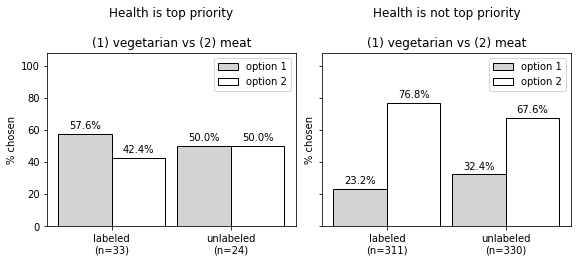

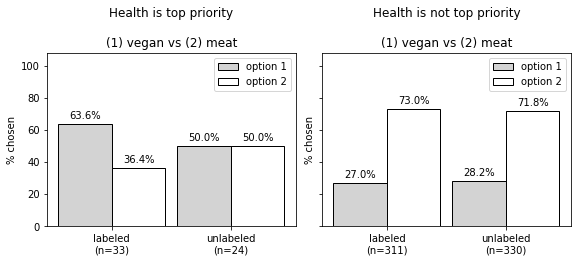

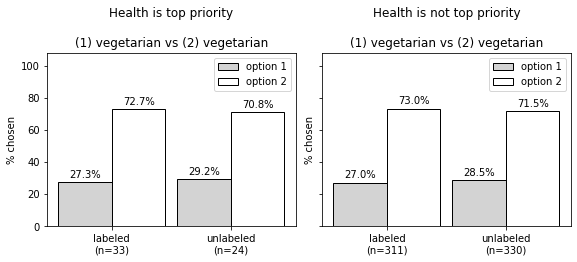

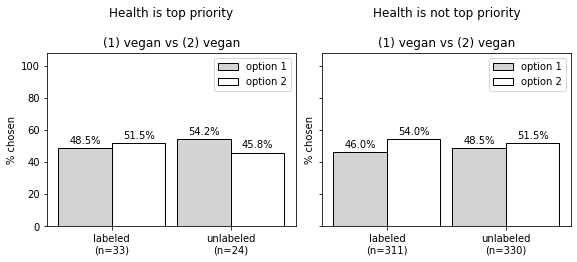

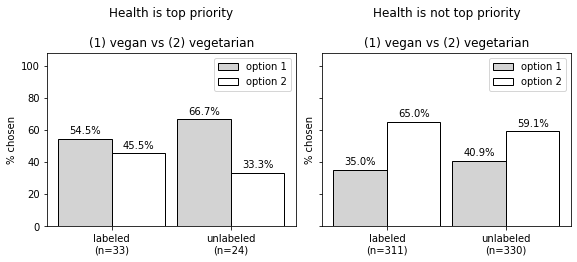

In [110]:
for choice_type, name in plot_choices_type_names_dict.items():
    cdf = choices_df[choices_df['choice_type']==choice_type]
    yes_prioritize_health_df = cdf[cdf['top_1_priority_health'] > 0]
    no_prioritize_health_df = cdf[cdf['top_1_priority_health'] < 1]
    fig,axes = plt.subplots(1,2, figsize=(8,3), sharey=True)
    plt.tight_layout()
    for i, (g, df) in enumerate([('Health is top priority',yes_prioritize_health_df),('Health is not top priority',no_prioritize_health_df),]):
        ax = axes[i]
        ax.set_title('%s\n\n%s'%(g, name))
        contingency_df = make_contingency_df(df)
        plot_df = plot_contingency_table(contingency_df, ax)
    plt.show()

1: 1=(labeled) vegetarian vs 0=meat


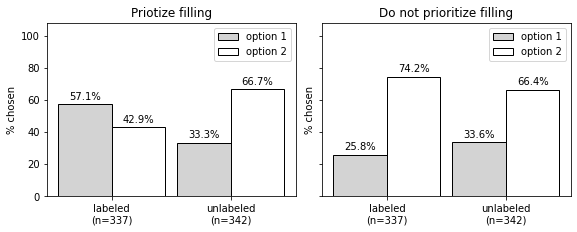

2: 1=(labeled) vegan vs 0=meat


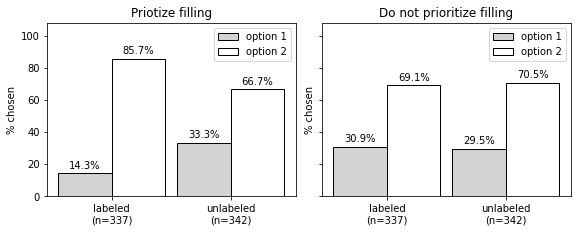

3: 1=(labeled) vegetarian vs 0=vegetarian


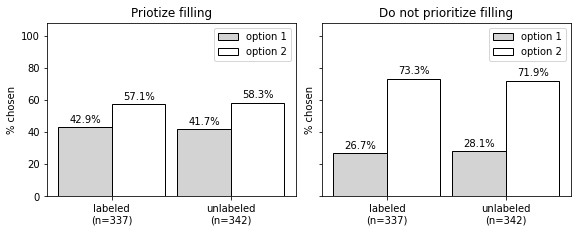

4: 1=(labeled) vegan vs 0=vegan


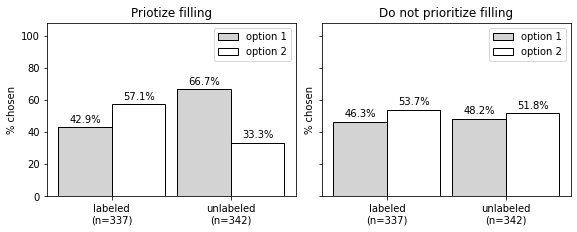

5: 1=(labeled) vegan vs 0=vegetarian


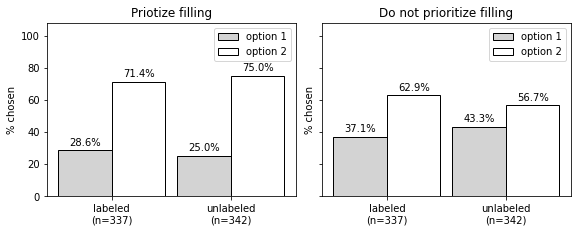

In [111]:
for choice_type, name in choices_type_names_dict.items():
    print('%s: %s' % (choice_type, choices_type_names_dict[choice_type]))
    cdf = choices_df[choices_df['choice_type']==choice_type]
    yes_prioritize_df = cdf[cdf['top_1_priority_filling'] > 0]
    no_prioritize_df = cdf[cdf['top_1_priority_filling'] < 1]
    fig,axes = plt.subplots(1,2, figsize=(8,3), sharex=True, sharey=True)
    plt.tight_layout()
    for i, (g, df) in enumerate([('Priotize filling',yes_prioritize_df),('Do not prioritize filling',no_prioritize_df),]):
        ax = axes[i]
        ax.set_title(g)
        contingency_df = make_contingency_df(df)
        plot_df = plot_contingency_table(contingency_df, ax)
    plt.show()

In [112]:
eq = (
    "choice ~ labeled + gender + (labeled|ResponseId)"
    "+ priority_health + priority_taste + priority_filling + priority_usual_choice"
    "+ priority_health:labeled"
    "+ priority_taste:labeled + priority_filling:labeled + priority_usual_choice:labeled"
)
print(Lmer(eq, data=choices_df, family="binomial").fit())

Model failed to converge with max|grad| = 0.0151958 (tol = 0.001, component 1) 

Formula: choice~labeled+gender+(labeled|ResponseId)+priority_health+priority_taste+priority_filling+priority_usual_choice+priority_health:labeled+priority_taste:labeled+priority_filling:labeled+priority_usual_choice:labeled

Family: binomial	 Inference: parametric

Number of observations: 3490	 Groups: {'ResponseId': 698.0}

Log-likelihood: -2215.132 	 AIC: 4458.264

Random effects:

                   Name    Var    Std
ResponseId  (Intercept)  0.165  0.406
ResponseId      labeled  0.530  0.728

                    IV1      IV2   Corr
ResponseId  (Intercept)  labeled -0.324

Fixed effects:

                               Estimate  2.5_ci  97.5_ci     SE     OR  \
(Intercept)                      -0.356  -0.628   -0.084  0.139  0.701   
labeled                          -0.254  -0.682    0.174  0.218  0.776   
gender                           -0.240  -0.410   -0.070  0.087  0.787   
priority_health         

In [113]:
print('Vegan choice types only')
for pkey, pname in codebook['Q_priorities']['choices'].items():
    print('\n----------- priority %s: %s -----------\n' % (pkey, pname))
    eq = (
        "choice ~ labeled + priority_%s  + priority_%s:labeled + gender + (labeled|ResponseId)"%(pname, pname)
    )
    print(Lmer(eq, data=choices_df[choices_df.choice_type.isin(vegan_choice_types)], family="binomial").fit())
    

Vegan choice types only

----------- priority 1: health -----------

unable to evaluate scaled gradient 

Model failed to converge: degenerate  Hessian with 1 negative eigenvalues 

Formula: choice~labeled+priority_health+priority_health:labeled+gender+(labeled|ResponseId)

Family: binomial	 Inference: parametric

Number of observations: 2094	 Groups: {'ResponseId': 698.0}

Log-likelihood: -1377.458 	 AIC: 2770.916

Random effects:

                   Name    Var    Std
ResponseId  (Intercept)  0.262  0.512
ResponseId      labeled  0.598  0.774

                    IV1      IV2   Corr
ResponseId  (Intercept)  labeled -0.469

Fixed effects:

                         Estimate  2.5_ci  97.5_ci     SE     OR  OR_2.5_ci  \
(Intercept)                -0.357  -0.505   -0.209  0.076  0.700      0.603   
labeled                    -0.156  -0.373    0.061  0.111  0.856      0.689   
priority_health             0.162   0.049    0.274  0.058  1.175      1.050   
gender                     -0.200  

In [114]:
print('check w. choice_vegan')
for pkey, pname in codebook['Q_priorities']['choices'].items():
    print('\n----------- priority %s: %s -----------\n' % (pkey, pname))
    eq = (
        "choice ~ labeled + priority_%s  + choice_vegan + priority_%s:labeled + priority_%s:labeled:choice_vegan + gender + (labeled|ResponseId)"%(pname, pname, pname)
    )
    print(Lmer(eq, data=choices_df, family="binomial").fit())
    

check w. choice_vegan

----------- priority 1: health -----------

Formula: choice~labeled+priority_health+choice_vegan+priority_health:labeled+priority_health:labeled:choice_vegan+gender+(labeled|ResponseId)

Family: binomial	 Inference: parametric

Number of observations: 3490	 Groups: {'ResponseId': 698.0}

Log-likelihood: -2199.232 	 AIC: 4418.463

Random effects:

                   Name    Var    Std
ResponseId  (Intercept)  0.206  0.453
ResponseId      labeled  0.573  0.757

                    IV1      IV2   Corr
ResponseId  (Intercept)  labeled -0.335

Fixed effects:

                                      Estimate  2.5_ci  97.5_ci     SE     OR  \
(Intercept)                             -0.839  -0.993   -0.685  0.078  0.432   
labeled                                 -0.217  -0.399   -0.035  0.093  0.805   
priority_health                          0.141   0.051    0.231  0.046  1.151   
choice_vegan                             0.506   0.353    0.658  0.078  1.658   
gender     

unable to evaluate scaled gradient 

Model failed to converge: degenerate  Hessian with 1 negative eigenvalues 

Formula: choice~labeled+priority_usual_choice+choice_vegan+priority_usual_choice:labeled+priority_usual_choice:labeled:choice_vegan+gender+(labeled|ResponseId)

Family: binomial	 Inference: parametric

Number of observations: 3490	 Groups: {'ResponseId': 698.0}

Log-likelihood: -2206.852 	 AIC: 4433.705

Random effects:

                   Name    Var    Std
ResponseId  (Intercept)  0.204  0.452
ResponseId      labeled  0.522  0.723

                    IV1      IV2   Corr
ResponseId  (Intercept)  labeled -0.164

Fixed effects:

                                            Estimate  2.5_ci  97.5_ci     SE  \
(Intercept)                                   -0.966  -1.130   -0.801  0.084   
labeled                                       -0.178  -0.381    0.025  0.104   
priority_usual_choice                         -0.132  -0.219   -0.045  0.045   
choice_vegan                    

Test sentiments about environment and whether vegetarian/vegan dishes are good for the environment.

Separate the population into people who agree veg dishes are good for the environment and those who do not.

In [115]:
veg_good_choices_df = choices_df[choices_df['veg_good_for_env']==1]
not_veg_good_choices_df = choices_df[choices_df['veg_good_for_env']==0]
print(len(choices_df))
print(len(veg_good_choices_df))
print(len(not_veg_good_choices_df))
not_veg_good_choices_df.head()

3490
2380
1110


,ResponseId,QID,choice,choice_type,labeled,option_w_meat,choice_vegetarian,choice_vegan,gender,male,...,priority_health,priority_cost,priority_taste,priority_filling,priority_usual_choice,top_1_priority_health,top_1_priority_cost,top_1_priority_taste,top_1_priority_filling,top_1_priority_usual_choice
3,R_2B97XuOwuxSeQWA,Q_sandwich_1,0,1,0,1,1,0,0.5,1,...,0,2,1,-1,-2,0,1,0,0,0
8,R_2SdGAfdbJx8Aq5C,Q_sandwich_1,0,1,0,1,1,0,0.5,1,...,2,-2,1,-1,0,1,0,0,0,0
12,R_30rbJTBzyanldWc,Q_sandwich_1,0,1,0,1,1,0,0.5,1,...,-2,0,2,1,-1,0,0,1,0,0
14,R_2WBvDkGf61dghtw,Q_sandwich_1,0,1,0,1,1,0,0.5,1,...,1,-1,2,0,-2,0,0,1,0,0
21,R_3wLkXI2zKmZFfmF,Q_sandwich_1,0,1,0,1,1,0,0.5,1,...,-2,1,2,-1,0,0,0,1,0,0


Run the model with all choice types and gender with only participants who agree that veg dishes are good for the environment, to see whether there is still a negative impact for labels.

In [222]:
eq = (
    "choice ~ labeled + male + option_w_meat"
    "+ option_w_meat:male"
    "+ (labeled|ResponseId) + (labeled|choice_type)"
)
Lmer(eq, data=veg_good_choices_df, family="binomial").fit()

boundary (singular) fit: see ?isSingular 

Formula: choice~labeled+male+option_w_meat+option_w_meat:male+(labeled|ResponseId)+(labeled|choice_type)

Family: binomial	 Inference: parametric

Number of observations: 2380	 Groups: {'ResponseId': 476.0, 'choice_type': 5.0}

Log-likelihood: -1518.763 	 AIC: 3059.525

Random effects:

                    Name    Var    Std
ResponseId   (Intercept)  0.226  0.475
ResponseId       labeled  0.389  0.623
choice_type  (Intercept)  0.079  0.281
choice_type      labeled  0.005  0.070

                     IV1      IV2   Corr
ResponseId   (Intercept)  labeled  0.017
choice_type  (Intercept)  labeled  1.000

Fixed effects:



,Estimate,2.5_ci,97.5_ci,SE,OR,OR_2.5_ci,OR_97.5_ci,Prob,Prob_2.5_ci,Prob_97.5_ci,Z-stat,P-val,Sig
(Intercept),-0.525,-0.899,-0.150,0.191,0.592,0.407,0.861,0.372,0.289,0.463,-2.744,0.006,**
labeled,-0.209,-0.435,0.016,0.115,0.811,0.647,1.016,0.448,0.393,0.504,-1.818,0.069,.
male,0.276,0.020,0.531,0.130,1.317,1.021,1.700,0.568,0.505,0.630,2.117,0.034,*
option_w_meat,0.237,-0.344,0.818,0.296,1.267,0.709,2.266,0.559,0.415,0.694,0.799,0.424,
male:option_w_meat,-1.085,-1.461,-0.709,0.192,0.338,0.232,0.492,0.253,0.188,0.330,-5.662,0.000,***


In [116]:
# Just choice type 5:
c_df = not_veg_good_choices_df[not_veg_good_choices_df.choice_type == 5]
eq = "choice ~ labeled"
choice_type_model = smf.logit(eq, data=c_df).fit()
print(choice_type_model.summary())
choice_type_model_odds = pd.DataFrame(np.exp(choice_type_model.params), columns=['OR'])
choice_type_model_odds['z-value'] = choice_type_model.pvalues
choice_type_model_odds[['2.5%', '97.5%']] = np.exp(choice_type_model.conf_int())
print(choice_type_model_odds)

Optimization terminated successfully.
         Current function value: 0.670200
         Iterations 4
                           Logit Regression Results                           
Dep. Variable:                 choice   No. Observations:                  222
Model:                          Logit   Df Residuals:                      220
Method:                           MLE   Df Model:                            1
Date:                Tue, 16 Aug 2022   Pseudo R-squ.:                0.001971
Time:                        00:06:40   Log-Likelihood:                -148.78
converged:                       True   LL-Null:                       -149.08
Covariance Type:            nonrobust   LLR p-value:                    0.4433
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -0.3145      0.194     -1.622      0.105      -0.695       0.066
labeled       -0.2105      0.

In [117]:
# Just choice type 5:
c_df = veg_good_choices_df[veg_good_choices_df.choice_type == 5]
eq = "choice ~ labeled"
choice_type_model = smf.logit(eq, data=c_df).fit()
print(choice_type_model.summary())
choice_type_model_odds = pd.DataFrame(np.exp(choice_type_model.params), columns=['OR'])
choice_type_model_odds['z-value'] = choice_type_model.pvalues
choice_type_model_odds[['2.5%', '97.5%']] = np.exp(choice_type_model.conf_int())
print(choice_type_model_odds)

Optimization terminated successfully.
         Current function value: 0.670754
         Iterations 4
                           Logit Regression Results                           
Dep. Variable:                 choice   No. Observations:                  476
Model:                          Logit   Df Residuals:                      474
Method:                           MLE   Df Model:                            1
Date:                Tue, 16 Aug 2022   Pseudo R-squ.:                0.002847
Time:                        00:06:40   Log-Likelihood:                -319.28
converged:                       True   LL-Null:                       -320.19
Covariance Type:            nonrobust   LLR p-value:                    0.1769
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -0.2877      0.129     -2.228      0.026      -0.541      -0.035
labeled       -0.2533      0.

In [118]:
eq = (
    "choice ~ labeled + env_is_important"
    "+ env_is_important:labeled" 
    "+ (1|ResponseId)"
)
Lmer(
    eq,
    data=choices_df, 
    family="binomial"
).fit()

Formula: choice~labeled+env_is_important+env_is_important:labeled+(1|ResponseId)

Family: binomial	 Inference: parametric

Number of observations: 3490	 Groups: {'ResponseId': 698.0}

Log-likelihood: -2237.320 	 AIC: 4484.640

Random effects:

                   Name    Var    Std
ResponseId  (Intercept)  0.379  0.615

No random effect correlations specified

Fixed effects:



,Estimate,2.5_ci,97.5_ci,SE,OR,OR_2.5_ci,OR_97.5_ci,Prob,Prob_2.5_ci,Prob_97.5_ci,Z-stat,P-val,Sig
(Intercept),-0.865,-1.164,-0.567,0.152,0.421,0.312,0.567,0.296,0.238,0.362,-5.681,0.000,***
labeled,0.137,-0.268,0.541,0.206,1.147,0.765,1.719,0.534,0.433,0.632,0.663,0.507,
env_is_important,0.323,-0.002,0.648,0.166,1.381,0.998,1.912,0.580,0.500,0.657,1.949,0.051,.
labeled:env_is_important,-0.353,-0.800,0.094,0.228,0.703,0.449,1.099,0.413,0.310,0.524,-1.547,0.122,


In [119]:
eq = (
    "choice ~ labeled + veg_good_for_env"
    "+ veg_good_for_env:labeled"
    "+ (1|ResponseId)"
)
Lmer(
    eq,
    data=choices_df, 
    family="binomial"
).fit()

Formula: choice~labeled+veg_good_for_env+veg_good_for_env:labeled+(1|ResponseId)

Family: binomial	 Inference: parametric

Number of observations: 3490	 Groups: {'ResponseId': 698.0}

Log-likelihood: -2233.101 	 AIC: 4476.202

Random effects:

                   Name    Var    Std
ResponseId  (Intercept)  0.367  0.606

No random effect correlations specified

Fixed effects:



,Estimate,2.5_ci,97.5_ci,SE,OR,OR_2.5_ci,OR_97.5_ci,Prob,Prob_2.5_ci,Prob_97.5_ci,Z-stat,P-val,Sig
(Intercept),-0.831,-1.052,-0.610,0.113,0.436,0.349,0.543,0.303,0.259,0.352,-7.381,0.000,***
labeled,-0.141,-0.452,0.169,0.158,0.868,0.637,1.184,0.465,0.389,0.542,-0.893,0.372,
veg_good_for_env,0.339,0.077,0.600,0.133,1.403,1.080,1.822,0.584,0.519,0.646,2.540,0.011,*
labeled:veg_good_for_env,-0.013,-0.384,0.359,0.190,0.987,0.681,1.432,0.497,0.405,0.589,-0.067,0.947,


In [120]:
eq = (
    "choice ~ labeled + (labeled|ResponseId)"
)
Lmer(eq, data=veg_good_choices_df, family="binomial").fit()

Formula: choice~labeled+(labeled|ResponseId)

Family: binomial	 Inference: parametric

Number of observations: 2380	 Groups: {'ResponseId': 476.0}

Log-likelihood: -1557.390 	 AIC: 3124.780

Random effects:

                   Name    Var    Std
ResponseId  (Intercept)  0.178  0.422
ResponseId      labeled  0.544  0.738

                    IV1      IV2   Corr
ResponseId  (Intercept)  labeled -0.309

Fixed effects:



,Estimate,2.5_ci,97.5_ci,SE,OR,OR_2.5_ci,OR_97.5_ci,Prob,Prob_2.5_ci,Prob_97.5_ci,Z-stat,P-val,Sig
(Intercept),-0.473,-0.604,-0.343,0.067,0.623,0.547,0.710,0.384,0.353,0.415,-7.109,0.000,***
labeled,-0.193,-0.401,0.015,0.106,0.824,0.669,1.015,0.452,0.401,0.504,-1.817,0.069,.


In [121]:
eq = (
    "choice ~ labeled + (labeled|ResponseId)"
)
Lmer(eq, data=not_veg_good_choices_df, family="binomial").fit()

Formula: choice~labeled+(labeled|ResponseId)

Family: binomial	 Inference: parametric

Number of observations: 1110	 Groups: {'ResponseId': 222.0}

Log-likelihood: -672.988 	 AIC: 1355.975

Random effects:

                   Name    Var    Std
ResponseId  (Intercept)  0.285  0.534
ResponseId      labeled  0.592  0.769

                    IV1      IV2   Corr
ResponseId  (Intercept)  labeled -0.275

Fixed effects:



,Estimate,2.5_ci,97.5_ci,SE,OR,OR_2.5_ci,OR_97.5_ci,Prob,Prob_2.5_ci,Prob_97.5_ci,Z-stat,P-val,Sig
(Intercept),-0.818,-1.038,-0.597,0.112,0.442,0.354,0.550,0.306,0.262,0.355,-7.277,0.000,***
labeled,-0.206,-0.546,0.133,0.173,0.814,0.579,1.143,0.449,0.367,0.533,-1.190,0.234,


Test impact of people agreeing that "vegan dishes are not for me".

Limit analysis to choice types with vegan options (2,4,5)

In [122]:
eq = "choice ~ labeled + vegan_not_me + vegan_not_me:labeled + (1|ResponseId)"
Lmer(
    eq,
    data=choices_df[choices_df.choice_type.isin(vegan_choice_types)], 
    family="binomial"
).fit()

Formula: choice~labeled+vegan_not_me+vegan_not_me:labeled+(1|ResponseId)

Family: binomial	 Inference: parametric

Number of observations: 2094	 Groups: {'ResponseId': 698.0}

Log-likelihood: -1381.363 	 AIC: 2772.726

Random effects:

                   Name    Var    Std
ResponseId  (Intercept)  0.382  0.618

No random effect correlations specified

Fixed effects:



,Estimate,2.5_ci,97.5_ci,SE,OR,OR_2.5_ci,OR_97.5_ci,Prob,Prob_2.5_ci,Prob_97.5_ci,Z-stat,P-val,Sig
(Intercept),-0.317,-0.486,-0.148,0.086,0.728,0.615,0.863,0.421,0.381,0.463,-3.667,0.000,***
labeled,-0.059,-0.297,0.179,0.121,0.943,0.743,1.196,0.485,0.426,0.545,-0.485,0.628,
vegan_not_me,-0.391,-0.713,-0.068,0.165,0.677,0.490,0.935,0.404,0.329,0.483,-2.371,0.018,*
labeled:vegan_not_me,-0.308,-0.787,0.171,0.244,0.735,0.455,1.187,0.424,0.313,0.543,-1.259,0.208,


In [123]:
for choice_type in vegan_choice_types:
    print('\n-------- Model for comparison type %s ( %s ) --------\n' % (
        choice_type, choices_type_names_dict[choice_type]))
    c_df = choices_df[choices_df.choice_type == choice_type]
    eq = "choice ~ labeled + vegan_not_me + vegan_not_me:labeled"
    choice_type_model = smf.logit(eq, data=c_df).fit()
    print(choice_type_model.summary())
    choice_type_model_odds = pd.DataFrame(np.exp(choice_type_model.params), columns=['OR'])
    choice_type_model_odds['z-value'] = choice_type_model.pvalues
    choice_type_model_odds[['2.5%', '97.5%']] = np.exp(choice_type_model.conf_int())
    print(choice_type_model_odds)


-------- Model for comparison type 2 ( 1=(labeled) vegan vs 0=meat ) --------

Optimization terminated successfully.
         Current function value: 0.592479
         Iterations 6
                           Logit Regression Results                           
Dep. Variable:                 choice   No. Observations:                  698
Model:                          Logit   Df Residuals:                      694
Method:                           MLE   Df Model:                            3
Date:                Tue, 16 Aug 2022   Pseudo R-squ.:                 0.03125
Time:                        00:07:11   Log-Likelihood:                -413.55
converged:                       True   LL-Null:                       -426.89
Covariance Type:            nonrobust   LLR p-value:                 6.872e-06
                           coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------
Intercep

## Comments

The survey comments are fun to read. And informative.

High level notes:
- people do not like onions
- some people do not like olives and pointed out that the vegan/vegetarian options had more olives
- some people did not like any of the menu options
- people did not appreciate that political spectrum was presented on a democrat to republican scale
- many people enjoyed/appreciated the study and said so.
- some people enjoyed the roasted attention check

In [124]:
comments = respondent_df.set_index('ResponseId')['Q_comments'].rename('comments').dropna()

for c in comments.to_list():
    print('"%s"\n'%c)

"I do not lean toward either party. I am a libertarian. Unfortunately, your survey doesn't treat libertarians as if they exist at all."

"None, but thank you!"

"ty"

"no"

"No thanks! "

"Enjoyed the study!"

"In a complex economy vegetarian or "vegan" options are only beneficial if they are produced locally. Since many of us live in climates that do not support year round vegetable agriculture that means most of what veggies consume is from somewhere far away and probably in a place lacking in water. Also, there are far more options than Democrat and Republican. Two sides of the same capitalist coin are not a democracy and the cause of much of the worlds problems."

"Thank you for the study, I answered honestly and to the best of my abilities."

"No"

"could have used a few more attention checks... jk."

"Hope I was helpful"

"No"

"None "

"Enjoyed the survey!"

"no"

"None but I cant eat onions"

"None."

"thanks"

":)"

"No comments "

"You should have option for neither on leanin